### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 5
### Due: Friday, Mar 27th at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

**1) Read in `hw5_data_1.npy`. This is a (10 x 3) numpy array, containing some time-series measurements. It could be flux measurements from a star or some other transient. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.**

**2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:**

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

**where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.**

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

**3) Using one of the MCMC codes that we looked at in class (`emcee`, `pymc3`, `PTMCMCSampler`) perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.**

**4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).**

**5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.**

**6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.**

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

The priors for this model are the same as above for the equivalent parameters, and with $\ln\sigma_W\in\mathrm{Uniform}[-2,2]$. Following the examples from `Lecture 12` and from relevant web tutorials/documentation, use one of the nested sampling packages (`dynesty` or `UltraNest`) to compute the Bayesian evidence for this Gaussian model, and for the original burst model. Compute the Bayes factor, and state which model is the favored description of the data. *Hint: Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors. An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did above.*

### Solution

In [179]:
# IMPORTS
##########
##########

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import corner
import random as r
%matplotlib inline

from scipy.stats import norm
from scipy.stats import uniform

## Part 1

In [35]:
#CLD reading in the data 
placeholder = np.load('../../../coursework/homeworks/hw_data/hw5_data_1.npy')
time = placeholder[:,0]
flux = placeholder[:,1]
error = placeholder[:,2]

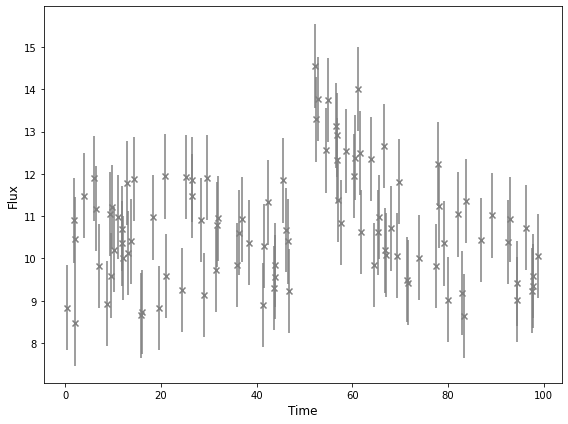

In [15]:
#CLD plotting this data with the respective error bars, flux v time
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(time, flux, c='grey', marker='x')
ax.errorbar(time, flux, yerr=error, c='grey', fmt='none')
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Flux', fontsize=12)
fig.tight_layout()
plt.show(fig);

## Part 2

In [85]:
#CLD writing the code for this burst model
#CLD coeff should be in format [b, A, alpha, t0]
def burst_model(coeff, x):
    y_fit = []
    for i in range(len(x)):
        if x[i]<coeff[3]:
            y_fit.append(coeff[0])
        if x[i]>=coeff[3]:
            y_fit.append(coeff[0] + coeff[1]*np.exp(-coeff[2]*(x[i] - coeff[3])))
    return np.asarray(y_fit)

def burst_likelihood(coeff, t, f, e):
    fit = burst_model(coeff, t) #CLD fitting using the burst model
    L = np.prod(norm.pdf(f, fit, e))#CLD the likelihood with priors of the burst model
    return L

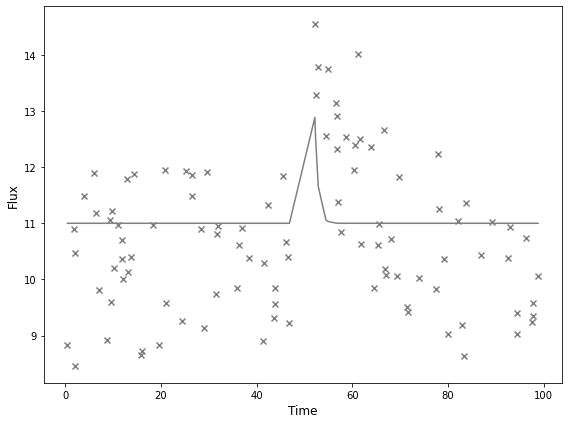

In [73]:
#CLD checking burst model code real quick
y = burst_model([11,50,1.5,50], time)
#CLD plotting this data with the respective error bars, flux v time
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(time, flux, c='grey', marker='x')
ax.plot(time, y, c='grey')
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Flux', fontsize=12)
fig.tight_layout()
plt.show(fig);

#CLD i mean it looks bad but it is working

## Part 3

In [100]:
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

Do not have mpi4py package.


In [104]:
#CLD coding in the priors 
def priors(coeff):
    p1 = uniform.pdf(coeff[0], 0, 50) #CLD prior on b
    p2 = uniform.pdf(coeff[1], 0, 50) #CLD prior on A
    
    lna = np.log(coeff[2]) #CLD need lna for prior
    p3 = uniform.pdf(lna, -5, (5+5)) #CLD prior on lna
    p4 = uniform.pdf(coeff[3], 0, 100) #CLD prior on t0
    
    return p1*p2*p3*p4

def log_prior(coeff):
    return np.log(priors(coeff))

def logL(coeff):
    return np.log(burst_likelihood(coeff, time, flux, error))

In [154]:
ndim = 4 #CLD number of parameters I'm fitting

# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.01**2)

# intialize sampler
sampler = ptmcmc(ndim, logL, log_prior, cov, 
                 outDir='./my_ptmcmc_chain', resume=False)

# sampler for N steps
N = int(12e4)
x0 = np.random.random((ndim,))+10
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50)

Finished 0.83 percent in 0.919588 s Acceptance rate = 0.953

<ipython-input-104-caac95dc2153>:16: RuntimeWarning: divide by zero encountered in log
  return np.log(burst_likelihood(coeff, time, flux, error))


Finished 1.67 percent in 1.869795 s Acceptance rate = 0.806

<ipython-input-104-caac95dc2153>:13: RuntimeWarning: divide by zero encountered in log
  return np.log(priors(coeff))
<ipython-input-104-caac95dc2153>:6: RuntimeWarning: invalid value encountered in log
  lna = np.log(coeff[2]) #CLD need lna for prior
<ipython-input-85-5ab630f015c8>:9: RuntimeWarning: overflow encountered in double_scalars
  y_fit.append(coeff[0] + coeff[1]*np.exp(-coeff[2]*(x[i] - coeff[3])))
<ipython-input-85-5ab630f015c8>:9: RuntimeWarning: overflow encountered in exp
  y_fit.append(coeff[0] + coeff[1]*np.exp(-coeff[2]*(x[i] - coeff[3])))
/Users/carriedrake/opt/anaconda3/envs/astr8070/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:243: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C


Finished 8.33 percent in 8.568245 s Acceptance rate = 0.425533Adding DE jump with weight 50
Finished 99.17 percent in 103.546083 s Acceptance rate = 0.224193
Run Complete


## Part 4

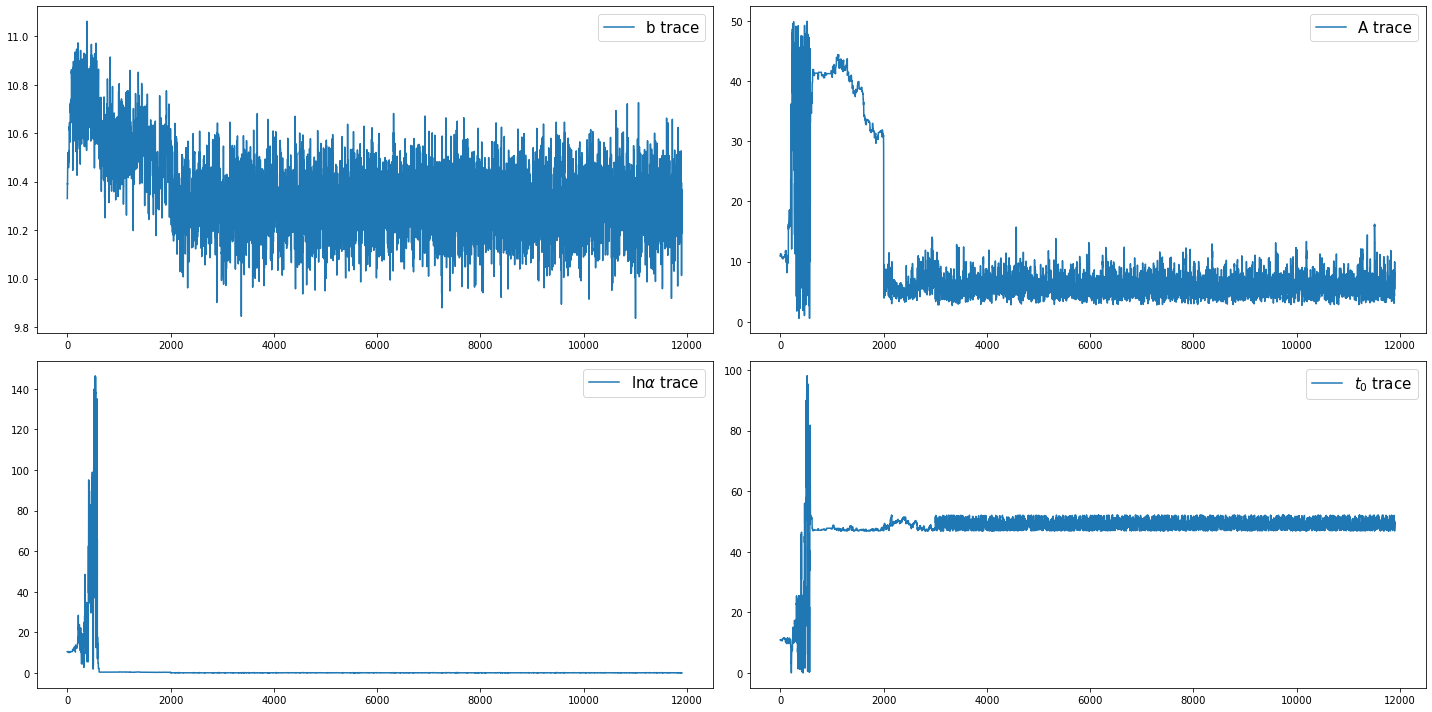

In [155]:
#CLD plotting the trace to check for where a good place to start burn in would be
#CLD loading in the traces from the ptmcmc
chain = np.loadtxt('./my_ptmcmc_chain/chain_1.txt')

bs = chain[:,0]
As = chain[:,1]
alphas = chain[:,2]
ts = chain[:,3]
M = len(bs)

grid = np.linspace(0,M,M)

fig, ax = plt.subplots(2,2,figsize=(20,10))
ax[0,0].plot(grid, bs, label='b trace')
ax[0,1].plot(grid, As, label='A trace')
ax[1,0].plot(grid, alphas, label=r'ln$\alpha$ trace')
ax[1,1].plot(grid, ts, label=r'$t_0$ trace')
ax[0,0].legend(fontsize=15)
ax[0,1].legend(fontsize=15)
ax[1,0].legend(fontsize=15)
ax[1,1].legend(fontsize=15)
fig.tight_layout()
plt.show(fig);

To me, it looks like a good burn in place would be at about 4000 for each of the graphs.

In [169]:
#CLD to calculate the autocorrelation length use the same diagnostic method presented in lecture 11
import acor
b_auto = acor.acor(chain[burn:,0]) 
a_auto = acor.acor(chain[burn:,1])
alpha_auto = acor.acor(chain[burn:,2])
t_auto = acor.acor(chain[burn:,3])

#CLD the autocorrelation length is the nearest int to the first element in the tuple
print(int(b_auto[0]))
print(int(a_auto[0]))
print(int(alpha_auto[0]))
print(int(t_auto[0]))

3
5
6
5


In [160]:
#CLD burning in the chains with my burn in value
burn = 4000

b_burn = bs[burn:]
a_burn = As[burn:]
alpha_burn = alphas[burn:]
t_burn = ts[burn:]

#CLD making autocorrelation thinning indices arrays
b_ind = np.arange(0, len(b_burn), int(b_auto[0]))
a_ind = np.arange(0, len(a_burn), int(b_auto[0]))
alpha_ind = np.arange(0, len(alpha_burn), int(b_auto[0]))
t_ind = np.arange(0, len(t_burn), int(b_auto[0]))

#CLD masking the burned in trace array to the thined indices of these arrays
b_burn_thin = b_burn[b_ind]
a_burn_thin = a_burn[a_ind]
alpha_burn_thin = alpha_burn[alpha_ind]
t_burn_thin = t_burn[t_ind]

2634
2634
2634
2634


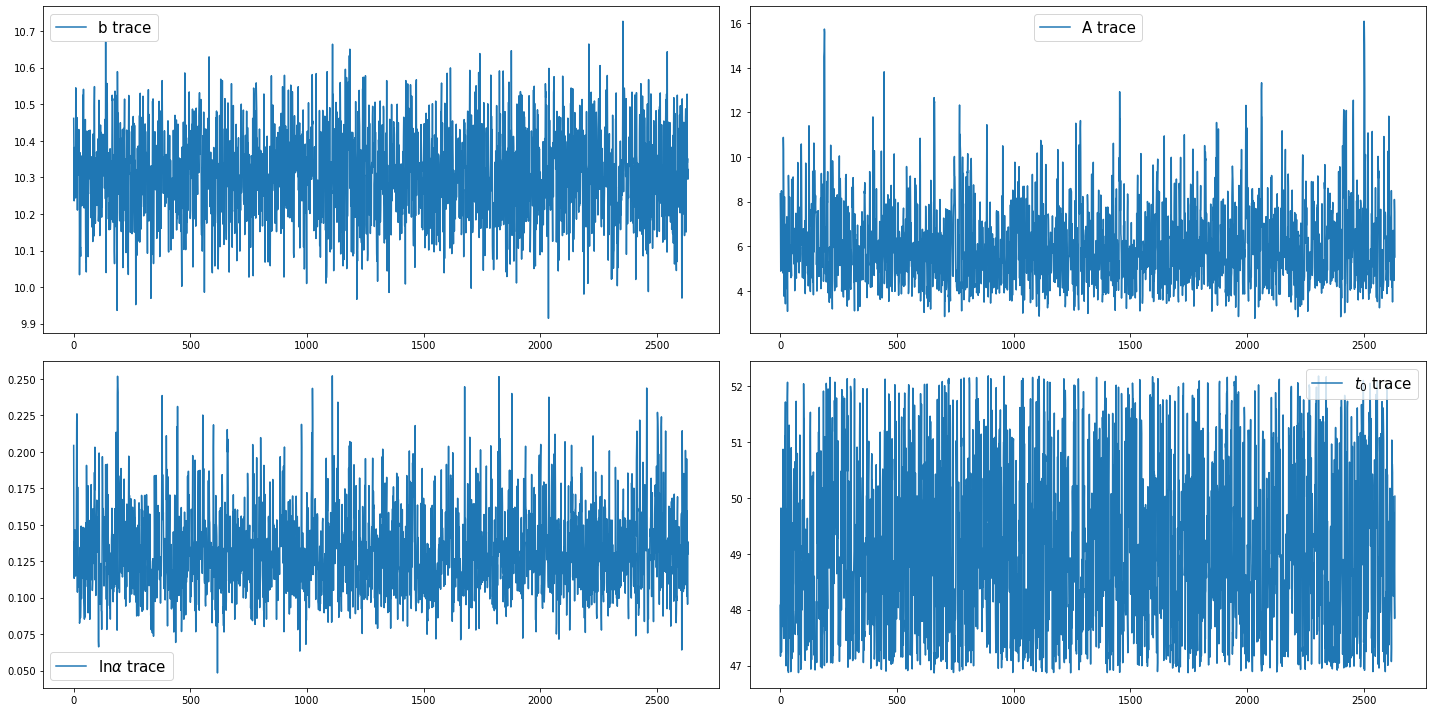

In [161]:
#CLD checking to make sure I don't need more samples by replotting traces and seeing size of the arrays
#CLD begin by making new x grid for each set of samples as they were thinned by a different amount
bgrid = np.linspace(0, len(b_burn_thin),len(b_burn_thin))
agrid = np.linspace(0, len(a_burn_thin),len(a_burn_thin))
alphagrid = np.linspace(0, len(alpha_burn_thin),len(alpha_burn_thin))
tgrid = np.linspace(0, len(t_burn_thin),len(t_burn_thin))

#CLD the grid lengths should be good reps of new size of each chain
print(len(bgrid))
print(len(agrid))
print(len(alphagrid))
print(len(tgrid))

#CLD plotting the thinned and burned trace plots
fig, ax = plt.subplots(2,2,figsize=(20,10))
ax[0,0].plot(bgrid, b_burn_thin, label='b trace')
ax[0,1].plot(agrid, a_burn_thin, label='A trace')
ax[1,0].plot(alphagrid, alpha_burn_thin, label=r'ln$\alpha$ trace')
ax[1,1].plot(tgrid, t_burn_thin, label=r'$t_0$ trace')
ax[0,0].legend(fontsize=15)
ax[0,1].legend(fontsize=15)
ax[1,0].legend(fontsize=15)
ax[1,1].legend(fontsize=15)
fig.tight_layout()
plt.show(fig);

## Part 5

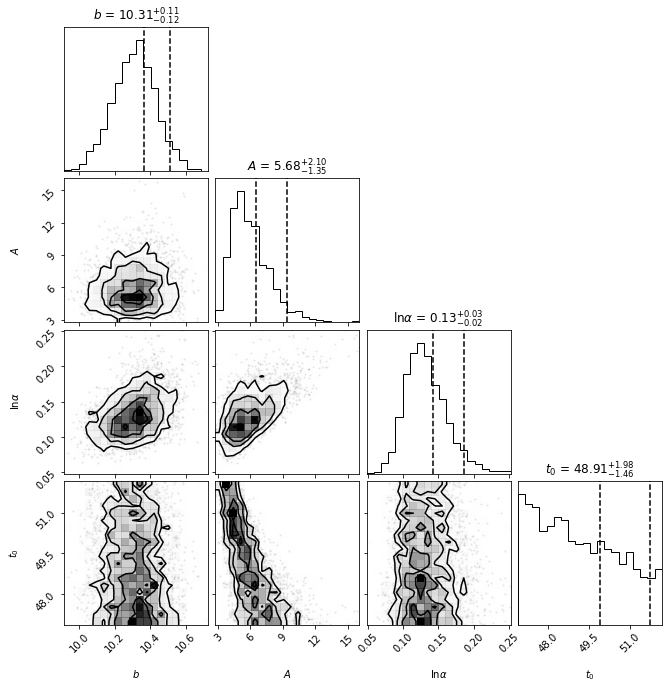

In [178]:
#CLD making a corner plot in 4d parameter space
ndim, nsamples = 1, len(bgrid)

data = np.hstack([b_burn_thin.reshape([nsamples,ndim]), a_burn_thin.reshape([nsamples,ndim]), 
                  alpha_burn_thin.reshape([nsamples,ndim]), t_burn_thin.reshape([nsamples,ndim])])
figure = corner.corner(data, labels=[r"$b$", r"$A$", r"$\ln \alpha$", r"$t_0$"],
                       quantiles=[0.68, 0.95], show_titles=True, title_kwargs={"fontsize": 12})

## Problem 6

In [182]:
#CLD drawing the 100 random samples for each coeff
bees = r.choices(b_burn_thin, k=100)
aees = r.choices(a_burn_thin, k=100)
alphaees = r.choices(alpha_burn_thin, k=100)
tees = r.choices(t_burn_thin, k=100)

In [185]:
#CLD making the coeff arrays
models = []
for i in range(100):
    coeffs = np.array([bees[i], aees[i], alphaees[i], tees[i]])
    model = burst_model(coeffs, time)
    models.append(model)

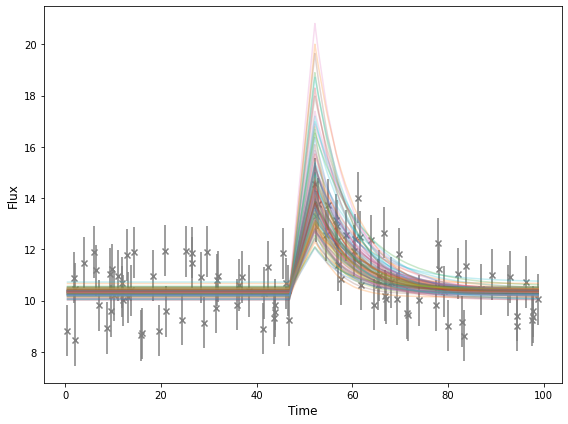

In [190]:
#CLD plotting all the models on top of the original data pts
fig, ax = plt.subplots(figsize=(8,6))
for model in models:
    ax.plot(time, model, alpha=0.25)
ax.scatter(time, flux, c='grey', marker='x')
ax.errorbar(time, flux, yerr=error, c='grey', fmt='none')
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Flux', fontsize=12)
fig.tight_layout()
plt.show(fig);

## Part 7

In [229]:
#CLD first coding the new burst model
def burst_model_2(coeff, x):
    #CLD coefff should be in the order of [b, A, t_0, sig]
    y = coeff[0] + coeff[1]*np.exp(-(x - coeff[2])**2 / (2 * coeff[3]**2))
    return y

In [224]:
#CLD coding the priors and likelihood functions for the frist model (redoing bc of the cube thing)
def prior_transform(cube):
    params = cube.copy()
    
    #CLD transforming the b param
    lo = 0
    hi = 50
    params[0] = cube[0] * (hi - lo) + lo
    
    #CLD same priors on A so doing that transform
    params[1] = cube[1] * (hi - lo) + lo
    
    #CLD transforming the alpha param is this a log uniform prior?
    lo = -5
    hi = 5
    params[2] = (cube[2] * ((hi) - (lo)) + (lo))
    params[2] = 10**params[2]
    
    #CLD transforming the t_0 param
    lo = 0
    hi = 100
    params[3] = cube[3] * (hi - lo) + lo
    
    return params
    
def likelihood(params):
    y_fit = burst_model(params, time)
    L = np.sum(norm.logpdf(flux, y_fit, error))
    return L

In [225]:
#CLD now coding the priors and likelihood functions for the second model
def prior_transform_2(cube):
    params = cube.copy()
    
    #CLD transforming the b param
    lo = 0
    hi = 50
    params[0] = cube[0] * (hi - lo) + lo
    
    #CLD same priors on A so doing that transform
    params[1] = cube[1] * (hi - lo) + lo
    
    #CLD transforming the t_0 param
    lo = 0
    hi = 100
    params[2] = cube[2] * (hi - lo) + lo
    
    #CLD transforming the sig prior
    lo = -2
    hi = 2
    params[3] = (cube[3] * ((hi) - (lo)) + (lo))
    params[3] = 10**params[3]
    
    return params

def likelihood_2(params):
    fit = burst_model_2(params, time) #CLD fitting using the burst model
    L = np.sum(norm.logpdf(flux, fit, error))#CLD the likelihood with priors of the burst model
    return L


In [226]:
import ultranest
from ultranest.plot import cornerplot #CLD will be using as a check with MCMC reuslts above

In [227]:
param_names1 = ['b', 'A', r'$\alpha$', r'$t_0$']
param_names2 = ['b', 'A', r'$t_0$', r'$\sigma$']

In [230]:
#CLD setting up samplers
sampler1 = ultranest.ReactiveNestedSampler(param_names1, likelihood, 
                                          prior_transform)
sampler2 = ultranest.ReactiveNestedSampler(param_names2, likelihood_2, 
                                          prior_transform_2)

DEBUG:ultranest:ReactiveNestedSampler: dims=4+0, resume=False, log_dir=None, backend=hdf5, vectorized=False, nbootstraps=30, ndraw=128..65536
DEBUG:ultranest:ReactiveNestedSampler: dims=4+0, resume=False, log_dir=None, backend=hdf5, vectorized=False, nbootstraps=30, ndraw=128..65536


In [231]:
#CLD running first sampler on the first model
result1 = sampler1.run()
sampler1.print_results()

[ultranest] Sampling 400 live points from prior ...


INFO:ultranest:Sampling 400 live points from prior ...
DEBUG:ultranest:run_iter dlogz=0.5, dKL=0.5, frac_remain=0.01, Lepsilon=0.0010, min_ess=400
DEBUG:ultranest:max_iters=-1, max_ncalls=-1, max_num_improvement_loops=-1, min_num_live_points=400, cluster_num_live_points=40
DEBUG:ultranest:minimal_widths_sequence: [(-inf, 400.0), (inf, 400.0)]


DEBUG:ultranest:iteration=0, ncalls=401, logz=-inf, remainder_fraction=100.0000%, Lmin=-299086.41, Lmax=-179.01


DEBUG:ultranest:iteration=40, ncalls=443, logz=-80479.16, remainder_fraction=100.0000%, Lmin=-80023.58, Lmax=-179.01


DEBUG:ultranest:iteration=80, ncalls=490, logz=-64324.69, remainder_fraction=100.0000%, Lmin=-63686.21, Lmax=-179.01


DEBUG:ultranest:iteration=108, ncalls=528, logz=-53658.98, remainder_fraction=100.0000%, Lmin=-53518.24, Lmax=-179.01


DEBUG:ultranest:iteration=120, ncalls=541, logz=-49027.85, remainder_fraction=100.0000%, Lmin=-48595.87, Lmax=-179.01


DEBUG:ultranest:iteration=160, ncalls=591, logz=-39627.24, remainder_fraction=100.0000%, Lmin=-39130.08, Lmax=-179.01


DEBUG:ultranest:iteration=200, ncalls=647, logz=-30949.95, remainder_fraction=100.0000%, Lmin=-30685.54, Lmax=-179.01


DEBUG:ultranest:iteration=240, ncalls=712, logz=-25892.63, remainder_fraction=100.0000%, Lmin=-25789.15, Lmax=-179.01


DEBUG:ultranest:iteration=270, ncalls=761, logz=-21930.80, remainder_fraction=100.0000%, Lmin=-21921.15, Lmax=-179.01


DEBUG:ultranest:iteration=280, ncalls=771, logz=-20360.09, remainder_fraction=100.0000%, Lmin=-20224.64, Lmax=-179.01


DEBUG:ultranest:iteration=320, ncalls=828, logz=-15936.10, remainder_fraction=100.0000%, Lmin=-15924.93, Lmax=-179.01


DEBUG:ultranest:iteration=360, ncalls=880, logz=-11758.77, remainder_fraction=100.0000%, Lmin=-11644.82, Lmax=-179.01


DEBUG:ultranest:iteration=400, ncalls=934, logz=-9334.05, remainder_fraction=100.0000%, Lmin=-9302.51, Lmax=-179.01


DEBUG:ultranest:iteration=440, ncalls=997, logz=-7128.37, remainder_fraction=100.0000%, Lmin=-7098.12, Lmax=-179.01


DEBUG:ultranest:iteration=450, ncalls=1013, logz=-6848.72, remainder_fraction=100.0000%, Lmin=-6819.80, Lmax=-179.01


DEBUG:ultranest:iteration=480, ncalls=1056, logz=-5822.22, remainder_fraction=100.0000%, Lmin=-5792.40, Lmax=-179.01


DEBUG:ultranest:iteration=520, ncalls=1127, logz=-4795.99, remainder_fraction=100.0000%, Lmin=-4743.57, Lmax=-179.01


DEBUG:ultranest:iteration=540, ncalls=1161, logz=-4387.69, remainder_fraction=100.0000%, Lmin=-4369.67, Lmax=-179.01


DEBUG:ultranest:iteration=560, ncalls=1187, logz=-4009.15, remainder_fraction=100.0000%, Lmin=-3996.43, Lmax=-179.01


DEBUG:ultranest:iteration=600, ncalls=1262, logz=-3508.93, remainder_fraction=100.0000%, Lmin=-3485.74, Lmax=-179.01


DEBUG:ultranest:iteration=640, ncalls=1328, logz=-3053.85, remainder_fraction=100.0000%, Lmin=-3037.24, Lmax=-179.01


DEBUG:ultranest:iteration=680, ncalls=1430, logz=-2688.46, remainder_fraction=100.0000%, Lmin=-2675.32, Lmax=-179.01
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2]), array([399,   1]))


DEBUG:ultranest:iteration=720, ncalls=1516, logz=-2317.56, remainder_fraction=100.0000%, Lmin=-2294.22, Lmax=-172.30


DEBUG:ultranest:iteration=760, ncalls=1608, logz=-1895.55, remainder_fraction=100.0000%, Lmin=-1878.16, Lmax=-172.30


DEBUG:ultranest:iteration=800, ncalls=1712, logz=-1635.46, remainder_fraction=100.0000%, Lmin=-1618.01, Lmax=-172.30


DEBUG:ultranest:iteration=830, ncalls=1793, logz=-1447.84, remainder_fraction=100.0000%, Lmin=-1437.83, Lmax=-172.30


DEBUG:ultranest:iteration=840, ncalls=1816, logz=-1395.29, remainder_fraction=100.0000%, Lmin=-1384.74, Lmax=-172.30


DEBUG:ultranest:iteration=880, ncalls=1914, logz=-1268.42, remainder_fraction=100.0000%, Lmin=-1259.62, Lmax=-172.30


DEBUG:ultranest:iteration=920, ncalls=2031, logz=-1080.59, remainder_fraction=100.0000%, Lmin=-1071.71, Lmax=-172.30


DEBUG:ultranest:iteration=960, ncalls=2169, logz=-962.80, remainder_fraction=100.0000%, Lmin=-954.00, Lmax=-172.30


DEBUG:ultranest:iteration=1000, ncalls=2278, logz=-876.84, remainder_fraction=100.0000%, Lmin=-867.25, Lmax=-172.30


DEBUG:ultranest:iteration=1040, ncalls=2428, logz=-775.73, remainder_fraction=100.0000%, Lmin=-763.90, Lmax=-172.30


DEBUG:ultranest:iteration=1080, ncalls=2584, logz=-699.02, remainder_fraction=100.0000%, Lmin=-688.93, Lmax=-172.30


DEBUG:ultranest:iteration=1120, ncalls=2693, logz=-620.93, remainder_fraction=100.0000%, Lmin=-612.72, Lmax=-172.30


DEBUG:ultranest:iteration=1160, ncalls=2816, logz=-577.69, remainder_fraction=100.0000%, Lmin=-568.43, Lmax=-172.30


DEBUG:ultranest:iteration=1200, ncalls=2928, logz=-513.14, remainder_fraction=100.0000%, Lmin=-501.79, Lmax=-172.30


DEBUG:ultranest:iteration=1240, ncalls=3087, logz=-468.96, remainder_fraction=100.0000%, Lmin=-460.44, Lmax=-172.30


DEBUG:ultranest:iteration=1280, ncalls=3219, logz=-428.02, remainder_fraction=100.0000%, Lmin=-418.40, Lmax=-172.30


DEBUG:ultranest:iteration=1320, ncalls=3372, logz=-386.88, remainder_fraction=100.0000%, Lmin=-376.21, Lmax=-172.30


DEBUG:ultranest:iteration=1360, ncalls=3488, logz=-365.04, remainder_fraction=100.0000%, Lmin=-356.70, Lmax=-172.30


DEBUG:ultranest:iteration=1396, ncalls=3671, logz=-335.19, remainder_fraction=100.0000%, Lmin=-326.17, Lmax=-172.30


DEBUG:ultranest:iteration=1400, ncalls=3682, logz=-332.67, remainder_fraction=100.0000%, Lmin=-324.07, Lmax=-172.30


DEBUG:ultranest:iteration=1440, ncalls=3835, logz=-306.56, remainder_fraction=100.0000%, Lmin=-297.63, Lmax=-172.30


DEBUG:ultranest:iteration=1480, ncalls=4023, logz=-290.34, remainder_fraction=100.0000%, Lmin=-281.72, Lmax=-172.30


DEBUG:ultranest:iteration=1513, ncalls=4188, logz=-274.96, remainder_fraction=100.0000%, Lmin=-265.91, Lmax=-172.30


DEBUG:ultranest:iteration=1520, ncalls=4236, logz=-272.38, remainder_fraction=100.0000%, Lmin=-263.75, Lmax=-172.30


DEBUG:ultranest:iteration=1541, ncalls=4365, logz=-265.49, remainder_fraction=100.0000%, Lmin=-256.85, Lmax=-172.30


DEBUG:ultranest:iteration=1560, ncalls=4467, logz=-259.26, remainder_fraction=100.0000%, Lmin=-250.16, Lmax=-172.30


DEBUG:ultranest:iteration=1597, ncalls=4664, logz=-247.46, remainder_fraction=100.0000%, Lmin=-238.43, Lmax=-172.30


DEBUG:ultranest:iteration=1600, ncalls=4679, logz=-246.53, remainder_fraction=100.0000%, Lmin=-237.19, Lmax=-172.30


DEBUG:ultranest:iteration=1622, ncalls=4797, logz=-241.08, remainder_fraction=100.0000%, Lmin=-232.41, Lmax=-171.71


DEBUG:ultranest:iteration=1640, ncalls=4874, logz=-236.46, remainder_fraction=100.0000%, Lmin=-228.25, Lmax=-171.71


DEBUG:ultranest:iteration=1665, ncalls=5066, logz=-230.85, remainder_fraction=100.0000%, Lmin=-221.99, Lmax=-171.71


DEBUG:ultranest:iteration=1680, ncalls=5175, logz=-227.83, remainder_fraction=100.0000%, Lmin=-219.29, Lmax=-171.71


DEBUG:ultranest:iteration=1704, ncalls=5385, logz=-222.64, remainder_fraction=100.0000%, Lmin=-214.15, Lmax=-171.71
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2]), array([399,   1]))


DEBUG:ultranest:iteration=1720, ncalls=5519, logz=-219.95, remainder_fraction=100.0000%, Lmin=-210.79, Lmax=-171.71


DEBUG:ultranest:iteration=1746, ncalls=5717, logz=-214.96, remainder_fraction=100.0000%, Lmin=-206.24, Lmax=-171.71


DEBUG:ultranest:iteration=1760, ncalls=5847, logz=-213.05, remainder_fraction=100.0000%, Lmin=-204.77, Lmax=-171.71


DEBUG:ultranest:iteration=1780, ncalls=6060, logz=-211.02, remainder_fraction=100.0000%, Lmin=-202.77, Lmax=-171.71


DEBUG:ultranest:iteration=1800, ncalls=6219, logz=-208.59, remainder_fraction=100.0000%, Lmin=-200.07, Lmax=-171.71


DEBUG:ultranest:iteration=1828, ncalls=6379, logz=-205.42, remainder_fraction=100.0000%, Lmin=-197.15, Lmax=-159.73


DEBUG:ultranest:iteration=1840, ncalls=6471, logz=-204.50, remainder_fraction=100.0000%, Lmin=-196.53, Lmax=-159.73


DEBUG:ultranest:iteration=1871, ncalls=6637, logz=-202.35, remainder_fraction=100.0000%, Lmin=-194.37, Lmax=-159.73


DEBUG:ultranest:iteration=1880, ncalls=6685, logz=-201.74, remainder_fraction=100.0000%, Lmin=-193.60, Lmax=-159.73


DEBUG:ultranest:iteration=1891, ncalls=6792, logz=-200.97, remainder_fraction=100.0000%, Lmin=-192.96, Lmax=-159.73


DEBUG:ultranest:iteration=1919, ncalls=6960, logz=-199.68, remainder_fraction=100.0000%, Lmin=-192.04, Lmax=-159.73


DEBUG:ultranest:iteration=1920, ncalls=6968, logz=-199.64, remainder_fraction=100.0000%, Lmin=-192.02, Lmax=-159.73


DEBUG:ultranest:iteration=1935, ncalls=7126, logz=-198.96, remainder_fraction=100.0000%, Lmin=-191.20, Lmax=-159.73


DEBUG:ultranest:iteration=1952, ncalls=7286, logz=-198.14, remainder_fraction=100.0000%, Lmin=-190.26, Lmax=-151.80


DEBUG:ultranest:iteration=1960, ncalls=7317, logz=-197.74, remainder_fraction=100.0000%, Lmin=-189.58, Lmax=-151.80


DEBUG:ultranest:iteration=1980, ncalls=7481, logz=-196.55, remainder_fraction=100.0000%, Lmin=-188.44, Lmax=-151.80


DEBUG:ultranest:iteration=2000, ncalls=7621, logz=-195.54, remainder_fraction=100.0000%, Lmin=-187.68, Lmax=-151.80


DEBUG:ultranest:iteration=2027, ncalls=7782, logz=-194.51, remainder_fraction=100.0000%, Lmin=-186.78, Lmax=-151.80


DEBUG:ultranest:iteration=2040, ncalls=7890, logz=-194.06, remainder_fraction=100.0000%, Lmin=-186.31, Lmax=-151.80


DEBUG:ultranest:iteration=2058, ncalls=8054, logz=-193.40, remainder_fraction=100.0000%, Lmin=-185.66, Lmax=-151.80


DEBUG:ultranest:iteration=2079, ncalls=8170, logz=-192.73, remainder_fraction=100.0000%, Lmin=-185.01, Lmax=-151.80


DEBUG:ultranest:iteration=2080, ncalls=8171, logz=-192.70, remainder_fraction=100.0000%, Lmin=-185.01, Lmax=-151.80


DEBUG:ultranest:iteration=2101, ncalls=8327, logz=-192.14, remainder_fraction=100.0000%, Lmin=-184.59, Lmax=-151.80


DEBUG:ultranest:iteration=2118, ncalls=8473, logz=-191.73, remainder_fraction=100.0000%, Lmin=-184.20, Lmax=-151.80


DEBUG:ultranest:iteration=2120, ncalls=8497, logz=-191.68, remainder_fraction=100.0000%, Lmin=-184.16, Lmax=-151.80


DEBUG:ultranest:iteration=2132, ncalls=8641, logz=-191.42, remainder_fraction=100.0000%, Lmin=-183.91, Lmax=-151.80


DEBUG:ultranest:iteration=2141, ncalls=8791, logz=-191.22, remainder_fraction=100.0000%, Lmin=-183.68, Lmax=-151.80


DEBUG:ultranest:iteration=2156, ncalls=8934, logz=-190.89, remainder_fraction=100.0000%, Lmin=-183.29, Lmax=-151.80


DEBUG:ultranest:iteration=2160, ncalls=8983, logz=-190.80, remainder_fraction=100.0000%, Lmin=-183.21, Lmax=-151.80


DEBUG:ultranest:iteration=2177, ncalls=9155, logz=-190.44, remainder_fraction=100.0000%, Lmin=-182.80, Lmax=-151.80


DEBUG:ultranest:iteration=2184, ncalls=9333, logz=-190.29, remainder_fraction=100.0000%, Lmin=-182.73, Lmax=-151.80


DEBUG:ultranest:iteration=2200, ncalls=9483, logz=-190.00, remainder_fraction=100.0000%, Lmin=-182.55, Lmax=-151.80


DEBUG:ultranest:iteration=2213, ncalls=9656, logz=-189.78, remainder_fraction=100.0000%, Lmin=-182.31, Lmax=-151.80


DEBUG:ultranest:iteration=2224, ncalls=9849, logz=-189.59, remainder_fraction=100.0000%, Lmin=-182.07, Lmax=-151.80


DEBUG:ultranest:iteration=2237, ncalls=10008, logz=-189.37, remainder_fraction=100.0000%, Lmin=-181.99, Lmax=-151.80


DEBUG:ultranest:iteration=2240, ncalls=10035, logz=-189.33, remainder_fraction=100.0000%, Lmin=-181.98, Lmax=-151.80


DEBUG:ultranest:iteration=2250, ncalls=10189, logz=-189.18, remainder_fraction=100.0000%, Lmin=-181.79, Lmax=-151.80


DEBUG:ultranest:iteration=2267, ncalls=10374, logz=-188.95, remainder_fraction=100.0000%, Lmin=-181.51, Lmax=-151.80


DEBUG:ultranest:iteration=2279, ncalls=10576, logz=-188.78, remainder_fraction=100.0000%, Lmin=-181.38, Lmax=-151.80


DEBUG:ultranest:iteration=2280, ncalls=10577, logz=-188.76, remainder_fraction=100.0000%, Lmin=-181.36, Lmax=-151.80


DEBUG:ultranest:iteration=2291, ncalls=10713, logz=-188.62, remainder_fraction=100.0000%, Lmin=-181.22, Lmax=-151.80


DEBUG:ultranest:iteration=2302, ncalls=10891, logz=-188.48, remainder_fraction=100.0000%, Lmin=-181.13, Lmax=-151.80


DEBUG:ultranest:iteration=2309, ncalls=11039, logz=-188.39, remainder_fraction=100.0000%, Lmin=-181.06, Lmax=-151.80


DEBUG:ultranest:iteration=2319, ncalls=11220, logz=-188.28, remainder_fraction=100.0000%, Lmin=-181.01, Lmax=-151.80


DEBUG:ultranest:iteration=2320, ncalls=11228, logz=-188.27, remainder_fraction=100.0000%, Lmin=-180.98, Lmax=-151.80


DEBUG:ultranest:iteration=2335, ncalls=11386, logz=-188.11, remainder_fraction=100.0000%, Lmin=-180.89, Lmax=-151.80


DEBUG:ultranest:iteration=2340, ncalls=11471, logz=-188.06, remainder_fraction=100.0000%, Lmin=-180.86, Lmax=-151.80


DEBUG:ultranest:iteration=2350, ncalls=11579, logz=-187.97, remainder_fraction=100.0000%, Lmin=-180.78, Lmax=-151.80


DEBUG:ultranest:iteration=2360, ncalls=11671, logz=-187.88, remainder_fraction=100.0000%, Lmin=-180.73, Lmax=-151.80


DEBUG:ultranest:iteration=2379, ncalls=11840, logz=-187.72, remainder_fraction=100.0000%, Lmin=-180.59, Lmax=-151.80


DEBUG:ultranest:iteration=2398, ncalls=12000, logz=-187.57, remainder_fraction=100.0000%, Lmin=-180.45, Lmax=-151.80


DEBUG:ultranest:iteration=2400, ncalls=12018, logz=-187.55, remainder_fraction=100.0000%, Lmin=-180.42, Lmax=-151.80


DEBUG:ultranest:iteration=2418, ncalls=12162, logz=-187.42, remainder_fraction=100.0000%, Lmin=-180.30, Lmax=-151.80


DEBUG:ultranest:iteration=2430, ncalls=12303, logz=-187.33, remainder_fraction=100.0000%, Lmin=-180.25, Lmax=-151.80


DEBUG:ultranest:iteration=2440, ncalls=12408, logz=-187.27, remainder_fraction=100.0000%, Lmin=-180.19, Lmax=-151.80


DEBUG:ultranest:iteration=2456, ncalls=12596, logz=-187.16, remainder_fraction=100.0000%, Lmin=-180.09, Lmax=-151.80


DEBUG:ultranest:iteration=2473, ncalls=12798, logz=-187.06, remainder_fraction=100.0000%, Lmin=-180.05, Lmax=-151.80


DEBUG:ultranest:iteration=2480, ncalls=12873, logz=-187.02, remainder_fraction=100.0000%, Lmin=-180.03, Lmax=-151.80


DEBUG:ultranest:iteration=2491, ncalls=13044, logz=-186.96, remainder_fraction=100.0000%, Lmin=-179.93, Lmax=-151.80


DEBUG:ultranest:iteration=2503, ncalls=13219, logz=-186.89, remainder_fraction=100.0000%, Lmin=-179.89, Lmax=-151.80


DEBUG:ultranest:iteration=2519, ncalls=13391, logz=-186.81, remainder_fraction=100.0000%, Lmin=-179.83, Lmax=-151.80


DEBUG:ultranest:iteration=2520, ncalls=13398, logz=-186.81, remainder_fraction=100.0000%, Lmin=-179.82, Lmax=-151.80


DEBUG:ultranest:iteration=2527, ncalls=13569, logz=-186.77, remainder_fraction=100.0000%, Lmin=-179.79, Lmax=-151.80


DEBUG:ultranest:iteration=2541, ncalls=13766, logz=-186.71, remainder_fraction=100.0000%, Lmin=-179.73, Lmax=-151.80


DEBUG:ultranest:iteration=2554, ncalls=13959, logz=-186.65, remainder_fraction=100.0000%, Lmin=-179.68, Lmax=-151.80


DEBUG:ultranest:iteration=2560, ncalls=14116, logz=-186.62, remainder_fraction=100.0000%, Lmin=-179.67, Lmax=-151.80


DEBUG:ultranest:iteration=2571, ncalls=14295, logz=-186.58, remainder_fraction=100.0000%, Lmin=-179.63, Lmax=-151.80


DEBUG:ultranest:iteration=2584, ncalls=14494, logz=-186.52, remainder_fraction=100.0000%, Lmin=-179.59, Lmax=-151.80


DEBUG:ultranest:iteration=2599, ncalls=14675, logz=-186.46, remainder_fraction=100.0000%, Lmin=-179.54, Lmax=-151.80


DEBUG:ultranest:iteration=2600, ncalls=14694, logz=-186.46, remainder_fraction=100.0000%, Lmin=-179.53, Lmax=-151.80


DEBUG:ultranest:iteration=2609, ncalls=14890, logz=-186.43, remainder_fraction=100.0000%, Lmin=-179.50, Lmax=-151.80


DEBUG:ultranest:iteration=2610, ncalls=14940, logz=-186.42, remainder_fraction=100.0000%, Lmin=-179.50, Lmax=-151.80


DEBUG:ultranest:iteration=2615, ncalls=15090, logz=-186.40, remainder_fraction=100.0000%, Lmin=-179.48, Lmax=-151.80


DEBUG:ultranest:iteration=2622, ncalls=15272, logz=-186.38, remainder_fraction=100.0000%, Lmin=-179.47, Lmax=-151.80


DEBUG:ultranest:iteration=2628, ncalls=15441, logz=-186.36, remainder_fraction=100.0000%, Lmin=-179.46, Lmax=-151.80


DEBUG:ultranest:iteration=2635, ncalls=15604, logz=-186.33, remainder_fraction=100.0000%, Lmin=-179.43, Lmax=-151.80


DEBUG:ultranest:iteration=2640, ncalls=15750, logz=-186.32, remainder_fraction=100.0000%, Lmin=-179.42, Lmax=-151.80


DEBUG:ultranest:iteration=2645, ncalls=15914, logz=-186.30, remainder_fraction=100.0000%, Lmin=-179.40, Lmax=-151.80


DEBUG:ultranest:iteration=2652, ncalls=16070, logz=-186.28, remainder_fraction=100.0000%, Lmin=-179.38, Lmax=-151.80


DEBUG:ultranest:iteration=2659, ncalls=16232, logz=-186.25, remainder_fraction=100.0000%, Lmin=-179.37, Lmax=-151.80


DEBUG:ultranest:iteration=2667, ncalls=16398, logz=-186.23, remainder_fraction=100.0000%, Lmin=-179.36, Lmax=-151.80


DEBUG:ultranest:iteration=2677, ncalls=16575, logz=-186.20, remainder_fraction=100.0000%, Lmin=-179.34, Lmax=-151.80


DEBUG:ultranest:iteration=2680, ncalls=16662, logz=-186.19, remainder_fraction=100.0000%, Lmin=-179.34, Lmax=-151.80


DEBUG:ultranest:iteration=2689, ncalls=16842, logz=-186.16, remainder_fraction=100.0000%, Lmin=-179.32, Lmax=-151.80


DEBUG:ultranest:iteration=2697, ncalls=17006, logz=-186.14, remainder_fraction=100.0000%, Lmin=-179.31, Lmax=-151.80


DEBUG:ultranest:iteration=2702, ncalls=17120, logz=-186.13, remainder_fraction=100.0000%, Lmin=-179.31, Lmax=-151.80


DEBUG:ultranest:iteration=2711, ncalls=17341, logz=-186.11, remainder_fraction=100.0000%, Lmin=-179.28, Lmax=-151.80


DEBUG:ultranest:iteration=2720, ncalls=17459, logz=-186.08, remainder_fraction=100.0000%, Lmin=-179.27, Lmax=-151.80


DEBUG:ultranest:iteration=2731, ncalls=17615, logz=-186.05, remainder_fraction=100.0000%, Lmin=-179.25, Lmax=-151.80


DEBUG:ultranest:iteration=2739, ncalls=17792, logz=-186.04, remainder_fraction=100.0000%, Lmin=-179.23, Lmax=-151.80


DEBUG:ultranest:iteration=2745, ncalls=17977, logz=-186.02, remainder_fraction=100.0000%, Lmin=-179.22, Lmax=-146.24


DEBUG:ultranest:iteration=2753, ncalls=18161, logz=-186.00, remainder_fraction=100.0000%, Lmin=-179.20, Lmax=-146.24


DEBUG:ultranest:iteration=2759, ncalls=18345, logz=-185.99, remainder_fraction=100.0000%, Lmin=-179.20, Lmax=-146.24


DEBUG:ultranest:iteration=2760, ncalls=18408, logz=-185.99, remainder_fraction=100.0000%, Lmin=-179.20, Lmax=-146.24


DEBUG:ultranest:iteration=2768, ncalls=18588, logz=-185.97, remainder_fraction=100.0000%, Lmin=-179.19, Lmax=-146.24


DEBUG:ultranest:iteration=2780, ncalls=18746, logz=-185.94, remainder_fraction=100.0000%, Lmin=-179.17, Lmax=-146.24


DEBUG:ultranest:iteration=2786, ncalls=18908, logz=-185.93, remainder_fraction=100.0000%, Lmin=-179.16, Lmax=-146.24


DEBUG:ultranest:iteration=2790, ncalls=19017, logz=-185.92, remainder_fraction=100.0000%, Lmin=-179.15, Lmax=-146.24


DEBUG:ultranest:iteration=2793, ncalls=19213, logz=-185.92, remainder_fraction=100.0000%, Lmin=-179.15, Lmax=-146.24


DEBUG:ultranest:iteration=2800, ncalls=19355, logz=-185.90, remainder_fraction=100.0000%, Lmin=-179.14, Lmax=-146.24


DEBUG:ultranest:iteration=2803, ncalls=19570, logz=-185.90, remainder_fraction=100.0000%, Lmin=-179.14, Lmax=-146.24


DEBUG:ultranest:iteration=2810, ncalls=19773, logz=-185.88, remainder_fraction=100.0000%, Lmin=-179.13, Lmax=-146.24


DEBUG:ultranest:iteration=2817, ncalls=19967, logz=-185.87, remainder_fraction=100.0000%, Lmin=-179.13, Lmax=-146.24


DEBUG:ultranest:iteration=2821, ncalls=20134, logz=-185.86, remainder_fraction=100.0000%, Lmin=-179.12, Lmax=-146.24


DEBUG:ultranest:iteration=2826, ncalls=20322, logz=-185.85, remainder_fraction=100.0000%, Lmin=-179.12, Lmax=-146.24


DEBUG:ultranest:iteration=2830, ncalls=20520, logz=-185.85, remainder_fraction=100.0000%, Lmin=-179.11, Lmax=-146.24


DEBUG:ultranest:iteration=2836, ncalls=20689, logz=-185.84, remainder_fraction=100.0000%, Lmin=-179.11, Lmax=-146.24


DEBUG:ultranest:iteration=2840, ncalls=20852, logz=-185.83, remainder_fraction=100.0000%, Lmin=-179.10, Lmax=-146.24


DEBUG:ultranest:iteration=2845, ncalls=21013, logz=-185.82, remainder_fraction=100.0000%, Lmin=-179.10, Lmax=-146.24


DEBUG:ultranest:iteration=2849, ncalls=21170, logz=-185.81, remainder_fraction=100.0000%, Lmin=-179.10, Lmax=-146.24


DEBUG:ultranest:iteration=2852, ncalls=21346, logz=-185.81, remainder_fraction=100.0000%, Lmin=-179.10, Lmax=-146.24


DEBUG:ultranest:iteration=2858, ncalls=21510, logz=-185.80, remainder_fraction=100.0000%, Lmin=-179.09, Lmax=-146.24


DEBUG:ultranest:iteration=2864, ncalls=21680, logz=-185.79, remainder_fraction=100.0000%, Lmin=-179.09, Lmax=-146.24


DEBUG:ultranest:iteration=2868, ncalls=21855, logz=-185.78, remainder_fraction=100.0000%, Lmin=-179.09, Lmax=-146.24


DEBUG:ultranest:iteration=2870, ncalls=22020, logz=-185.78, remainder_fraction=100.0000%, Lmin=-179.08, Lmax=-146.24


DEBUG:ultranest:iteration=2874, ncalls=22228, logz=-185.77, remainder_fraction=100.0000%, Lmin=-179.08, Lmax=-146.24


DEBUG:ultranest:iteration=2876, ncalls=22447, logz=-185.77, remainder_fraction=100.0000%, Lmin=-179.08, Lmax=-146.24


DEBUG:ultranest:iteration=2880, ncalls=22627, logz=-185.77, remainder_fraction=100.0000%, Lmin=-179.08, Lmax=-146.24


DEBUG:ultranest:iteration=2888, ncalls=22830, logz=-185.75, remainder_fraction=100.0000%, Lmin=-179.08, Lmax=-146.24


DEBUG:ultranest:iteration=2892, ncalls=23009, logz=-185.75, remainder_fraction=100.0000%, Lmin=-179.07, Lmax=-146.24


DEBUG:ultranest:iteration=2897, ncalls=23193, logz=-185.74, remainder_fraction=100.0000%, Lmin=-179.07, Lmax=-146.24


DEBUG:ultranest:iteration=2904, ncalls=23452, logz=-185.73, remainder_fraction=100.0000%, Lmin=-179.06, Lmax=-146.24


DEBUG:ultranest:iteration=2906, ncalls=23663, logz=-185.73, remainder_fraction=100.0000%, Lmin=-179.06, Lmax=-146.24


DEBUG:ultranest:iteration=2912, ncalls=23862, logz=-185.72, remainder_fraction=100.0000%, Lmin=-179.06, Lmax=-146.24


DEBUG:ultranest:iteration=2917, ncalls=24147, logz=-185.71, remainder_fraction=100.0000%, Lmin=-179.06, Lmax=-146.24


DEBUG:ultranest:iteration=2920, ncalls=24296, logz=-185.71, remainder_fraction=100.0000%, Lmin=-179.06, Lmax=-146.24


DEBUG:ultranest:iteration=2925, ncalls=24498, logz=-185.70, remainder_fraction=100.0000%, Lmin=-179.05, Lmax=-146.24


DEBUG:ultranest:iteration=2929, ncalls=24772, logz=-185.70, remainder_fraction=100.0000%, Lmin=-179.05, Lmax=-146.24


DEBUG:ultranest:iteration=2939, ncalls=25007, logz=-185.69, remainder_fraction=100.0000%, Lmin=-179.05, Lmax=-146.24


DEBUG:ultranest:iteration=2946, ncalls=25288, logz=-185.68, remainder_fraction=100.0000%, Lmin=-179.05, Lmax=-146.24


DEBUG:ultranest:iteration=2949, ncalls=25529, logz=-185.67, remainder_fraction=100.0000%, Lmin=-179.04, Lmax=-146.24


DEBUG:ultranest:iteration=2956, ncalls=25758, logz=-185.66, remainder_fraction=100.0000%, Lmin=-179.04, Lmax=-146.24


DEBUG:ultranest:iteration=2960, ncalls=25823, logz=-185.66, remainder_fraction=100.0000%, Lmin=-179.04, Lmax=-146.24


DEBUG:ultranest:iteration=2964, ncalls=26041, logz=-185.66, remainder_fraction=100.0000%, Lmin=-179.04, Lmax=-146.24


DEBUG:ultranest:iteration=2966, ncalls=26261, logz=-185.65, remainder_fraction=100.0000%, Lmin=-179.04, Lmax=-146.24


DEBUG:ultranest:iteration=2969, ncalls=26462, logz=-185.65, remainder_fraction=100.0000%, Lmin=-179.03, Lmax=-146.24


DEBUG:ultranest:iteration=2973, ncalls=26741, logz=-185.65, remainder_fraction=100.0000%, Lmin=-179.03, Lmax=-146.24


DEBUG:ultranest:iteration=2974, ncalls=26932, logz=-185.64, remainder_fraction=100.0000%, Lmin=-179.03, Lmax=-146.24


DEBUG:ultranest:iteration=2981, ncalls=27093, logz=-185.64, remainder_fraction=100.0000%, Lmin=-179.03, Lmax=-146.24


DEBUG:ultranest:iteration=2985, ncalls=27374, logz=-185.63, remainder_fraction=100.0000%, Lmin=-179.03, Lmax=-146.24


DEBUG:ultranest:iteration=2989, ncalls=27573, logz=-185.63, remainder_fraction=100.0000%, Lmin=-179.03, Lmax=-146.24


DEBUG:ultranest:iteration=2990, ncalls=27775, logz=-185.63, remainder_fraction=100.0000%, Lmin=-179.03, Lmax=-146.24


DEBUG:ultranest:iteration=2995, ncalls=27979, logz=-185.62, remainder_fraction=100.0000%, Lmin=-179.03, Lmax=-146.24


DEBUG:ultranest:iteration=3000, ncalls=28208, logz=-185.62, remainder_fraction=100.0000%, Lmin=-179.02, Lmax=-146.24


DEBUG:ultranest:iteration=3008, ncalls=28430, logz=-185.61, remainder_fraction=100.0000%, Lmin=-179.02, Lmax=-146.24


DEBUG:ultranest:iteration=3012, ncalls=28591, logz=-185.61, remainder_fraction=100.0000%, Lmin=-179.02, Lmax=-146.24


DEBUG:ultranest:iteration=3014, ncalls=28765, logz=-185.60, remainder_fraction=100.0000%, Lmin=-179.02, Lmax=-146.24


DEBUG:ultranest:iteration=3020, ncalls=28975, logz=-185.60, remainder_fraction=100.0000%, Lmin=-179.02, Lmax=-146.24


DEBUG:ultranest:iteration=3026, ncalls=29250, logz=-185.59, remainder_fraction=100.0000%, Lmin=-179.02, Lmax=-146.24


DEBUG:ultranest:iteration=3032, ncalls=29449, logz=-185.59, remainder_fraction=100.0000%, Lmin=-179.02, Lmax=-146.24


DEBUG:ultranest:iteration=3039, ncalls=30050, logz=-185.58, remainder_fraction=100.0000%, Lmin=-179.02, Lmax=-146.24


DEBUG:ultranest:iteration=3040, ncalls=30087, logz=-185.58, remainder_fraction=100.0000%, Lmin=-179.02, Lmax=-146.24


DEBUG:ultranest:iteration=3047, ncalls=30278, logz=-185.57, remainder_fraction=100.0000%, Lmin=-179.02, Lmax=-146.24


DEBUG:ultranest:iteration=3051, ncalls=30478, logz=-185.57, remainder_fraction=100.0000%, Lmin=-179.02, Lmax=-146.24


DEBUG:ultranest:iteration=3055, ncalls=30677, logz=-185.57, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-146.24


DEBUG:ultranest:iteration=3059, ncalls=30895, logz=-185.56, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-146.24


DEBUG:ultranest:iteration=3060, ncalls=30909, logz=-185.56, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-146.24


DEBUG:ultranest:iteration=3067, ncalls=31157, logz=-185.56, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-146.24


DEBUG:ultranest:iteration=3076, ncalls=31352, logz=-185.55, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-146.24


DEBUG:ultranest:iteration=3080, ncalls=31429, logz=-185.55, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-146.24


DEBUG:ultranest:iteration=3087, ncalls=31621, logz=-185.54, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-146.24


DEBUG:ultranest:iteration=3093, ncalls=31801, logz=-185.54, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-146.24


DEBUG:ultranest:iteration=3096, ncalls=31988, logz=-185.53, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-146.24


DEBUG:ultranest:iteration=3100, ncalls=32178, logz=-185.53, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-146.24


DEBUG:ultranest:iteration=3109, ncalls=32410, logz=-185.52, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-146.24


DEBUG:ultranest:iteration=3115, ncalls=32704, logz=-185.52, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-146.24


DEBUG:ultranest:iteration=3120, ncalls=32757, logz=-185.52, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-146.24


DEBUG:ultranest:iteration=3126, ncalls=32985, logz=-185.51, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-146.24


DEBUG:ultranest:iteration=3132, ncalls=33209, logz=-185.51, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-146.24


DEBUG:ultranest:iteration=3138, ncalls=33446, logz=-185.50, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-146.24


DEBUG:ultranest:iteration=3146, ncalls=33636, logz=-185.50, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-146.24


DEBUG:ultranest:iteration=3152, ncalls=33792, logz=-185.50, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-146.24


DEBUG:ultranest:iteration=3158, ncalls=34032, logz=-185.49, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-146.24


DEBUG:ultranest:iteration=3160, ncalls=34126, logz=-185.49, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-146.24


DEBUG:ultranest:iteration=3167, ncalls=34349, logz=-185.49, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-146.24


DEBUG:ultranest:iteration=3171, ncalls=34550, logz=-185.48, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-146.24


DEBUG:ultranest:iteration=3178, ncalls=34760, logz=-185.48, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-146.24


DEBUG:ultranest:iteration=3183, ncalls=34937, logz=-185.48, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-142.85


DEBUG:ultranest:iteration=3188, ncalls=35107, logz=-185.47, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-142.85


DEBUG:ultranest:iteration=3190, ncalls=35304, logz=-185.47, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-142.85


DEBUG:ultranest:iteration=3196, ncalls=35506, logz=-185.47, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-142.85


DEBUG:ultranest:iteration=3200, ncalls=35637, logz=-185.47, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.74


DEBUG:ultranest:iteration=3206, ncalls=35817, logz=-185.46, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.74


DEBUG:ultranest:iteration=3214, ncalls=36020, logz=-185.46, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.74


DEBUG:ultranest:iteration=3215, ncalls=36250, logz=-185.46, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.74


DEBUG:ultranest:iteration=3217, ncalls=36506, logz=-185.46, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.74


DEBUG:ultranest:iteration=3224, ncalls=36689, logz=-185.45, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.74


DEBUG:ultranest:iteration=3229, ncalls=36939, logz=-185.45, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.74


DEBUG:ultranest:iteration=3233, ncalls=37160, logz=-185.45, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.74
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2]), array([399,   1]))


DEBUG:ultranest:iteration=3240, ncalls=37276, logz=-185.45, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.74


DEBUG:ultranest:iteration=3244, ncalls=37527, logz=-185.45, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.74


DEBUG:ultranest:iteration=3247, ncalls=37696, logz=-185.44, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.74


DEBUG:ultranest:iteration=3250, ncalls=38010, logz=-185.44, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.74


DEBUG:ultranest:iteration=3255, ncalls=38179, logz=-185.44, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.74


DEBUG:ultranest:iteration=3260, ncalls=38373, logz=-185.44, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.74


DEBUG:ultranest:iteration=3266, ncalls=38616, logz=-185.43, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.74


DEBUG:ultranest:iteration=3270, ncalls=38830, logz=-185.43, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.74


DEBUG:ultranest:iteration=3276, ncalls=39032, logz=-185.43, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.74


DEBUG:ultranest:iteration=3280, ncalls=39215, logz=-185.43, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.74


DEBUG:ultranest:iteration=3285, ncalls=39448, logz=-185.43, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.74


DEBUG:ultranest:iteration=3289, ncalls=39629, logz=-185.42, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.74


DEBUG:ultranest:iteration=3292, ncalls=39938, logz=-185.42, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.74


DEBUG:ultranest:iteration=3296, ncalls=40149, logz=-185.42, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.74


DEBUG:ultranest:iteration=3300, ncalls=40361, logz=-185.42, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.74


DEBUG:ultranest:iteration=3303, ncalls=40606, logz=-185.42, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.74


DEBUG:ultranest:iteration=3310, ncalls=40829, logz=-185.42, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.74


DEBUG:ultranest:iteration=3314, ncalls=41032, logz=-185.41, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.74


DEBUG:ultranest:iteration=3317, ncalls=41198, logz=-185.41, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.74


DEBUG:ultranest:iteration=3320, ncalls=41453, logz=-185.41, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.74


DEBUG:ultranest:iteration=3321, ncalls=41667, logz=-185.41, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.74


DEBUG:ultranest:iteration=3322, ncalls=41903, logz=-185.41, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.74


DEBUG:ultranest:iteration=3324, ncalls=42133, logz=-185.41, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.74


DEBUG:ultranest:iteration=3327, ncalls=42339, logz=-185.41, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.74


DEBUG:ultranest:iteration=3329, ncalls=42582, logz=-185.41, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.74
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2]), array([399,   1]))


DEBUG:ultranest:iteration=3331, ncalls=42744, logz=-185.41, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.74


DEBUG:ultranest:iteration=3332, ncalls=42998, logz=-185.41, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.74


DEBUG:ultranest:iteration=3335, ncalls=43247, logz=-185.41, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.74


DEBUG:ultranest:iteration=3340, ncalls=43470, logz=-185.41, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.74


DEBUG:ultranest:iteration=3343, ncalls=43784, logz=-185.40, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.74


DEBUG:ultranest:iteration=3345, ncalls=43946, logz=-185.40, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.74


DEBUG:ultranest:iteration=3351, ncalls=44221, logz=-185.40, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.74


DEBUG:ultranest:iteration=3355, ncalls=44389, logz=-185.40, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.74


DEBUG:ultranest:iteration=3358, ncalls=44550, logz=-185.40, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.74


DEBUG:ultranest:iteration=3360, ncalls=44596, logz=-185.40, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.74


DEBUG:ultranest:iteration=3361, ncalls=44864, logz=-185.40, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.74


DEBUG:ultranest:iteration=3364, ncalls=45090, logz=-185.40, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.74


DEBUG:ultranest:iteration=3366, ncalls=45252, logz=-185.40, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.74


DEBUG:ultranest:iteration=3367, ncalls=45509, logz=-185.40, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.74


DEBUG:ultranest:iteration=3370, ncalls=45688, logz=-185.39, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.74


DEBUG:ultranest:iteration=3373, ncalls=45918, logz=-185.39, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.74


DEBUG:ultranest:iteration=3379, ncalls=46098, logz=-185.39, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.74


DEBUG:ultranest:iteration=3382, ncalls=46394, logz=-185.39, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.74


DEBUG:ultranest:iteration=3389, ncalls=46623, logz=-185.39, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.74


DEBUG:ultranest:iteration=3393, ncalls=46852, logz=-185.39, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.74


DEBUG:ultranest:iteration=3399, ncalls=47151, logz=-185.39, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.74


DEBUG:ultranest:iteration=3400, ncalls=47222, logz=-185.39, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.74


DEBUG:ultranest:iteration=3405, ncalls=47433, logz=-185.38, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.74


DEBUG:ultranest:iteration=3407, ncalls=47639, logz=-185.38, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.74


DEBUG:ultranest:iteration=3409, ncalls=47865, logz=-185.38, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.74


DEBUG:ultranest:iteration=3415, ncalls=48083, logz=-185.38, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.74


DEBUG:ultranest:iteration=3419, ncalls=48288, logz=-185.38, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.74


DEBUG:ultranest:iteration=3421, ncalls=48414, logz=-185.38, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.74


DEBUG:ultranest:iteration=3423, ncalls=48617, logz=-185.38, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.74


DEBUG:ultranest:iteration=3425, ncalls=48996, logz=-185.38, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.74


DEBUG:ultranest:iteration=3427, ncalls=49253, logz=-185.38, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.74


DEBUG:ultranest:iteration=3431, ncalls=49560, logz=-185.38, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.74


DEBUG:ultranest:iteration=3434, ncalls=49776, logz=-185.38, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.74


DEBUG:ultranest:iteration=3436, ncalls=50018, logz=-185.37, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.74


DEBUG:ultranest:iteration=3439, ncalls=50220, logz=-185.37, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.74


DEBUG:ultranest:iteration=3440, ncalls=50236, logz=-185.37, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.74


DEBUG:ultranest:iteration=3442, ncalls=50593, logz=-185.37, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.74


DEBUG:ultranest:iteration=3447, ncalls=50798, logz=-185.37, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.74


DEBUG:ultranest:iteration=3448, ncalls=51030, logz=-185.37, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.74


DEBUG:ultranest:iteration=3451, ncalls=51204, logz=-185.37, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.74


DEBUG:ultranest:iteration=3454, ncalls=51413, logz=-185.37, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.74


DEBUG:ultranest:iteration=3457, ncalls=51621, logz=-185.37, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.74


DEBUG:ultranest:iteration=3461, ncalls=51943, logz=-185.37, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.74


DEBUG:ultranest:iteration=3463, ncalls=52149, logz=-185.37, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.74


DEBUG:ultranest:iteration=3465, ncalls=52624, logz=-185.37, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.74


DEBUG:ultranest:iteration=3467, ncalls=52870, logz=-185.37, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.74


DEBUG:ultranest:iteration=3470, ncalls=53146, logz=-185.37, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.74


DEBUG:ultranest:iteration=3473, ncalls=53387, logz=-185.36, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.74


DEBUG:ultranest:iteration=3475, ncalls=53715, logz=-185.36, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.74


DEBUG:ultranest:iteration=3478, ncalls=54019, logz=-185.36, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.74


DEBUG:ultranest:iteration=3479, ncalls=54248, logz=-185.36, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.74


DEBUG:ultranest:iteration=3480, ncalls=54271, logz=-185.36, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.74


DEBUG:ultranest:iteration=3482, ncalls=54481, logz=-185.36, remainder_fraction=100.0000%, Lmin=-178.97, Lmax=-141.74


DEBUG:ultranest:iteration=3488, ncalls=54750, logz=-185.36, remainder_fraction=100.0000%, Lmin=-178.96, Lmax=-141.74


DEBUG:ultranest:iteration=3492, ncalls=54970, logz=-185.36, remainder_fraction=100.0000%, Lmin=-178.95, Lmax=-141.74


DEBUG:ultranest:iteration=3493, ncalls=55460, logz=-185.36, remainder_fraction=100.0000%, Lmin=-178.95, Lmax=-141.74


DEBUG:ultranest:iteration=3496, ncalls=55682, logz=-185.36, remainder_fraction=100.0000%, Lmin=-178.93, Lmax=-141.74


DEBUG:ultranest:iteration=3498, ncalls=55897, logz=-185.36, remainder_fraction=100.0000%, Lmin=-178.92, Lmax=-141.74


DEBUG:ultranest:iteration=3503, ncalls=56543, logz=-185.36, remainder_fraction=100.0000%, Lmin=-178.89, Lmax=-141.74


DEBUG:ultranest:iteration=3504, ncalls=56913, logz=-185.36, remainder_fraction=100.0000%, Lmin=-178.88, Lmax=-141.74


DEBUG:ultranest:iteration=3510, ncalls=57174, logz=-185.36, remainder_fraction=100.0000%, Lmin=-178.84, Lmax=-141.74


DEBUG:ultranest:iteration=3516, ncalls=57407, logz=-185.35, remainder_fraction=100.0000%, Lmin=-178.81, Lmax=-141.74


DEBUG:ultranest:iteration=3520, ncalls=57594, logz=-185.35, remainder_fraction=100.0000%, Lmin=-178.78, Lmax=-141.74


DEBUG:ultranest:iteration=3521, ncalls=57835, logz=-185.35, remainder_fraction=100.0000%, Lmin=-178.78, Lmax=-141.74


DEBUG:ultranest:iteration=3523, ncalls=58361, logz=-185.35, remainder_fraction=100.0000%, Lmin=-178.77, Lmax=-141.74


DEBUG:ultranest:iteration=3528, ncalls=58616, logz=-185.35, remainder_fraction=100.0000%, Lmin=-178.76, Lmax=-141.74


DEBUG:ultranest:iteration=3530, ncalls=58863, logz=-185.35, remainder_fraction=100.0000%, Lmin=-178.74, Lmax=-141.74


DEBUG:ultranest:iteration=3537, ncalls=59135, logz=-185.35, remainder_fraction=100.0000%, Lmin=-178.71, Lmax=-141.74


DEBUG:ultranest:iteration=3539, ncalls=59471, logz=-185.35, remainder_fraction=100.0000%, Lmin=-178.69, Lmax=-141.74


DEBUG:ultranest:iteration=3541, ncalls=59691, logz=-185.35, remainder_fraction=100.0000%, Lmin=-178.67, Lmax=-141.74


DEBUG:ultranest:iteration=3542, ncalls=59996, logz=-185.35, remainder_fraction=100.0000%, Lmin=-178.66, Lmax=-141.74


DEBUG:ultranest:iteration=3544, ncalls=60411, logz=-185.35, remainder_fraction=100.0000%, Lmin=-178.66, Lmax=-141.74


DEBUG:ultranest:iteration=3548, ncalls=60772, logz=-185.35, remainder_fraction=100.0000%, Lmin=-178.61, Lmax=-141.74


DEBUG:ultranest:iteration=3549, ncalls=61036, logz=-185.34, remainder_fraction=100.0000%, Lmin=-178.61, Lmax=-141.74


DEBUG:ultranest:iteration=3554, ncalls=61319, logz=-185.34, remainder_fraction=100.0000%, Lmin=-178.59, Lmax=-141.74


DEBUG:ultranest:iteration=3556, ncalls=61571, logz=-185.34, remainder_fraction=100.0000%, Lmin=-178.57, Lmax=-141.74


DEBUG:ultranest:iteration=3560, ncalls=61643, logz=-185.34, remainder_fraction=100.0000%, Lmin=-178.50, Lmax=-141.74


DEBUG:ultranest:iteration=3562, ncalls=61910, logz=-185.34, remainder_fraction=100.0000%, Lmin=-178.47, Lmax=-141.74


DEBUG:ultranest:iteration=3564, ncalls=62217, logz=-185.34, remainder_fraction=100.0000%, Lmin=-178.46, Lmax=-141.74


DEBUG:ultranest:iteration=3566, ncalls=62465, logz=-185.34, remainder_fraction=100.0000%, Lmin=-178.44, Lmax=-141.74


DEBUG:ultranest:iteration=3568, ncalls=62699, logz=-185.34, remainder_fraction=100.0000%, Lmin=-178.41, Lmax=-141.74


DEBUG:ultranest:iteration=3574, ncalls=63039, logz=-185.34, remainder_fraction=100.0000%, Lmin=-178.35, Lmax=-141.74


DEBUG:ultranest:iteration=3577, ncalls=63607, logz=-185.34, remainder_fraction=100.0000%, Lmin=-178.33, Lmax=-141.74


DEBUG:ultranest:iteration=3579, ncalls=63802, logz=-185.34, remainder_fraction=100.0000%, Lmin=-178.31, Lmax=-141.74


DEBUG:ultranest:iteration=3582, ncalls=64020, logz=-185.33, remainder_fraction=100.0000%, Lmin=-178.27, Lmax=-141.74


DEBUG:ultranest:iteration=3585, ncalls=64251, logz=-185.33, remainder_fraction=100.0000%, Lmin=-178.24, Lmax=-141.74


DEBUG:ultranest:iteration=3588, ncalls=64536, logz=-185.33, remainder_fraction=100.0000%, Lmin=-178.22, Lmax=-141.74


DEBUG:ultranest:iteration=3590, ncalls=64842, logz=-185.33, remainder_fraction=100.0000%, Lmin=-178.22, Lmax=-141.74


DEBUG:ultranest:iteration=3591, ncalls=65000, logz=-185.33, remainder_fraction=100.0000%, Lmin=-178.20, Lmax=-141.74


DEBUG:ultranest:iteration=3592, ncalls=65294, logz=-185.33, remainder_fraction=100.0000%, Lmin=-178.19, Lmax=-141.74


DEBUG:ultranest:iteration=3596, ncalls=65648, logz=-185.33, remainder_fraction=100.0000%, Lmin=-178.14, Lmax=-141.74


DEBUG:ultranest:iteration=3597, ncalls=66016, logz=-185.33, remainder_fraction=100.0000%, Lmin=-178.14, Lmax=-141.74
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2]), array([399,   1]))


DEBUG:ultranest:iteration=3600, ncalls=66269, logz=-185.33, remainder_fraction=100.0000%, Lmin=-178.10, Lmax=-141.74


DEBUG:ultranest:iteration=3602, ncalls=66531, logz=-185.33, remainder_fraction=100.0000%, Lmin=-178.10, Lmax=-141.74


DEBUG:ultranest:iteration=3604, ncalls=66761, logz=-185.33, remainder_fraction=100.0000%, Lmin=-178.07, Lmax=-141.74


DEBUG:ultranest:iteration=3609, ncalls=67077, logz=-185.32, remainder_fraction=100.0000%, Lmin=-178.00, Lmax=-141.74


DEBUG:ultranest:iteration=3612, ncalls=67326, logz=-185.32, remainder_fraction=100.0000%, Lmin=-177.97, Lmax=-141.74


DEBUG:ultranest:iteration=3615, ncalls=67691, logz=-185.32, remainder_fraction=100.0000%, Lmin=-177.91, Lmax=-141.74


DEBUG:ultranest:iteration=3617, ncalls=67941, logz=-185.32, remainder_fraction=100.0000%, Lmin=-177.89, Lmax=-141.74


DEBUG:ultranest:iteration=3620, ncalls=68126, logz=-185.32, remainder_fraction=100.0000%, Lmin=-177.87, Lmax=-141.74


DEBUG:ultranest:iteration=3621, ncalls=68607, logz=-185.32, remainder_fraction=100.0000%, Lmin=-177.85, Lmax=-141.74


DEBUG:ultranest:iteration=3623, ncalls=68836, logz=-185.32, remainder_fraction=100.0000%, Lmin=-177.82, Lmax=-141.74


DEBUG:ultranest:iteration=3624, ncalls=69045, logz=-185.32, remainder_fraction=100.0000%, Lmin=-177.80, Lmax=-141.74


DEBUG:ultranest:iteration=3625, ncalls=69281, logz=-185.32, remainder_fraction=100.0000%, Lmin=-177.77, Lmax=-141.74


DEBUG:ultranest:iteration=3631, ncalls=69490, logz=-185.31, remainder_fraction=100.0000%, Lmin=-177.74, Lmax=-141.74


DEBUG:ultranest:iteration=3633, ncalls=69878, logz=-185.31, remainder_fraction=100.0000%, Lmin=-177.73, Lmax=-141.74


DEBUG:ultranest:iteration=3635, ncalls=70097, logz=-185.31, remainder_fraction=100.0000%, Lmin=-177.69, Lmax=-141.74


DEBUG:ultranest:iteration=3637, ncalls=70382, logz=-185.31, remainder_fraction=100.0000%, Lmin=-177.64, Lmax=-141.74


DEBUG:ultranest:iteration=3640, ncalls=70755, logz=-185.31, remainder_fraction=100.0000%, Lmin=-177.59, Lmax=-141.74


DEBUG:ultranest:iteration=3643, ncalls=70962, logz=-185.30, remainder_fraction=100.0000%, Lmin=-177.57, Lmax=-141.74


DEBUG:ultranest:iteration=3644, ncalls=71566, logz=-185.30, remainder_fraction=100.0000%, Lmin=-177.56, Lmax=-141.74


DEBUG:ultranest:iteration=3647, ncalls=72034, logz=-185.30, remainder_fraction=100.0000%, Lmin=-177.54, Lmax=-141.74


DEBUG:ultranest:iteration=3650, ncalls=72297, logz=-185.30, remainder_fraction=100.0000%, Lmin=-177.51, Lmax=-141.74


DEBUG:ultranest:iteration=3651, ncalls=72512, logz=-185.30, remainder_fraction=100.0000%, Lmin=-177.50, Lmax=-141.74


DEBUG:ultranest:iteration=3654, ncalls=72817, logz=-185.30, remainder_fraction=100.0000%, Lmin=-177.48, Lmax=-141.74


DEBUG:ultranest:iteration=3655, ncalls=73150, logz=-185.30, remainder_fraction=100.0000%, Lmin=-177.46, Lmax=-141.74


DEBUG:ultranest:iteration=3658, ncalls=73463, logz=-185.29, remainder_fraction=100.0000%, Lmin=-177.43, Lmax=-141.74


DEBUG:ultranest:iteration=3663, ncalls=73701, logz=-185.29, remainder_fraction=100.0000%, Lmin=-177.32, Lmax=-141.74


DEBUG:ultranest:iteration=3668, ncalls=73906, logz=-185.29, remainder_fraction=100.0000%, Lmin=-177.22, Lmax=-141.74


DEBUG:ultranest:iteration=3670, ncalls=74124, logz=-185.29, remainder_fraction=100.0000%, Lmin=-177.22, Lmax=-141.74


DEBUG:ultranest:iteration=3674, ncalls=74314, logz=-185.28, remainder_fraction=100.0000%, Lmin=-177.08, Lmax=-141.74


DEBUG:ultranest:iteration=3676, ncalls=74581, logz=-185.28, remainder_fraction=100.0000%, Lmin=-177.07, Lmax=-141.74


DEBUG:ultranest:iteration=3680, ncalls=74857, logz=-185.28, remainder_fraction=100.0000%, Lmin=-177.01, Lmax=-141.74


DEBUG:ultranest:iteration=3683, ncalls=75040, logz=-185.27, remainder_fraction=100.0000%, Lmin=-176.96, Lmax=-141.74


DEBUG:ultranest:iteration=3685, ncalls=75591, logz=-185.27, remainder_fraction=100.0000%, Lmin=-176.95, Lmax=-141.74


DEBUG:ultranest:iteration=3686, ncalls=75799, logz=-185.27, remainder_fraction=100.0000%, Lmin=-176.90, Lmax=-141.74


DEBUG:ultranest:iteration=3689, ncalls=76066, logz=-185.27, remainder_fraction=100.0000%, Lmin=-176.85, Lmax=-141.74


DEBUG:ultranest:iteration=3690, ncalls=76091, logz=-185.27, remainder_fraction=100.0000%, Lmin=-176.85, Lmax=-141.74


DEBUG:ultranest:iteration=3696, ncalls=76284, logz=-185.26, remainder_fraction=100.0000%, Lmin=-176.81, Lmax=-141.74


DEBUG:ultranest:iteration=3702, ncalls=76519, logz=-185.25, remainder_fraction=100.0000%, Lmin=-176.69, Lmax=-141.74


DEBUG:ultranest:iteration=3706, ncalls=76729, logz=-185.25, remainder_fraction=100.0000%, Lmin=-176.64, Lmax=-141.74


DEBUG:ultranest:iteration=3713, ncalls=76941, logz=-185.24, remainder_fraction=100.0000%, Lmin=-176.54, Lmax=-141.74


DEBUG:ultranest:iteration=3719, ncalls=77124, logz=-185.23, remainder_fraction=100.0000%, Lmin=-176.48, Lmax=-141.74


DEBUG:ultranest:iteration=3720, ncalls=77188, logz=-185.23, remainder_fraction=100.0000%, Lmin=-176.47, Lmax=-141.74


DEBUG:ultranest:iteration=3724, ncalls=77373, logz=-185.22, remainder_fraction=100.0000%, Lmin=-176.42, Lmax=-141.74


DEBUG:ultranest:iteration=3728, ncalls=77545, logz=-185.22, remainder_fraction=100.0000%, Lmin=-176.32, Lmax=-141.74


DEBUG:ultranest:iteration=3733, ncalls=77733, logz=-185.21, remainder_fraction=100.0000%, Lmin=-176.28, Lmax=-141.74


DEBUG:ultranest:iteration=3737, ncalls=77924, logz=-185.20, remainder_fraction=100.0000%, Lmin=-176.23, Lmax=-141.74


DEBUG:ultranest:iteration=3742, ncalls=78146, logz=-185.19, remainder_fraction=100.0000%, Lmin=-176.10, Lmax=-141.74


DEBUG:ultranest:iteration=3747, ncalls=78436, logz=-185.18, remainder_fraction=100.0000%, Lmin=-176.00, Lmax=-141.74


DEBUG:ultranest:iteration=3752, ncalls=78635, logz=-185.17, remainder_fraction=100.0000%, Lmin=-175.89, Lmax=-141.74


DEBUG:ultranest:iteration=3758, ncalls=78844, logz=-185.16, remainder_fraction=100.0000%, Lmin=-175.82, Lmax=-141.74


DEBUG:ultranest:iteration=3760, ncalls=78937, logz=-185.15, remainder_fraction=100.0000%, Lmin=-175.77, Lmax=-141.74


DEBUG:ultranest:iteration=3766, ncalls=79105, logz=-185.14, remainder_fraction=100.0000%, Lmin=-175.63, Lmax=-141.74


DEBUG:ultranest:iteration=3771, ncalls=79291, logz=-185.12, remainder_fraction=100.0000%, Lmin=-175.58, Lmax=-141.74


DEBUG:ultranest:iteration=3776, ncalls=79466, logz=-185.11, remainder_fraction=100.0000%, Lmin=-175.43, Lmax=-141.74


DEBUG:ultranest:iteration=3779, ncalls=79624, logz=-185.10, remainder_fraction=100.0000%, Lmin=-175.39, Lmax=-141.74
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2]), array([399,   1]))


DEBUG:ultranest:iteration=3780, ncalls=79730, logz=-185.10, remainder_fraction=100.0000%, Lmin=-175.30, Lmax=-141.74


DEBUG:ultranest:iteration=3785, ncalls=79992, logz=-185.08, remainder_fraction=100.0000%, Lmin=-175.16, Lmax=-141.74


DEBUG:ultranest:iteration=3786, ncalls=80153, logz=-185.07, remainder_fraction=100.0000%, Lmin=-175.15, Lmax=-141.74


DEBUG:ultranest:iteration=3788, ncalls=80351, logz=-185.07, remainder_fraction=100.0000%, Lmin=-175.12, Lmax=-141.74


DEBUG:ultranest:iteration=3791, ncalls=80514, logz=-185.05, remainder_fraction=100.0000%, Lmin=-175.11, Lmax=-141.74


DEBUG:ultranest:iteration=3793, ncalls=80734, logz=-185.05, remainder_fraction=100.0000%, Lmin=-175.08, Lmax=-141.74


DEBUG:ultranest:iteration=3799, ncalls=80922, logz=-185.02, remainder_fraction=100.0000%, Lmin=-174.95, Lmax=-141.74


DEBUG:ultranest:iteration=3800, ncalls=80934, logz=-185.02, remainder_fraction=100.0000%, Lmin=-174.95, Lmax=-141.74


DEBUG:ultranest:iteration=3807, ncalls=81121, logz=-184.99, remainder_fraction=100.0000%, Lmin=-174.88, Lmax=-141.74


DEBUG:ultranest:iteration=3809, ncalls=81292, logz=-184.98, remainder_fraction=100.0000%, Lmin=-174.85, Lmax=-141.74


DEBUG:ultranest:iteration=3811, ncalls=81481, logz=-184.97, remainder_fraction=100.0000%, Lmin=-174.83, Lmax=-141.74


DEBUG:ultranest:iteration=3817, ncalls=81677, logz=-184.94, remainder_fraction=100.0000%, Lmin=-174.71, Lmax=-141.74


DEBUG:ultranest:iteration=3822, ncalls=81856, logz=-184.91, remainder_fraction=100.0000%, Lmin=-174.67, Lmax=-141.74


DEBUG:ultranest:iteration=3826, ncalls=82039, logz=-184.89, remainder_fraction=100.0000%, Lmin=-174.62, Lmax=-141.74


DEBUG:ultranest:iteration=3830, ncalls=82236, logz=-184.87, remainder_fraction=100.0000%, Lmin=-174.51, Lmax=-141.74


DEBUG:ultranest:iteration=3833, ncalls=82395, logz=-184.86, remainder_fraction=100.0000%, Lmin=-174.43, Lmax=-141.74


DEBUG:ultranest:iteration=3840, ncalls=82487, logz=-184.81, remainder_fraction=100.0000%, Lmin=-174.21, Lmax=-141.74


DEBUG:ultranest:iteration=3846, ncalls=82661, logz=-184.77, remainder_fraction=100.0000%, Lmin=-174.18, Lmax=-141.74


DEBUG:ultranest:iteration=3850, ncalls=82860, logz=-184.74, remainder_fraction=100.0000%, Lmin=-174.12, Lmax=-141.74


DEBUG:ultranest:iteration=3854, ncalls=83197, logz=-184.72, remainder_fraction=100.0000%, Lmin=-174.11, Lmax=-141.74


DEBUG:ultranest:iteration=3858, ncalls=83357, logz=-184.69, remainder_fraction=100.0000%, Lmin=-174.06, Lmax=-141.74


DEBUG:ultranest:iteration=3859, ncalls=83635, logz=-184.69, remainder_fraction=100.0000%, Lmin=-174.06, Lmax=-141.74


DEBUG:ultranest:iteration=3861, ncalls=83808, logz=-184.67, remainder_fraction=100.0000%, Lmin=-173.98, Lmax=-141.74


DEBUG:ultranest:iteration=3864, ncalls=84018, logz=-184.65, remainder_fraction=100.0000%, Lmin=-173.93, Lmax=-141.74
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2]), array([399,   1]))


DEBUG:ultranest:iteration=3870, ncalls=84134, logz=-184.61, remainder_fraction=100.0000%, Lmin=-173.78, Lmax=-141.74


DEBUG:ultranest:iteration=3879, ncalls=84377, logz=-184.53, remainder_fraction=100.0000%, Lmin=-173.63, Lmax=-141.74


DEBUG:ultranest:iteration=3880, ncalls=84402, logz=-184.53, remainder_fraction=100.0000%, Lmin=-173.63, Lmax=-141.74


DEBUG:ultranest:iteration=3882, ncalls=84563, logz=-184.51, remainder_fraction=100.0000%, Lmin=-173.52, Lmax=-141.74


DEBUG:ultranest:iteration=3892, ncalls=84733, logz=-184.42, remainder_fraction=100.0000%, Lmin=-173.39, Lmax=-141.74


DEBUG:ultranest:iteration=3903, ncalls=84866, logz=-184.32, remainder_fraction=100.0000%, Lmin=-173.13, Lmax=-141.74


DEBUG:ultranest:iteration=3905, ncalls=85055, logz=-184.29, remainder_fraction=100.0000%, Lmin=-173.10, Lmax=-141.74


DEBUG:ultranest:iteration=3907, ncalls=85232, logz=-184.27, remainder_fraction=100.0000%, Lmin=-173.09, Lmax=-141.74


DEBUG:ultranest:iteration=3909, ncalls=85421, logz=-184.25, remainder_fraction=100.0000%, Lmin=-173.06, Lmax=-141.74


DEBUG:ultranest:iteration=3912, ncalls=85601, logz=-184.22, remainder_fraction=100.0000%, Lmin=-172.98, Lmax=-141.74


DEBUG:ultranest:iteration=3917, ncalls=85852, logz=-184.17, remainder_fraction=100.0000%, Lmin=-172.86, Lmax=-141.74


DEBUG:ultranest:iteration=3920, ncalls=85933, logz=-184.13, remainder_fraction=100.0000%, Lmin=-172.73, Lmax=-141.74


DEBUG:ultranest:iteration=3927, ncalls=86098, logz=-184.04, remainder_fraction=100.0000%, Lmin=-172.58, Lmax=-141.74


DEBUG:ultranest:iteration=3933, ncalls=86261, logz=-183.96, remainder_fraction=100.0000%, Lmin=-172.44, Lmax=-141.74


DEBUG:ultranest:iteration=3938, ncalls=86434, logz=-183.90, remainder_fraction=100.0000%, Lmin=-172.36, Lmax=-141.74


DEBUG:ultranest:iteration=3945, ncalls=86623, logz=-183.80, remainder_fraction=100.0000%, Lmin=-172.08, Lmax=-141.74


DEBUG:ultranest:iteration=3947, ncalls=86840, logz=-183.76, remainder_fraction=100.0000%, Lmin=-172.05, Lmax=-141.74


DEBUG:ultranest:iteration=3952, ncalls=87095, logz=-183.68, remainder_fraction=100.0000%, Lmin=-171.86, Lmax=-141.74


DEBUG:ultranest:iteration=3958, ncalls=87296, logz=-183.58, remainder_fraction=100.0000%, Lmin=-171.71, Lmax=-141.74


DEBUG:ultranest:iteration=3960, ncalls=87302, logz=-183.54, remainder_fraction=100.0000%, Lmin=-171.69, Lmax=-141.74


DEBUG:ultranest:iteration=3969, ncalls=87459, logz=-183.39, remainder_fraction=100.0000%, Lmin=-171.57, Lmax=-141.74


DEBUG:ultranest:iteration=3979, ncalls=87652, logz=-183.21, remainder_fraction=100.0000%, Lmin=-171.29, Lmax=-141.74


DEBUG:ultranest:iteration=3992, ncalls=87861, logz=-182.98, remainder_fraction=100.0000%, Lmin=-170.90, Lmax=-141.74


DEBUG:ultranest:iteration=4000, ncalls=88021, logz=-182.81, remainder_fraction=100.0000%, Lmin=-170.69, Lmax=-141.74


DEBUG:ultranest:iteration=4005, ncalls=88203, logz=-182.71, remainder_fraction=100.0000%, Lmin=-170.61, Lmax=-141.74


DEBUG:ultranest:iteration=4019, ncalls=88399, logz=-182.42, remainder_fraction=100.0000%, Lmin=-170.24, Lmax=-141.74


DEBUG:ultranest:iteration=4034, ncalls=88581, logz=-182.08, remainder_fraction=100.0000%, Lmin=-169.82, Lmax=-141.74


DEBUG:ultranest:iteration=4040, ncalls=88706, logz=-181.94, remainder_fraction=100.0000%, Lmin=-169.63, Lmax=-141.74


DEBUG:ultranest:iteration=4050, ncalls=88850, logz=-181.72, remainder_fraction=100.0000%, Lmin=-169.39, Lmax=-141.74


DEBUG:ultranest:iteration=4064, ncalls=89001, logz=-181.43, remainder_fraction=100.0000%, Lmin=-169.19, Lmax=-141.74


DEBUG:ultranest:iteration=4070, ncalls=89189, logz=-181.31, remainder_fraction=100.0000%, Lmin=-168.95, Lmax=-141.74


DEBUG:ultranest:iteration=4080, ncalls=89378, logz=-181.09, remainder_fraction=100.0000%, Lmin=-168.72, Lmax=-141.74


DEBUG:ultranest:iteration=4094, ncalls=89568, logz=-180.80, remainder_fraction=100.0000%, Lmin=-168.42, Lmax=-141.74


DEBUG:ultranest:iteration=4104, ncalls=89735, logz=-180.59, remainder_fraction=100.0000%, Lmin=-168.10, Lmax=-141.74


DEBUG:ultranest:iteration=4112, ncalls=89888, logz=-180.41, remainder_fraction=100.0000%, Lmin=-167.82, Lmax=-141.74


DEBUG:ultranest:iteration=4120, ncalls=89998, logz=-180.22, remainder_fraction=100.0000%, Lmin=-167.62, Lmax=-141.74


DEBUG:ultranest:iteration=4131, ncalls=90177, logz=-179.96, remainder_fraction=100.0000%, Lmin=-167.36, Lmax=-141.74


DEBUG:ultranest:iteration=4140, ncalls=90340, logz=-179.74, remainder_fraction=100.0000%, Lmin=-167.15, Lmax=-141.74


DEBUG:ultranest:iteration=4156, ncalls=90507, logz=-179.39, remainder_fraction=100.0000%, Lmin=-166.85, Lmax=-141.74


DEBUG:ultranest:iteration=4160, ncalls=90530, logz=-179.31, remainder_fraction=100.0000%, Lmin=-166.75, Lmax=-141.74


DEBUG:ultranest:iteration=4175, ncalls=90670, logz=-178.99, remainder_fraction=100.0000%, Lmin=-166.46, Lmax=-141.74


DEBUG:ultranest:iteration=4187, ncalls=90872, logz=-178.76, remainder_fraction=100.0000%, Lmin=-166.30, Lmax=-141.74


DEBUG:ultranest:iteration=4200, ncalls=91003, logz=-178.49, remainder_fraction=100.0000%, Lmin=-165.71, Lmax=-141.74


DEBUG:ultranest:iteration=4212, ncalls=91186, logz=-178.20, remainder_fraction=100.0000%, Lmin=-165.45, Lmax=-141.74


DEBUG:ultranest:iteration=4226, ncalls=91372, logz=-177.87, remainder_fraction=100.0000%, Lmin=-165.02, Lmax=-141.74


DEBUG:ultranest:iteration=4230, ncalls=91420, logz=-177.78, remainder_fraction=100.0000%, Lmin=-164.97, Lmax=-141.74


DEBUG:ultranest:iteration=4240, ncalls=91542, logz=-177.55, remainder_fraction=100.0000%, Lmin=-164.76, Lmax=-141.74


DEBUG:ultranest:iteration=4250, ncalls=91718, logz=-177.32, remainder_fraction=100.0000%, Lmin=-164.48, Lmax=-141.74


DEBUG:ultranest:iteration=4264, ncalls=91889, logz=-177.03, remainder_fraction=100.0000%, Lmin=-164.25, Lmax=-141.74


DEBUG:ultranest:iteration=4278, ncalls=92059, logz=-176.76, remainder_fraction=100.0000%, Lmin=-164.01, Lmax=-141.74


DEBUG:ultranest:iteration=4280, ncalls=92065, logz=-176.72, remainder_fraction=100.0000%, Lmin=-163.91, Lmax=-141.74


DEBUG:ultranest:iteration=4297, ncalls=92276, logz=-176.35, remainder_fraction=100.0000%, Lmin=-163.42, Lmax=-141.74


DEBUG:ultranest:iteration=4310, ncalls=92455, logz=-176.07, remainder_fraction=100.0000%, Lmin=-163.14, Lmax=-141.74


DEBUG:ultranest:iteration=4320, ncalls=92586, logz=-175.85, remainder_fraction=100.0000%, Lmin=-162.83, Lmax=-141.74


DEBUG:ultranest:iteration=4340, ncalls=92753, logz=-175.43, remainder_fraction=100.0000%, Lmin=-162.47, Lmax=-141.74


DEBUG:ultranest:iteration=4360, ncalls=92920, logz=-175.04, remainder_fraction=100.0000%, Lmin=-162.06, Lmax=-141.74


DEBUG:ultranest:iteration=4374, ncalls=93091, logz=-174.77, remainder_fraction=100.0000%, Lmin=-161.84, Lmax=-141.12


DEBUG:ultranest:iteration=4391, ncalls=93251, logz=-174.44, remainder_fraction=100.0000%, Lmin=-161.35, Lmax=-141.12


DEBUG:ultranest:iteration=4400, ncalls=93346, logz=-174.27, remainder_fraction=100.0000%, Lmin=-161.21, Lmax=-141.12


DEBUG:ultranest:iteration=4410, ncalls=93480, logz=-174.07, remainder_fraction=100.0000%, Lmin=-160.99, Lmax=-141.12


DEBUG:ultranest:iteration=4425, ncalls=93666, logz=-173.79, remainder_fraction=100.0000%, Lmin=-160.73, Lmax=-141.12


DEBUG:ultranest:iteration=4440, ncalls=93791, logz=-173.52, remainder_fraction=100.0000%, Lmin=-160.30, Lmax=-141.12


DEBUG:ultranest:iteration=4453, ncalls=93946, logz=-173.24, remainder_fraction=100.0000%, Lmin=-159.98, Lmax=-141.12


DEBUG:ultranest:iteration=4467, ncalls=94125, logz=-172.97, remainder_fraction=100.0000%, Lmin=-159.79, Lmax=-141.12


DEBUG:ultranest:iteration=4477, ncalls=94286, logz=-172.79, remainder_fraction=100.0000%, Lmin=-159.62, Lmax=-141.12


DEBUG:ultranest:iteration=4480, ncalls=94317, logz=-172.74, remainder_fraction=100.0000%, Lmin=-159.55, Lmax=-141.12


DEBUG:ultranest:iteration=4494, ncalls=94475, logz=-172.49, remainder_fraction=100.0000%, Lmin=-159.25, Lmax=-141.12


DEBUG:ultranest:iteration=4500, ncalls=94527, logz=-172.38, remainder_fraction=100.0000%, Lmin=-159.17, Lmax=-141.12


DEBUG:ultranest:iteration=4512, ncalls=94700, logz=-172.18, remainder_fraction=100.0000%, Lmin=-159.06, Lmax=-141.12


DEBUG:ultranest:iteration=4520, ncalls=94781, logz=-172.05, remainder_fraction=100.0000%, Lmin=-158.86, Lmax=-141.12


DEBUG:ultranest:iteration=4533, ncalls=94986, logz=-171.84, remainder_fraction=100.0000%, Lmin=-158.65, Lmax=-141.12


DEBUG:ultranest:iteration=4554, ncalls=95217, logz=-171.51, remainder_fraction=100.0000%, Lmin=-158.33, Lmax=-141.12


DEBUG:ultranest:iteration=4560, ncalls=95327, logz=-171.42, remainder_fraction=100.0000%, Lmin=-158.15, Lmax=-141.12


DEBUG:ultranest:iteration=4577, ncalls=95504, logz=-171.16, remainder_fraction=100.0000%, Lmin=-157.91, Lmax=-141.03


DEBUG:ultranest:iteration=4590, ncalls=95645, logz=-170.97, remainder_fraction=100.0000%, Lmin=-157.69, Lmax=-141.03


DEBUG:ultranest:iteration=4600, ncalls=95746, logz=-170.81, remainder_fraction=99.9999%, Lmin=-157.46, Lmax=-141.03


DEBUG:ultranest:iteration=4613, ncalls=95936, logz=-170.61, remainder_fraction=99.9999%, Lmin=-157.17, Lmax=-141.03


DEBUG:ultranest:iteration=4628, ncalls=96122, logz=-170.34, remainder_fraction=99.9999%, Lmin=-156.71, Lmax=-141.03


DEBUG:ultranest:iteration=4640, ncalls=96277, logz=-170.11, remainder_fraction=99.9999%, Lmin=-156.47, Lmax=-141.03


DEBUG:ultranest:iteration=4655, ncalls=96424, logz=-169.82, remainder_fraction=99.9999%, Lmin=-156.15, Lmax=-140.97


DEBUG:ultranest:iteration=4671, ncalls=96575, logz=-169.53, remainder_fraction=99.9998%, Lmin=-155.79, Lmax=-140.97


DEBUG:ultranest:iteration=4680, ncalls=96683, logz=-169.35, remainder_fraction=99.9998%, Lmin=-155.56, Lmax=-140.97


DEBUG:ultranest:iteration=4697, ncalls=96868, logz=-169.02, remainder_fraction=99.9997%, Lmin=-155.18, Lmax=-140.97


DEBUG:ultranest:iteration=4716, ncalls=97045, logz=-168.62, remainder_fraction=99.9996%, Lmin=-154.71, Lmax=-140.97


DEBUG:ultranest:iteration=4720, ncalls=97071, logz=-168.54, remainder_fraction=99.9995%, Lmin=-154.66, Lmax=-140.97


DEBUG:ultranest:iteration=4734, ncalls=97233, logz=-168.26, remainder_fraction=99.9994%, Lmin=-154.39, Lmax=-140.97


DEBUG:ultranest:iteration=4746, ncalls=97388, logz=-168.04, remainder_fraction=99.9992%, Lmin=-154.23, Lmax=-140.97


DEBUG:ultranest:iteration=4760, ncalls=97528, logz=-167.80, remainder_fraction=99.9989%, Lmin=-153.91, Lmax=-140.97


DEBUG:ultranest:iteration=4770, ncalls=97656, logz=-167.61, remainder_fraction=99.9987%, Lmin=-153.73, Lmax=-140.97


DEBUG:ultranest:iteration=4787, ncalls=97832, logz=-167.31, remainder_fraction=99.9982%, Lmin=-153.38, Lmax=-140.97


DEBUG:ultranest:iteration=4800, ncalls=98016, logz=-167.09, remainder_fraction=99.9977%, Lmin=-153.17, Lmax=-140.97


DEBUG:ultranest:iteration=4810, ncalls=98176, logz=-166.93, remainder_fraction=99.9974%, Lmin=-153.05, Lmax=-140.97


DEBUG:ultranest:iteration=4819, ncalls=98336, logz=-166.79, remainder_fraction=99.9969%, Lmin=-152.87, Lmax=-140.97


DEBUG:ultranest:iteration=4834, ncalls=98508, logz=-166.55, remainder_fraction=99.9960%, Lmin=-152.61, Lmax=-140.97


DEBUG:ultranest:iteration=4840, ncalls=98542, logz=-166.46, remainder_fraction=99.9956%, Lmin=-152.55, Lmax=-140.97


DEBUG:ultranest:iteration=4854, ncalls=98754, logz=-166.25, remainder_fraction=99.9944%, Lmin=-152.36, Lmax=-140.97


DEBUG:ultranest:iteration=4860, ncalls=98821, logz=-166.17, remainder_fraction=99.9941%, Lmin=-152.31, Lmax=-140.97


DEBUG:ultranest:iteration=4880, ncalls=98961, logz=-165.87, remainder_fraction=99.9917%, Lmin=-151.88, Lmax=-140.97


DEBUG:ultranest:iteration=4888, ncalls=99163, logz=-165.75, remainder_fraction=99.9906%, Lmin=-151.80, Lmax=-140.97


DEBUG:ultranest:iteration=4900, ncalls=99328, logz=-165.59, remainder_fraction=99.9899%, Lmin=-151.65, Lmax=-140.97


DEBUG:ultranest:iteration=4907, ncalls=99493, logz=-165.50, remainder_fraction=99.9892%, Lmin=-151.58, Lmax=-140.97


DEBUG:ultranest:iteration=4916, ncalls=99647, logz=-165.38, remainder_fraction=99.9877%, Lmin=-151.51, Lmax=-140.97


DEBUG:ultranest:iteration=4920, ncalls=99666, logz=-165.34, remainder_fraction=99.9869%, Lmin=-151.43, Lmax=-140.97


DEBUG:ultranest:iteration=4933, ncalls=99807, logz=-165.17, remainder_fraction=99.9842%, Lmin=-151.21, Lmax=-140.97


DEBUG:ultranest:iteration=4949, ncalls=100001, logz=-164.98, remainder_fraction=99.9811%, Lmin=-151.04, Lmax=-140.97


DEBUG:ultranest:iteration=4950, ncalls=100011, logz=-164.96, remainder_fraction=99.9808%, Lmin=-150.99, Lmax=-140.97


DEBUG:ultranest:iteration=4960, ncalls=100087, logz=-164.84, remainder_fraction=99.9783%, Lmin=-150.88, Lmax=-140.97


DEBUG:ultranest:iteration=4981, ncalls=100275, logz=-164.59, remainder_fraction=99.9714%, Lmin=-150.53, Lmax=-140.97


DEBUG:ultranest:iteration=5000, ncalls=100440, logz=-164.36, remainder_fraction=99.9626%, Lmin=-150.23, Lmax=-140.97


DEBUG:ultranest:iteration=5011, ncalls=100636, logz=-164.22, remainder_fraction=99.9567%, Lmin=-150.05, Lmax=-140.97


DEBUG:ultranest:iteration=5037, ncalls=100809, logz=-163.89, remainder_fraction=99.9388%, Lmin=-149.61, Lmax=-140.97


DEBUG:ultranest:iteration=5040, ncalls=100862, logz=-163.85, remainder_fraction=99.9358%, Lmin=-149.53, Lmax=-140.97


DEBUG:ultranest:iteration=5069, ncalls=101042, logz=-163.46, remainder_fraction=99.9090%, Lmin=-149.16, Lmax=-140.97


DEBUG:ultranest:iteration=5080, ncalls=101149, logz=-163.32, remainder_fraction=99.8951%, Lmin=-148.99, Lmax=-140.97


DEBUG:ultranest:iteration=5104, ncalls=101353, logz=-163.03, remainder_fraction=99.8612%, Lmin=-148.76, Lmax=-140.97


DEBUG:ultranest:iteration=5120, ncalls=101488, logz=-162.86, remainder_fraction=99.8311%, Lmin=-148.63, Lmax=-140.97


DEBUG:ultranest:iteration=5130, ncalls=101552, logz=-162.76, remainder_fraction=99.8102%, Lmin=-148.53, Lmax=-140.68


DEBUG:ultranest:iteration=5160, ncalls=101707, logz=-162.43, remainder_fraction=99.7489%, Lmin=-147.99, Lmax=-140.68


DEBUG:ultranest:iteration=5181, ncalls=101890, logz=-162.20, remainder_fraction=99.6770%, Lmin=-147.83, Lmax=-140.68


DEBUG:ultranest:iteration=5200, ncalls=102006, logz=-162.00, remainder_fraction=99.6129%, Lmin=-147.59, Lmax=-140.68


DEBUG:ultranest:iteration=5220, ncalls=102153, logz=-161.80, remainder_fraction=99.5271%, Lmin=-147.40, Lmax=-140.68


DEBUG:ultranest:iteration=5240, ncalls=102307, logz=-161.62, remainder_fraction=99.4376%, Lmin=-147.27, Lmax=-140.68


DEBUG:ultranest:iteration=5270, ncalls=102478, logz=-161.36, remainder_fraction=99.2484%, Lmin=-147.01, Lmax=-140.68


DEBUG:ultranest:iteration=5280, ncalls=102533, logz=-161.28, remainder_fraction=99.1711%, Lmin=-146.89, Lmax=-140.68


DEBUG:ultranest:iteration=5307, ncalls=102682, logz=-161.07, remainder_fraction=98.9962%, Lmin=-146.63, Lmax=-140.68


DEBUG:ultranest:iteration=5310, ncalls=102692, logz=-161.04, remainder_fraction=98.9659%, Lmin=-146.62, Lmax=-140.68


DEBUG:ultranest:iteration=5320, ncalls=102754, logz=-160.97, remainder_fraction=98.9274%, Lmin=-146.56, Lmax=-140.68


DEBUG:ultranest:iteration=5350, ncalls=102921, logz=-160.75, remainder_fraction=98.6822%, Lmin=-146.29, Lmax=-140.68


DEBUG:ultranest:iteration=5360, ncalls=103019, logz=-160.68, remainder_fraction=98.5643%, Lmin=-146.23, Lmax=-140.68


DEBUG:ultranest:iteration=5385, ncalls=103182, logz=-160.50, remainder_fraction=98.2562%, Lmin=-146.08, Lmax=-140.68


DEBUG:ultranest:iteration=5400, ncalls=103274, logz=-160.41, remainder_fraction=98.1012%, Lmin=-145.96, Lmax=-140.68


DEBUG:ultranest:iteration=5440, ncalls=103424, logz=-160.16, remainder_fraction=97.5263%, Lmin=-145.62, Lmax=-140.68


DEBUG:ultranest:iteration=5480, ncalls=103538, logz=-159.89, remainder_fraction=96.7607%, Lmin=-145.22, Lmax=-140.68


DEBUG:ultranest:iteration=5507, ncalls=103665, logz=-159.72, remainder_fraction=96.2519%, Lmin=-145.01, Lmax=-140.68


DEBUG:ultranest:iteration=5520, ncalls=103705, logz=-159.64, remainder_fraction=95.9159%, Lmin=-144.97, Lmax=-140.68


DEBUG:ultranest:iteration=5556, ncalls=103882, logz=-159.43, remainder_fraction=95.0083%, Lmin=-144.73, Lmax=-140.68


DEBUG:ultranest:iteration=5560, ncalls=103893, logz=-159.41, remainder_fraction=94.8745%, Lmin=-144.71, Lmax=-140.68
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2]), array([399,   1]))


DEBUG:ultranest:iteration=5584, ncalls=104017, logz=-159.28, remainder_fraction=94.1865%, Lmin=-144.57, Lmax=-140.68


DEBUG:ultranest:iteration=5600, ncalls=104120, logz=-159.20, remainder_fraction=93.7715%, Lmin=-144.44, Lmax=-140.68


DEBUG:ultranest:iteration=5638, ncalls=104287, logz=-159.01, remainder_fraction=92.4625%, Lmin=-144.23, Lmax=-140.68


DEBUG:ultranest:iteration=5640, ncalls=104293, logz=-159.00, remainder_fraction=92.4122%, Lmin=-144.23, Lmax=-140.68
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2]), array([399,   1]))


DEBUG:ultranest:iteration=5670, ncalls=104434, logz=-158.85, remainder_fraction=91.3457%, Lmin=-144.04, Lmax=-140.68


DEBUG:ultranest:iteration=5680, ncalls=104486, logz=-158.81, remainder_fraction=90.9492%, Lmin=-144.00, Lmax=-140.68


DEBUG:ultranest:iteration=5707, ncalls=104662, logz=-158.68, remainder_fraction=89.7346%, Lmin=-143.82, Lmax=-140.68


DEBUG:ultranest:iteration=5720, ncalls=104718, logz=-158.62, remainder_fraction=89.0858%, Lmin=-143.73, Lmax=-140.68


DEBUG:ultranest:iteration=5747, ncalls=104882, logz=-158.50, remainder_fraction=87.6394%, Lmin=-143.59, Lmax=-140.68


DEBUG:ultranest:iteration=5760, ncalls=104944, logz=-158.45, remainder_fraction=86.9817%, Lmin=-143.53, Lmax=-140.68


DEBUG:ultranest:iteration=5792, ncalls=105109, logz=-158.32, remainder_fraction=85.4597%, Lmin=-143.41, Lmax=-140.68


DEBUG:ultranest:iteration=5800, ncalls=105138, logz=-158.29, remainder_fraction=85.1708%, Lmin=-143.39, Lmax=-140.68


DEBUG:ultranest:iteration=5836, ncalls=105297, logz=-158.16, remainder_fraction=82.8169%, Lmin=-143.25, Lmax=-140.68


DEBUG:ultranest:iteration=5840, ncalls=105313, logz=-158.15, remainder_fraction=82.5158%, Lmin=-143.24, Lmax=-140.68


DEBUG:ultranest:iteration=5867, ncalls=105428, logz=-158.06, remainder_fraction=80.8375%, Lmin=-143.12, Lmax=-140.68


DEBUG:ultranest:iteration=5880, ncalls=105498, logz=-158.02, remainder_fraction=80.1220%, Lmin=-143.07, Lmax=-140.68


DEBUG:ultranest:iteration=5908, ncalls=105665, logz=-157.93, remainder_fraction=78.1869%, Lmin=-142.96, Lmax=-140.68


DEBUG:ultranest:iteration=5920, ncalls=105756, logz=-157.89, remainder_fraction=77.5263%, Lmin=-142.92, Lmax=-140.68


DEBUG:ultranest:iteration=5940, ncalls=105850, logz=-157.84, remainder_fraction=76.3805%, Lmin=-142.85, Lmax=-140.68


DEBUG:ultranest:iteration=5960, ncalls=105937, logz=-157.78, remainder_fraction=75.2393%, Lmin=-142.75, Lmax=-140.68


DEBUG:ultranest:iteration=5991, ncalls=106102, logz=-157.69, remainder_fraction=73.1661%, Lmin=-142.63, Lmax=-140.68


DEBUG:ultranest:iteration=6000, ncalls=106126, logz=-157.67, remainder_fraction=72.5233%, Lmin=-142.62, Lmax=-140.68


DEBUG:ultranest:iteration=6028, ncalls=106295, logz=-157.60, remainder_fraction=70.3506%, Lmin=-142.52, Lmax=-140.68


DEBUG:ultranest:iteration=6030, ncalls=106310, logz=-157.59, remainder_fraction=70.2062%, Lmin=-142.51, Lmax=-140.68


DEBUG:ultranest:iteration=6040, ncalls=106377, logz=-157.57, remainder_fraction=69.5761%, Lmin=-142.48, Lmax=-140.68


DEBUG:ultranest:iteration=6073, ncalls=106530, logz=-157.49, remainder_fraction=67.2260%, Lmin=-142.38, Lmax=-140.67


DEBUG:ultranest:iteration=6080, ncalls=106559, logz=-157.47, remainder_fraction=66.6389%, Lmin=-142.35, Lmax=-140.67


DEBUG:ultranest:iteration=6109, ncalls=106683, logz=-157.41, remainder_fraction=64.3314%, Lmin=-142.29, Lmax=-140.67


DEBUG:ultranest:iteration=6120, ncalls=106741, logz=-157.38, remainder_fraction=63.5698%, Lmin=-142.24, Lmax=-140.67


DEBUG:ultranest:iteration=6151, ncalls=106877, logz=-157.32, remainder_fraction=61.3021%, Lmin=-142.15, Lmax=-140.67


DEBUG:ultranest:iteration=6160, ncalls=106918, logz=-157.30, remainder_fraction=60.5985%, Lmin=-142.12, Lmax=-140.67


DEBUG:ultranest:iteration=6193, ncalls=107076, logz=-157.24, remainder_fraction=57.9448%, Lmin=-142.00, Lmax=-140.67


DEBUG:ultranest:iteration=6200, ncalls=107118, logz=-157.22, remainder_fraction=57.3063%, Lmin=-141.98, Lmax=-140.67


DEBUG:ultranest:iteration=6210, ncalls=107160, logz=-157.20, remainder_fraction=56.5133%, Lmin=-141.97, Lmax=-140.67


DEBUG:ultranest:iteration=6240, ncalls=107278, logz=-157.15, remainder_fraction=54.1655%, Lmin=-141.91, Lmax=-140.67


DEBUG:ultranest:iteration=6262, ncalls=107395, logz=-157.11, remainder_fraction=52.5324%, Lmin=-141.87, Lmax=-140.67


DEBUG:ultranest:iteration=6280, ncalls=107489, logz=-157.08, remainder_fraction=51.0811%, Lmin=-141.85, Lmax=-140.67


DEBUG:ultranest:iteration=6305, ncalls=107578, logz=-157.04, remainder_fraction=49.3886%, Lmin=-141.81, Lmax=-140.67


DEBUG:ultranest:iteration=6320, ncalls=107634, logz=-157.02, remainder_fraction=48.2976%, Lmin=-141.77, Lmax=-140.67


DEBUG:ultranest:iteration=6355, ncalls=107781, logz=-156.97, remainder_fraction=45.7694%, Lmin=-141.70, Lmax=-140.67


DEBUG:ultranest:iteration=6360, ncalls=107794, logz=-156.97, remainder_fraction=45.3856%, Lmin=-141.70, Lmax=-140.67


DEBUG:ultranest:iteration=6386, ncalls=107930, logz=-156.93, remainder_fraction=43.4746%, Lmin=-141.65, Lmax=-140.67


DEBUG:ultranest:iteration=6390, ncalls=107958, logz=-156.93, remainder_fraction=43.1881%, Lmin=-141.64, Lmax=-140.67


DEBUG:ultranest:iteration=6400, ncalls=107998, logz=-156.92, remainder_fraction=42.4368%, Lmin=-141.61, Lmax=-140.67


DEBUG:ultranest:iteration=6432, ncalls=108141, logz=-156.88, remainder_fraction=40.0983%, Lmin=-141.58, Lmax=-140.67


DEBUG:ultranest:iteration=6440, ncalls=108202, logz=-156.87, remainder_fraction=39.6681%, Lmin=-141.56, Lmax=-140.67


DEBUG:ultranest:iteration=6471, ncalls=108336, logz=-156.83, remainder_fraction=37.6935%, Lmin=-141.52, Lmax=-140.67


DEBUG:ultranest:iteration=6480, ncalls=108372, logz=-156.83, remainder_fraction=37.0245%, Lmin=-141.52, Lmax=-140.67


DEBUG:ultranest:iteration=6512, ncalls=108519, logz=-156.79, remainder_fraction=35.0257%, Lmin=-141.47, Lmax=-140.67


DEBUG:ultranest:iteration=6520, ncalls=108557, logz=-156.79, remainder_fraction=34.5210%, Lmin=-141.46, Lmax=-140.67


DEBUG:ultranest:iteration=6543, ncalls=108703, logz=-156.76, remainder_fraction=33.2170%, Lmin=-141.43, Lmax=-140.67


DEBUG:ultranest:iteration=6560, ncalls=108769, logz=-156.75, remainder_fraction=32.2138%, Lmin=-141.40, Lmax=-140.67


DEBUG:ultranest:iteration=6574, ncalls=108875, logz=-156.74, remainder_fraction=31.3806%, Lmin=-141.39, Lmax=-140.67


DEBUG:ultranest:iteration=6592, ncalls=109036, logz=-156.72, remainder_fraction=30.3212%, Lmin=-141.37, Lmax=-140.67


DEBUG:ultranest:iteration=6600, ncalls=109084, logz=-156.72, remainder_fraction=29.8597%, Lmin=-141.36, Lmax=-140.67


DEBUG:ultranest:iteration=6626, ncalls=109267, logz=-156.70, remainder_fraction=28.4639%, Lmin=-141.33, Lmax=-140.67


DEBUG:ultranest:iteration=6640, ncalls=109431, logz=-156.69, remainder_fraction=27.7282%, Lmin=-141.32, Lmax=-140.67


DEBUG:ultranest:iteration=6660, ncalls=109597, logz=-156.67, remainder_fraction=26.7390%, Lmin=-141.30, Lmax=-140.67


DEBUG:ultranest:iteration=6680, ncalls=109708, logz=-156.66, remainder_fraction=25.6969%, Lmin=-141.29, Lmax=-140.67


DEBUG:ultranest:iteration=6705, ncalls=109875, logz=-156.64, remainder_fraction=24.5038%, Lmin=-141.26, Lmax=-140.67


DEBUG:ultranest:iteration=6720, ncalls=109942, logz=-156.63, remainder_fraction=23.7987%, Lmin=-141.25, Lmax=-140.67


DEBUG:ultranest:iteration=6741, ncalls=110117, logz=-156.62, remainder_fraction=22.8511%, Lmin=-141.23, Lmax=-140.67


DEBUG:ultranest:iteration=6760, ncalls=110222, logz=-156.61, remainder_fraction=22.0188%, Lmin=-141.21, Lmax=-140.67


DEBUG:ultranest:iteration=6789, ncalls=110396, logz=-156.59, remainder_fraction=20.7189%, Lmin=-141.18, Lmax=-140.67


DEBUG:ultranest:iteration=6800, ncalls=110474, logz=-156.59, remainder_fraction=20.2549%, Lmin=-141.17, Lmax=-140.67


DEBUG:ultranest:iteration=6819, ncalls=110629, logz=-156.58, remainder_fraction=19.5093%, Lmin=-141.16, Lmax=-140.67


DEBUG:ultranest:iteration=6840, ncalls=110786, logz=-156.57, remainder_fraction=18.6598%, Lmin=-141.14, Lmax=-140.67


DEBUG:ultranest:iteration=6871, ncalls=110947, logz=-156.55, remainder_fraction=17.5244%, Lmin=-141.12, Lmax=-140.66


DEBUG:ultranest:iteration=6880, ncalls=111063, logz=-156.55, remainder_fraction=17.2247%, Lmin=-141.12, Lmax=-140.66


DEBUG:ultranest:iteration=6903, ncalls=111223, logz=-156.54, remainder_fraction=16.4422%, Lmin=-141.10, Lmax=-140.66


DEBUG:ultranest:iteration=6920, ncalls=111334, logz=-156.53, remainder_fraction=15.8539%, Lmin=-141.09, Lmax=-140.66


DEBUG:ultranest:iteration=6944, ncalls=111451, logz=-156.52, remainder_fraction=15.0841%, Lmin=-141.07, Lmax=-140.66


DEBUG:ultranest:iteration=6960, ncalls=111545, logz=-156.52, remainder_fraction=14.5643%, Lmin=-141.06, Lmax=-140.66


DEBUG:ultranest:iteration=6987, ncalls=111720, logz=-156.51, remainder_fraction=13.7556%, Lmin=-141.04, Lmax=-140.66


DEBUG:ultranest:iteration=7000, ncalls=111833, logz=-156.51, remainder_fraction=13.3893%, Lmin=-141.03, Lmax=-140.66


DEBUG:ultranest:iteration=7020, ncalls=111936, logz=-156.50, remainder_fraction=12.8519%, Lmin=-141.02, Lmax=-140.66


DEBUG:ultranest:iteration=7040, ncalls=112010, logz=-156.49, remainder_fraction=12.2974%, Lmin=-141.00, Lmax=-140.66


DEBUG:ultranest:iteration=7062, ncalls=112157, logz=-156.49, remainder_fraction=11.7335%, Lmin=-140.99, Lmax=-140.66


DEBUG:ultranest:iteration=7080, ncalls=112265, logz=-156.48, remainder_fraction=11.2923%, Lmin=-140.98, Lmax=-140.66


DEBUG:ultranest:iteration=7097, ncalls=112401, logz=-156.48, remainder_fraction=10.8805%, Lmin=-140.97, Lmax=-140.66


DEBUG:ultranest:iteration=7110, ncalls=112477, logz=-156.47, remainder_fraction=10.5696%, Lmin=-140.96, Lmax=-140.66


DEBUG:ultranest:iteration=7120, ncalls=112510, logz=-156.47, remainder_fraction=10.3361%, Lmin=-140.96, Lmax=-140.66


DEBUG:ultranest:iteration=7153, ncalls=112653, logz=-156.46, remainder_fraction=9.5953%, Lmin=-140.93, Lmax=-140.66


DEBUG:ultranest:iteration=7160, ncalls=112713, logz=-156.46, remainder_fraction=9.4505%, Lmin=-140.93, Lmax=-140.66


DEBUG:ultranest:iteration=7182, ncalls=112870, logz=-156.46, remainder_fraction=9.0162%, Lmin=-140.92, Lmax=-140.65


DEBUG:ultranest:iteration=7200, ncalls=112964, logz=-156.45, remainder_fraction=8.6506%, Lmin=-140.91, Lmax=-140.65


DEBUG:ultranest:iteration=7234, ncalls=113124, logz=-156.44, remainder_fraction=8.0056%, Lmin=-140.90, Lmax=-140.65


DEBUG:ultranest:iteration=7240, ncalls=113142, logz=-156.44, remainder_fraction=7.9030%, Lmin=-140.90, Lmax=-140.65


DEBUG:ultranest:iteration=7269, ncalls=113285, logz=-156.44, remainder_fraction=7.4105%, Lmin=-140.89, Lmax=-140.65


DEBUG:ultranest:iteration=7280, ncalls=113348, logz=-156.44, remainder_fraction=7.2306%, Lmin=-140.88, Lmax=-140.65


DEBUG:ultranest:iteration=7302, ncalls=113440, logz=-156.43, remainder_fraction=6.8752%, Lmin=-140.88, Lmax=-140.65


DEBUG:ultranest:iteration=7320, ncalls=113514, logz=-156.43, remainder_fraction=6.6047%, Lmin=-140.87, Lmax=-140.65


DEBUG:ultranest:iteration=7358, ncalls=113663, logz=-156.42, remainder_fraction=6.0560%, Lmin=-140.86, Lmax=-140.65


DEBUG:ultranest:iteration=7360, ncalls=113666, logz=-156.42, remainder_fraction=6.0312%, Lmin=-140.86, Lmax=-140.65


DEBUG:ultranest:iteration=7380, ncalls=113777, logz=-156.42, remainder_fraction=5.7554%, Lmin=-140.85, Lmax=-140.65


DEBUG:ultranest:iteration=7400, ncalls=113869, logz=-156.42, remainder_fraction=5.4968%, Lmin=-140.84, Lmax=-140.65


DEBUG:ultranest:iteration=7433, ncalls=114034, logz=-156.41, remainder_fraction=5.0900%, Lmin=-140.83, Lmax=-140.65


DEBUG:ultranest:iteration=7440, ncalls=114083, logz=-156.41, remainder_fraction=5.0080%, Lmin=-140.82, Lmax=-140.65


DEBUG:ultranest:iteration=7470, ncalls=114190, logz=-156.41, remainder_fraction=4.6681%, Lmin=-140.82, Lmax=-140.65


DEBUG:ultranest:iteration=7480, ncalls=114228, logz=-156.41, remainder_fraction=4.5575%, Lmin=-140.81, Lmax=-140.65


DEBUG:ultranest:iteration=7518, ncalls=114372, logz=-156.40, remainder_fraction=4.1672%, Lmin=-140.81, Lmax=-140.65


DEBUG:ultranest:iteration=7520, ncalls=114380, logz=-156.40, remainder_fraction=4.1480%, Lmin=-140.80, Lmax=-140.65


DEBUG:ultranest:iteration=7560, ncalls=114527, logz=-156.40, remainder_fraction=3.7764%, Lmin=-140.79, Lmax=-140.65


DEBUG:ultranest:iteration=7594, ncalls=114695, logz=-156.40, remainder_fraction=3.4866%, Lmin=-140.79, Lmax=-140.65


DEBUG:ultranest:iteration=7600, ncalls=114728, logz=-156.40, remainder_fraction=3.4386%, Lmin=-140.79, Lmax=-140.65


DEBUG:ultranest:iteration=7630, ncalls=114867, logz=-156.39, remainder_fraction=3.2011%, Lmin=-140.78, Lmax=-140.65


DEBUG:ultranest:iteration=7640, ncalls=114944, logz=-156.39, remainder_fraction=3.1255%, Lmin=-140.78, Lmax=-140.65


DEBUG:ultranest:iteration=7650, ncalls=115001, logz=-156.39, remainder_fraction=3.0523%, Lmin=-140.77, Lmax=-140.65


DEBUG:ultranest:iteration=7680, ncalls=115121, logz=-156.39, remainder_fraction=2.8422%, Lmin=-140.77, Lmax=-140.65


DEBUG:ultranest:iteration=7718, ncalls=115284, logz=-156.39, remainder_fraction=2.5961%, Lmin=-140.76, Lmax=-140.65


DEBUG:ultranest:iteration=7720, ncalls=115291, logz=-156.39, remainder_fraction=2.5837%, Lmin=-140.76, Lmax=-140.65


DEBUG:ultranest:iteration=7740, ncalls=115409, logz=-156.39, remainder_fraction=2.4626%, Lmin=-140.76, Lmax=-140.65


DEBUG:ultranest:iteration=7760, ncalls=115509, logz=-156.38, remainder_fraction=2.3467%, Lmin=-140.76, Lmax=-140.65


DEBUG:ultranest:iteration=7784, ncalls=115654, logz=-156.38, remainder_fraction=2.2154%, Lmin=-140.75, Lmax=-140.65


DEBUG:ultranest:iteration=7800, ncalls=115792, logz=-156.38, remainder_fraction=2.1323%, Lmin=-140.75, Lmax=-140.65


DEBUG:ultranest:iteration=7824, ncalls=115920, logz=-156.38, remainder_fraction=2.0126%, Lmin=-140.74, Lmax=-140.65


DEBUG:ultranest:iteration=7830, ncalls=115931, logz=-156.38, remainder_fraction=1.9837%, Lmin=-140.74, Lmax=-140.65


DEBUG:ultranest:iteration=7840, ncalls=115961, logz=-156.38, remainder_fraction=1.9363%, Lmin=-140.74, Lmax=-140.65


DEBUG:ultranest:iteration=7870, ncalls=116101, logz=-156.38, remainder_fraction=1.8009%, Lmin=-140.74, Lmax=-140.65


DEBUG:ultranest:iteration=7880, ncalls=116135, logz=-156.38, remainder_fraction=1.7585%, Lmin=-140.74, Lmax=-140.65


DEBUG:ultranest:iteration=7902, ncalls=116280, logz=-156.38, remainder_fraction=1.6681%, Lmin=-140.73, Lmax=-140.65


DEBUG:ultranest:iteration=7920, ncalls=116382, logz=-156.38, remainder_fraction=1.5969%, Lmin=-140.73, Lmax=-140.65


DEBUG:ultranest:iteration=7947, ncalls=116560, logz=-156.38, remainder_fraction=1.4953%, Lmin=-140.73, Lmax=-140.65


DEBUG:ultranest:iteration=7960, ncalls=116622, logz=-156.38, remainder_fraction=1.4496%, Lmin=-140.73, Lmax=-140.65


DEBUG:ultranest:iteration=7984, ncalls=116780, logz=-156.37, remainder_fraction=1.3679%, Lmin=-140.72, Lmax=-140.65


DEBUG:ultranest:iteration=8000, ncalls=116852, logz=-156.37, remainder_fraction=1.3155%, Lmin=-140.72, Lmax=-140.65


DEBUG:ultranest:iteration=8017, ncalls=116970, logz=-156.37, remainder_fraction=1.2622%, Lmin=-140.72, Lmax=-140.65


DEBUG:ultranest:iteration=8040, ncalls=117091, logz=-156.37, remainder_fraction=1.1936%, Lmin=-140.72, Lmax=-140.65


DEBUG:ultranest:iteration=8069, ncalls=117260, logz=-156.37, remainder_fraction=1.1123%, Lmin=-140.71, Lmax=-140.65


DEBUG:ultranest:iteration=8080, ncalls=117346, logz=-156.37, remainder_fraction=1.0830%, Lmin=-140.71, Lmax=-140.65


DEBUG:ultranest:iteration=8100, ncalls=117460, logz=-156.37, remainder_fraction=1.0314%, Lmin=-140.71, Lmax=-140.65


[ultranest] Explored until L=-1e+02  


INFO:ultranest:Explored until L=-1e+02  


[ultranest] Likelihood function evaluations: 117530


INFO:ultranest:Likelihood function evaluations: 117530
DEBUG:ultranest:did a run_iter pass!


[ultranest]   logZ = -156.3 +- 0.1473


INFO:ultranest:  logZ = -156.3 +- 0.1473


[ultranest] Effective samples strategy satisfied (ESS = 1885.7, need >400)


INFO:ultranest:Effective samples strategy satisfied (ESS = 1885.7, need >400)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.05 nat, need <0.50 nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.45+-0.05 nat, need <0.50 nat)


[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.31, need <0.5)


INFO:ultranest:Evidency uncertainty strategy is satisfied (dlogz=0.31, need <0.5)


[ultranest]   logZ error budget: single: 0.19 bs:0.15 tail:0.01 total:0.15 required:<0.50


INFO:ultranest:  logZ error budget: single: 0.19 bs:0.15 tail:0.01 total:0.15 required:<0.50


[ultranest] done iterating.


INFO:ultranest:done iterating.



logZ = -156.361 +- 0.306
  single instance: logZ = -156.361 +- 0.188
  bootstrapped   : logZ = -156.332 +- 0.306
  tail           : logZ = +- 0.010
insert order U test : converged: False correlation: 6.0 iterations

    b                   10.29 +- 0.12
    A                   5.7 +- 1.6
    $\alpha$            0.125 +- 0.027
    $t_0$               49.3 +- 1.5


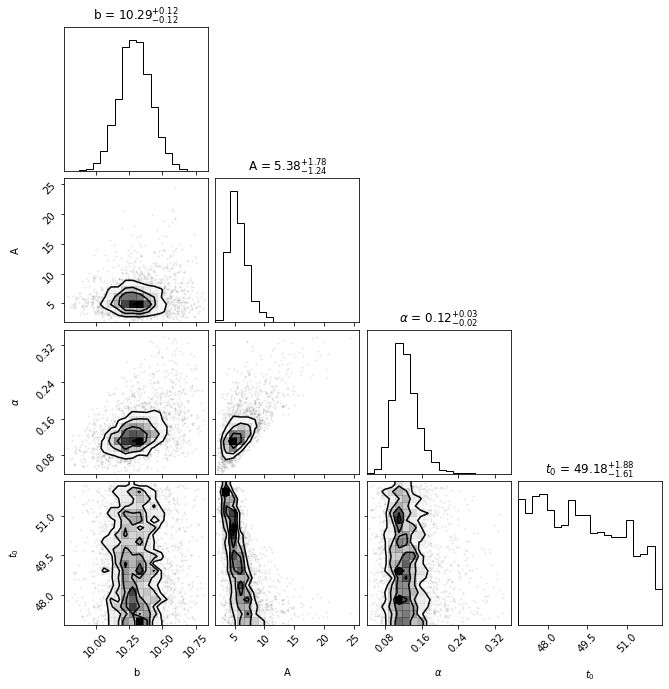

In [232]:
#CLD checking first model by comparing the corner plots of this parameter space with the plots of the above parameter
#CLD MCMC space
cornerplot(result1)

The above plots do look pretty similar, however the ultranest corner plots are a little tighter in parameter space.

In [233]:
result2 = sampler2.run()
sampler2.print_results()

[ultranest] Sampling 400 live points from prior ...


INFO:ultranest:Sampling 400 live points from prior ...
DEBUG:ultranest:run_iter dlogz=0.5, dKL=0.5, frac_remain=0.01, Lepsilon=0.0010, min_ess=400
DEBUG:ultranest:max_iters=-1, max_ncalls=-1, max_num_improvement_loops=-1, min_num_live_points=400, cluster_num_live_points=40
DEBUG:ultranest:minimal_widths_sequence: [(-inf, 400.0), (inf, 400.0)]


DEBUG:ultranest:iteration=0, ncalls=401, logz=-inf, remainder_fraction=100.0000%, Lmin=-273269.44, Lmax=-179.52


DEBUG:ultranest:iteration=40, ncalls=442, logz=-78668.22, remainder_fraction=100.0000%, Lmin=-78567.58, Lmax=-178.99


DEBUG:ultranest:iteration=80, ncalls=487, logz=-66237.45, remainder_fraction=100.0000%, Lmin=-65979.01, Lmax=-178.99


DEBUG:ultranest:iteration=113, ncalls=527, logz=-56688.58, remainder_fraction=100.0000%, Lmin=-56680.62, Lmax=-178.99


DEBUG:ultranest:iteration=120, ncalls=535, logz=-53758.51, remainder_fraction=100.0000%, Lmin=-53327.23, Lmax=-178.99


DEBUG:ultranest:iteration=160, ncalls=593, logz=-40420.47, remainder_fraction=100.0000%, Lmin=-40187.15, Lmax=-178.99


DEBUG:ultranest:iteration=200, ncalls=653, logz=-34374.81, remainder_fraction=100.0000%, Lmin=-34104.54, Lmax=-178.99


DEBUG:ultranest:iteration=240, ncalls=710, logz=-26302.13, remainder_fraction=100.0000%, Lmin=-26142.55, Lmax=-178.99


DEBUG:ultranest:iteration=270, ncalls=750, logz=-21942.06, remainder_fraction=100.0000%, Lmin=-21935.34, Lmax=-178.99


DEBUG:ultranest:iteration=280, ncalls=764, logz=-21353.87, remainder_fraction=100.0000%, Lmin=-21277.38, Lmax=-178.99


DEBUG:ultranest:iteration=320, ncalls=820, logz=-16994.29, remainder_fraction=100.0000%, Lmin=-16855.87, Lmax=-178.99


DEBUG:ultranest:iteration=360, ncalls=891, logz=-13375.76, remainder_fraction=100.0000%, Lmin=-13220.31, Lmax=-178.99


DEBUG:ultranest:iteration=400, ncalls=952, logz=-9836.55, remainder_fraction=100.0000%, Lmin=-9665.96, Lmax=-178.99


DEBUG:ultranest:iteration=440, ncalls=1016, logz=-7817.28, remainder_fraction=100.0000%, Lmin=-7798.34, Lmax=-178.99


DEBUG:ultranest:iteration=480, ncalls=1093, logz=-5960.26, remainder_fraction=100.0000%, Lmin=-5945.67, Lmax=-178.99


DEBUG:ultranest:iteration=520, ncalls=1169, logz=-4931.55, remainder_fraction=100.0000%, Lmin=-4882.80, Lmax=-178.99


DEBUG:ultranest:iteration=540, ncalls=1201, logz=-4490.56, remainder_fraction=100.0000%, Lmin=-4429.42, Lmax=-178.99


DEBUG:ultranest:iteration=560, ncalls=1232, logz=-4101.06, remainder_fraction=100.0000%, Lmin=-4086.77, Lmax=-178.99


DEBUG:ultranest:iteration=600, ncalls=1303, logz=-3516.67, remainder_fraction=100.0000%, Lmin=-3501.00, Lmax=-178.99


DEBUG:ultranest:iteration=640, ncalls=1382, logz=-2930.04, remainder_fraction=100.0000%, Lmin=-2909.01, Lmax=-178.99


DEBUG:ultranest:iteration=680, ncalls=1460, logz=-2515.80, remainder_fraction=100.0000%, Lmin=-2504.08, Lmax=-178.99


DEBUG:ultranest:iteration=720, ncalls=1554, logz=-2243.49, remainder_fraction=100.0000%, Lmin=-2218.05, Lmax=-178.99


DEBUG:ultranest:iteration=760, ncalls=1636, logz=-1959.19, remainder_fraction=100.0000%, Lmin=-1949.05, Lmax=-178.99


DEBUG:ultranest:iteration=800, ncalls=1723, logz=-1735.39, remainder_fraction=100.0000%, Lmin=-1724.48, Lmax=-178.99


DEBUG:ultranest:iteration=810, ncalls=1745, logz=-1691.07, remainder_fraction=100.0000%, Lmin=-1677.99, Lmax=-178.99


DEBUG:ultranest:iteration=840, ncalls=1809, logz=-1532.34, remainder_fraction=100.0000%, Lmin=-1524.13, Lmax=-178.99


DEBUG:ultranest:iteration=880, ncalls=1925, logz=-1324.83, remainder_fraction=100.0000%, Lmin=-1314.40, Lmax=-176.61


DEBUG:ultranest:iteration=920, ncalls=2026, logz=-1158.89, remainder_fraction=100.0000%, Lmin=-1148.80, Lmax=-176.61


DEBUG:ultranest:iteration=960, ncalls=2114, logz=-991.50, remainder_fraction=100.0000%, Lmin=-983.08, Lmax=-176.61


DEBUG:ultranest:iteration=1000, ncalls=2219, logz=-877.04, remainder_fraction=100.0000%, Lmin=-868.68, Lmax=-176.61


DEBUG:ultranest:iteration=1040, ncalls=2356, logz=-763.15, remainder_fraction=100.0000%, Lmin=-749.85, Lmax=-176.61


DEBUG:ultranest:iteration=1080, ncalls=2519, logz=-667.98, remainder_fraction=100.0000%, Lmin=-659.06, Lmax=-176.61


DEBUG:ultranest:iteration=1120, ncalls=2643, logz=-602.15, remainder_fraction=100.0000%, Lmin=-588.98, Lmax=-176.61


DEBUG:ultranest:iteration=1160, ncalls=2780, logz=-542.01, remainder_fraction=100.0000%, Lmin=-531.65, Lmax=-176.61


DEBUG:ultranest:iteration=1200, ncalls=2956, logz=-487.71, remainder_fraction=100.0000%, Lmin=-476.69, Lmax=-176.61


DEBUG:ultranest:iteration=1240, ncalls=3114, logz=-434.87, remainder_fraction=100.0000%, Lmin=-425.90, Lmax=-173.64


DEBUG:ultranest:iteration=1278, ncalls=3283, logz=-395.17, remainder_fraction=100.0000%, Lmin=-385.90, Lmax=-164.52


DEBUG:ultranest:iteration=1280, ncalls=3294, logz=-393.97, remainder_fraction=100.0000%, Lmin=-382.88, Lmax=-164.52


DEBUG:ultranest:iteration=1320, ncalls=3529, logz=-359.04, remainder_fraction=100.0000%, Lmin=-347.40, Lmax=-164.52


DEBUG:ultranest:iteration=1356, ncalls=3716, logz=-333.09, remainder_fraction=100.0000%, Lmin=-323.07, Lmax=-164.52


DEBUG:ultranest:iteration=1360, ncalls=3750, logz=-328.96, remainder_fraction=100.0000%, Lmin=-319.57, Lmax=-164.52


DEBUG:ultranest:iteration=1400, ncalls=3948, logz=-306.32, remainder_fraction=100.0000%, Lmin=-297.79, Lmax=-164.52


DEBUG:ultranest:iteration=1440, ncalls=4237, logz=-290.11, remainder_fraction=100.0000%, Lmin=-281.75, Lmax=-164.52


DEBUG:ultranest:iteration=1480, ncalls=4521, logz=-272.04, remainder_fraction=100.0000%, Lmin=-263.24, Lmax=-164.52


DEBUG:ultranest:iteration=1520, ncalls=4844, logz=-261.87, remainder_fraction=100.0000%, Lmin=-253.66, Lmax=-164.52


DEBUG:ultranest:iteration=1557, ncalls=5058, logz=-247.29, remainder_fraction=100.0000%, Lmin=-238.84, Lmax=-164.52


DEBUG:ultranest:iteration=1560, ncalls=5093, logz=-246.61, remainder_fraction=100.0000%, Lmin=-237.41, Lmax=-164.52


DEBUG:ultranest:iteration=1598, ncalls=5409, logz=-237.71, remainder_fraction=100.0000%, Lmin=-228.98, Lmax=-164.52


DEBUG:ultranest:iteration=1600, ncalls=5424, logz=-237.24, remainder_fraction=100.0000%, Lmin=-228.77, Lmax=-164.52


DEBUG:ultranest:iteration=1626, ncalls=5633, logz=-233.04, remainder_fraction=100.0000%, Lmin=-225.43, Lmax=-164.52


DEBUG:ultranest:iteration=1640, ncalls=5750, logz=-231.13, remainder_fraction=100.0000%, Lmin=-222.66, Lmax=-164.52


DEBUG:ultranest:iteration=1670, ncalls=6079, logz=-226.50, remainder_fraction=100.0000%, Lmin=-218.17, Lmax=-164.52


DEBUG:ultranest:iteration=1680, ncalls=6174, logz=-224.92, remainder_fraction=100.0000%, Lmin=-216.61, Lmax=-164.52


DEBUG:ultranest:iteration=1709, ncalls=6494, logz=-220.04, remainder_fraction=100.0000%, Lmin=-211.82, Lmax=-149.34


DEBUG:ultranest:iteration=1720, ncalls=6685, logz=-218.72, remainder_fraction=100.0000%, Lmin=-210.44, Lmax=-149.34


DEBUG:ultranest:iteration=1755, ncalls=7028, logz=-214.86, remainder_fraction=100.0000%, Lmin=-206.69, Lmax=-149.34


DEBUG:ultranest:iteration=1760, ncalls=7095, logz=-214.15, remainder_fraction=100.0000%, Lmin=-205.50, Lmax=-149.34


DEBUG:ultranest:iteration=1786, ncalls=7431, logz=-210.80, remainder_fraction=100.0000%, Lmin=-202.62, Lmax=-149.34


DEBUG:ultranest:iteration=1800, ncalls=7606, logz=-209.59, remainder_fraction=100.0000%, Lmin=-201.67, Lmax=-149.34


DEBUG:ultranest:iteration=1826, ncalls=7898, logz=-207.69, remainder_fraction=100.0000%, Lmin=-199.73, Lmax=-149.34


DEBUG:ultranest:iteration=1840, ncalls=8217, logz=-206.57, remainder_fraction=100.0000%, Lmin=-198.31, Lmax=-149.34


DEBUG:ultranest:iteration=1860, ncalls=8573, logz=-204.68, remainder_fraction=100.0000%, Lmin=-196.52, Lmax=-149.34


DEBUG:ultranest:iteration=1880, ncalls=8804, logz=-203.36, remainder_fraction=100.0000%, Lmin=-195.23, Lmax=-149.34


DEBUG:ultranest:iteration=1892, ncalls=9029, logz=-202.40, remainder_fraction=100.0000%, Lmin=-194.35, Lmax=-149.34


DEBUG:ultranest:iteration=1907, ncalls=9390, logz=-201.38, remainder_fraction=100.0000%, Lmin=-193.09, Lmax=-149.34


DEBUG:ultranest:iteration=1920, ncalls=9598, logz=-200.41, remainder_fraction=100.0000%, Lmin=-192.09, Lmax=-149.34


DEBUG:ultranest:iteration=1944, ncalls=9916, logz=-198.72, remainder_fraction=100.0000%, Lmin=-190.50, Lmax=-149.34


DEBUG:ultranest:iteration=1958, ncalls=10221, logz=-197.85, remainder_fraction=100.0000%, Lmin=-189.78, Lmax=-149.34


DEBUG:ultranest:iteration=1960, ncalls=10241, logz=-197.73, remainder_fraction=100.0000%, Lmin=-189.69, Lmax=-149.34


DEBUG:ultranest:iteration=1973, ncalls=10567, logz=-196.97, remainder_fraction=100.0000%, Lmin=-188.75, Lmax=-149.34


DEBUG:ultranest:iteration=1981, ncalls=10819, logz=-196.48, remainder_fraction=100.0000%, Lmin=-188.40, Lmax=-149.34


DEBUG:ultranest:iteration=2000, ncalls=11152, logz=-195.44, remainder_fraction=100.0000%, Lmin=-187.44, Lmax=-149.34


DEBUG:ultranest:iteration=2010, ncalls=11511, logz=-194.97, remainder_fraction=100.0000%, Lmin=-187.06, Lmax=-149.34


DEBUG:ultranest:iteration=2020, ncalls=11866, logz=-194.56, remainder_fraction=100.0000%, Lmin=-186.82, Lmax=-149.34


DEBUG:ultranest:iteration=2033, ncalls=12214, logz=-194.09, remainder_fraction=100.0000%, Lmin=-186.34, Lmax=-149.34


DEBUG:ultranest:iteration=2040, ncalls=12428, logz=-193.85, remainder_fraction=100.0000%, Lmin=-186.11, Lmax=-149.34


DEBUG:ultranest:iteration=2054, ncalls=12725, logz=-193.40, remainder_fraction=100.0000%, Lmin=-185.76, Lmax=-149.34


DEBUG:ultranest:iteration=2070, ncalls=13045, logz=-192.94, remainder_fraction=100.0000%, Lmin=-185.28, Lmax=-149.34


DEBUG:ultranest:iteration=2080, ncalls=13357, logz=-192.65, remainder_fraction=100.0000%, Lmin=-184.99, Lmax=-149.34


DEBUG:ultranest:iteration=2096, ncalls=13725, logz=-192.23, remainder_fraction=100.0000%, Lmin=-184.72, Lmax=-149.34


DEBUG:ultranest:iteration=2109, ncalls=14083, logz=-191.92, remainder_fraction=100.0000%, Lmin=-184.39, Lmax=-149.34


DEBUG:ultranest:iteration=2120, ncalls=14348, logz=-191.68, remainder_fraction=100.0000%, Lmin=-184.23, Lmax=-149.34


DEBUG:ultranest:iteration=2133, ncalls=14724, logz=-191.39, remainder_fraction=100.0000%, Lmin=-183.84, Lmax=-149.34


DEBUG:ultranest:iteration=2141, ncalls=15072, logz=-191.21, remainder_fraction=100.0000%, Lmin=-183.61, Lmax=-149.34


DEBUG:ultranest:iteration=2149, ncalls=15453, logz=-191.02, remainder_fraction=100.0000%, Lmin=-183.38, Lmax=-149.34


DEBUG:ultranest:iteration=2158, ncalls=15755, logz=-190.82, remainder_fraction=100.0000%, Lmin=-183.26, Lmax=-149.34


DEBUG:ultranest:iteration=2160, ncalls=15769, logz=-190.77, remainder_fraction=100.0000%, Lmin=-183.24, Lmax=-149.34


DEBUG:ultranest:iteration=2178, ncalls=16110, logz=-190.41, remainder_fraction=100.0000%, Lmin=-182.91, Lmax=-149.34


DEBUG:ultranest:iteration=2190, ncalls=16485, logz=-190.19, remainder_fraction=100.0000%, Lmin=-182.78, Lmax=-149.34


DEBUG:ultranest:iteration=2200, ncalls=16751, logz=-190.01, remainder_fraction=100.0000%, Lmin=-182.49, Lmax=-149.34


DEBUG:ultranest:iteration=2207, ncalls=17077, logz=-189.88, remainder_fraction=100.0000%, Lmin=-182.36, Lmax=-149.34


DEBUG:ultranest:iteration=2217, ncalls=17452, logz=-189.69, remainder_fraction=100.0000%, Lmin=-182.19, Lmax=-149.34


DEBUG:ultranest:iteration=2225, ncalls=17790, logz=-189.56, remainder_fraction=100.0000%, Lmin=-182.04, Lmax=-149.34


DEBUG:ultranest:iteration=2234, ncalls=18121, logz=-189.40, remainder_fraction=100.0000%, Lmin=-181.91, Lmax=-149.34


DEBUG:ultranest:iteration=2240, ncalls=18376, logz=-189.31, remainder_fraction=100.0000%, Lmin=-181.89, Lmax=-149.34


DEBUG:ultranest:iteration=2251, ncalls=18630, logz=-189.14, remainder_fraction=100.0000%, Lmin=-181.74, Lmax=-149.34


DEBUG:ultranest:iteration=2261, ncalls=19133, logz=-189.00, remainder_fraction=100.0000%, Lmin=-181.59, Lmax=-149.34


DEBUG:ultranest:iteration=2269, ncalls=19516, logz=-188.89, remainder_fraction=100.0000%, Lmin=-181.50, Lmax=-149.34


DEBUG:ultranest:iteration=2272, ncalls=19866, logz=-188.85, remainder_fraction=100.0000%, Lmin=-181.46, Lmax=-149.34


DEBUG:ultranest:iteration=2279, ncalls=20302, logz=-188.75, remainder_fraction=100.0000%, Lmin=-181.35, Lmax=-149.34


DEBUG:ultranest:iteration=2280, ncalls=20303, logz=-188.74, remainder_fraction=100.0000%, Lmin=-181.35, Lmax=-149.34


DEBUG:ultranest:iteration=2290, ncalls=20682, logz=-188.60, remainder_fraction=100.0000%, Lmin=-181.21, Lmax=-149.34


DEBUG:ultranest:iteration=2296, ncalls=21001, logz=-188.53, remainder_fraction=100.0000%, Lmin=-181.14, Lmax=-149.34


DEBUG:ultranest:iteration=2303, ncalls=21418, logz=-188.44, remainder_fraction=100.0000%, Lmin=-181.08, Lmax=-149.34


DEBUG:ultranest:iteration=2307, ncalls=21925, logz=-188.39, remainder_fraction=100.0000%, Lmin=-181.04, Lmax=-149.34


DEBUG:ultranest:iteration=2319, ncalls=22383, logz=-188.25, remainder_fraction=100.0000%, Lmin=-180.89, Lmax=-149.34


DEBUG:ultranest:iteration=2320, ncalls=22388, logz=-188.24, remainder_fraction=100.0000%, Lmin=-180.89, Lmax=-149.34


DEBUG:ultranest:iteration=2325, ncalls=22746, logz=-188.18, remainder_fraction=100.0000%, Lmin=-180.83, Lmax=-149.34


DEBUG:ultranest:iteration=2331, ncalls=23138, logz=-188.11, remainder_fraction=100.0000%, Lmin=-180.77, Lmax=-149.34


DEBUG:ultranest:iteration=2340, ncalls=23576, logz=-188.01, remainder_fraction=100.0000%, Lmin=-180.73, Lmax=-149.34


DEBUG:ultranest:iteration=2346, ncalls=23984, logz=-187.95, remainder_fraction=100.0000%, Lmin=-180.67, Lmax=-149.34


DEBUG:ultranest:iteration=2351, ncalls=24415, logz=-187.90, remainder_fraction=100.0000%, Lmin=-180.63, Lmax=-149.34


DEBUG:ultranest:iteration=2357, ncalls=24843, logz=-187.84, remainder_fraction=100.0000%, Lmin=-180.59, Lmax=-149.34


DEBUG:ultranest:iteration=2360, ncalls=24925, logz=-187.81, remainder_fraction=100.0000%, Lmin=-180.53, Lmax=-149.34


DEBUG:ultranest:iteration=2365, ncalls=25239, logz=-187.76, remainder_fraction=100.0000%, Lmin=-180.48, Lmax=-149.34


DEBUG:ultranest:iteration=2373, ncalls=25601, logz=-187.68, remainder_fraction=100.0000%, Lmin=-180.43, Lmax=-149.34


DEBUG:ultranest:iteration=2379, ncalls=26103, logz=-187.63, remainder_fraction=100.0000%, Lmin=-180.38, Lmax=-149.34


DEBUG:ultranest:iteration=2386, ncalls=26385, logz=-187.56, remainder_fraction=100.0000%, Lmin=-180.30, Lmax=-149.34


DEBUG:ultranest:iteration=2389, ncalls=26686, logz=-187.54, remainder_fraction=100.0000%, Lmin=-180.28, Lmax=-149.34


DEBUG:ultranest:iteration=2396, ncalls=27004, logz=-187.48, remainder_fraction=100.0000%, Lmin=-180.22, Lmax=-149.34


DEBUG:ultranest:iteration=2400, ncalls=27179, logz=-187.44, remainder_fraction=100.0000%, Lmin=-180.20, Lmax=-149.34


DEBUG:ultranest:iteration=2408, ncalls=27519, logz=-187.37, remainder_fraction=100.0000%, Lmin=-180.16, Lmax=-149.34


DEBUG:ultranest:iteration=2414, ncalls=27924, logz=-187.32, remainder_fraction=100.0000%, Lmin=-180.11, Lmax=-149.34


DEBUG:ultranest:iteration=2421, ncalls=28294, logz=-187.27, remainder_fraction=100.0000%, Lmin=-180.06, Lmax=-149.34


DEBUG:ultranest:iteration=2429, ncalls=28641, logz=-187.21, remainder_fraction=100.0000%, Lmin=-180.03, Lmax=-149.34


DEBUG:ultranest:iteration=2434, ncalls=28901, logz=-187.17, remainder_fraction=100.0000%, Lmin=-180.01, Lmax=-149.34


DEBUG:ultranest:iteration=2440, ncalls=29223, logz=-187.13, remainder_fraction=100.0000%, Lmin=-179.97, Lmax=-149.34


DEBUG:ultranest:iteration=2446, ncalls=29610, logz=-187.08, remainder_fraction=100.0000%, Lmin=-179.94, Lmax=-149.34


DEBUG:ultranest:iteration=2458, ncalls=29971, logz=-187.00, remainder_fraction=100.0000%, Lmin=-179.90, Lmax=-149.34


DEBUG:ultranest:iteration=2462, ncalls=30314, logz=-186.98, remainder_fraction=100.0000%, Lmin=-179.88, Lmax=-149.34


DEBUG:ultranest:iteration=2469, ncalls=30687, logz=-186.93, remainder_fraction=100.0000%, Lmin=-179.84, Lmax=-149.34


DEBUG:ultranest:iteration=2478, ncalls=31109, logz=-186.88, remainder_fraction=100.0000%, Lmin=-179.78, Lmax=-149.34


DEBUG:ultranest:iteration=2480, ncalls=31185, logz=-186.86, remainder_fraction=100.0000%, Lmin=-179.76, Lmax=-149.34


DEBUG:ultranest:iteration=2485, ncalls=31670, logz=-186.83, remainder_fraction=100.0000%, Lmin=-179.74, Lmax=-149.34


DEBUG:ultranest:iteration=2496, ncalls=32218, logz=-186.77, remainder_fraction=100.0000%, Lmin=-179.70, Lmax=-149.34


DEBUG:ultranest:iteration=2503, ncalls=32564, logz=-186.73, remainder_fraction=100.0000%, Lmin=-179.68, Lmax=-149.34


DEBUG:ultranest:iteration=2508, ncalls=32933, logz=-186.70, remainder_fraction=100.0000%, Lmin=-179.67, Lmax=-149.34


DEBUG:ultranest:iteration=2512, ncalls=33282, logz=-186.68, remainder_fraction=100.0000%, Lmin=-179.65, Lmax=-149.34


DEBUG:ultranest:iteration=2518, ncalls=33688, logz=-186.65, remainder_fraction=100.0000%, Lmin=-179.62, Lmax=-149.34


DEBUG:ultranest:iteration=2520, ncalls=33796, logz=-186.64, remainder_fraction=100.0000%, Lmin=-179.60, Lmax=-149.34


DEBUG:ultranest:iteration=2528, ncalls=34119, logz=-186.60, remainder_fraction=100.0000%, Lmin=-179.59, Lmax=-149.34


DEBUG:ultranest:iteration=2535, ncalls=34480, logz=-186.56, remainder_fraction=100.0000%, Lmin=-179.57, Lmax=-149.34


DEBUG:ultranest:iteration=2539, ncalls=34820, logz=-186.55, remainder_fraction=100.0000%, Lmin=-179.55, Lmax=-149.34


DEBUG:ultranest:iteration=2545, ncalls=35214, logz=-186.52, remainder_fraction=100.0000%, Lmin=-179.53, Lmax=-149.34


DEBUG:ultranest:iteration=2549, ncalls=35635, logz=-186.50, remainder_fraction=100.0000%, Lmin=-179.52, Lmax=-149.34


DEBUG:ultranest:iteration=2557, ncalls=35943, logz=-186.46, remainder_fraction=100.0000%, Lmin=-179.50, Lmax=-149.34


DEBUG:ultranest:iteration=2560, ncalls=36154, logz=-186.45, remainder_fraction=100.0000%, Lmin=-179.49, Lmax=-149.34


DEBUG:ultranest:iteration=2566, ncalls=36462, logz=-186.42, remainder_fraction=100.0000%, Lmin=-179.47, Lmax=-149.34


DEBUG:ultranest:iteration=2571, ncalls=36823, logz=-186.40, remainder_fraction=100.0000%, Lmin=-179.45, Lmax=-149.34


DEBUG:ultranest:iteration=2578, ncalls=37187, logz=-186.37, remainder_fraction=100.0000%, Lmin=-179.42, Lmax=-149.34


DEBUG:ultranest:iteration=2580, ncalls=37526, logz=-186.36, remainder_fraction=100.0000%, Lmin=-179.42, Lmax=-149.34


DEBUG:ultranest:iteration=2584, ncalls=37907, logz=-186.35, remainder_fraction=100.0000%, Lmin=-179.41, Lmax=-149.34


DEBUG:ultranest:iteration=2587, ncalls=38382, logz=-186.34, remainder_fraction=100.0000%, Lmin=-179.40, Lmax=-149.34


DEBUG:ultranest:iteration=2593, ncalls=38938, logz=-186.31, remainder_fraction=100.0000%, Lmin=-179.38, Lmax=-149.34


DEBUG:ultranest:iteration=2596, ncalls=39260, logz=-186.30, remainder_fraction=100.0000%, Lmin=-179.37, Lmax=-149.34


DEBUG:ultranest:iteration=2600, ncalls=39549, logz=-186.29, remainder_fraction=100.0000%, Lmin=-179.37, Lmax=-149.34


DEBUG:ultranest:iteration=2604, ncalls=39950, logz=-186.27, remainder_fraction=100.0000%, Lmin=-179.36, Lmax=-149.34


DEBUG:ultranest:iteration=2610, ncalls=40318, logz=-186.25, remainder_fraction=100.0000%, Lmin=-179.35, Lmax=-149.34


DEBUG:ultranest:iteration=2616, ncalls=40704, logz=-186.23, remainder_fraction=100.0000%, Lmin=-179.33, Lmax=-149.34


DEBUG:ultranest:iteration=2622, ncalls=41172, logz=-186.21, remainder_fraction=100.0000%, Lmin=-179.32, Lmax=-149.34


DEBUG:ultranest:iteration=2628, ncalls=41610, logz=-186.19, remainder_fraction=100.0000%, Lmin=-179.30, Lmax=-149.34


DEBUG:ultranest:iteration=2632, ncalls=41952, logz=-186.17, remainder_fraction=100.0000%, Lmin=-179.29, Lmax=-149.34


DEBUG:ultranest:iteration=2638, ncalls=42393, logz=-186.15, remainder_fraction=100.0000%, Lmin=-179.28, Lmax=-149.34


DEBUG:ultranest:iteration=2640, ncalls=42478, logz=-186.15, remainder_fraction=100.0000%, Lmin=-179.28, Lmax=-149.34


DEBUG:ultranest:iteration=2643, ncalls=42918, logz=-186.14, remainder_fraction=100.0000%, Lmin=-179.27, Lmax=-149.34


DEBUG:ultranest:iteration=2647, ncalls=43216, logz=-186.12, remainder_fraction=100.0000%, Lmin=-179.27, Lmax=-149.34


DEBUG:ultranest:iteration=2654, ncalls=43481, logz=-186.10, remainder_fraction=100.0000%, Lmin=-179.26, Lmax=-149.34


DEBUG:ultranest:iteration=2657, ncalls=44000, logz=-186.09, remainder_fraction=100.0000%, Lmin=-179.25, Lmax=-149.34


DEBUG:ultranest:iteration=2664, ncalls=44554, logz=-186.07, remainder_fraction=100.0000%, Lmin=-179.24, Lmax=-149.34


DEBUG:ultranest:iteration=2668, ncalls=44846, logz=-186.06, remainder_fraction=100.0000%, Lmin=-179.23, Lmax=-149.34


DEBUG:ultranest:iteration=2673, ncalls=45278, logz=-186.04, remainder_fraction=100.0000%, Lmin=-179.21, Lmax=-149.34


DEBUG:ultranest:iteration=2677, ncalls=45959, logz=-186.03, remainder_fraction=100.0000%, Lmin=-179.21, Lmax=-149.34


DEBUG:ultranest:iteration=2680, ncalls=46388, logz=-186.02, remainder_fraction=100.0000%, Lmin=-179.20, Lmax=-149.34


DEBUG:ultranest:iteration=2682, ncalls=46750, logz=-186.02, remainder_fraction=100.0000%, Lmin=-179.20, Lmax=-149.34


DEBUG:ultranest:iteration=2685, ncalls=47202, logz=-186.01, remainder_fraction=100.0000%, Lmin=-179.19, Lmax=-149.34


DEBUG:ultranest:iteration=2689, ncalls=47663, logz=-186.00, remainder_fraction=100.0000%, Lmin=-179.19, Lmax=-149.34


DEBUG:ultranest:iteration=2694, ncalls=48144, logz=-185.99, remainder_fraction=100.0000%, Lmin=-179.19, Lmax=-149.34


DEBUG:ultranest:iteration=2698, ncalls=48555, logz=-185.98, remainder_fraction=100.0000%, Lmin=-179.18, Lmax=-149.34


DEBUG:ultranest:iteration=2700, ncalls=48720, logz=-185.97, remainder_fraction=100.0000%, Lmin=-179.18, Lmax=-149.34


DEBUG:ultranest:iteration=2707, ncalls=49054, logz=-185.95, remainder_fraction=100.0000%, Lmin=-179.17, Lmax=-149.34


DEBUG:ultranest:iteration=2711, ncalls=49461, logz=-185.94, remainder_fraction=100.0000%, Lmin=-179.17, Lmax=-149.34


DEBUG:ultranest:iteration=2717, ncalls=49883, logz=-185.93, remainder_fraction=100.0000%, Lmin=-179.16, Lmax=-149.34


DEBUG:ultranest:iteration=2720, ncalls=50112, logz=-185.92, remainder_fraction=100.0000%, Lmin=-179.16, Lmax=-149.34


DEBUG:ultranest:iteration=2726, ncalls=50654, logz=-185.91, remainder_fraction=100.0000%, Lmin=-179.15, Lmax=-149.34


DEBUG:ultranest:iteration=2729, ncalls=50989, logz=-185.90, remainder_fraction=100.0000%, Lmin=-179.14, Lmax=-149.34


DEBUG:ultranest:iteration=2735, ncalls=51328, logz=-185.88, remainder_fraction=100.0000%, Lmin=-179.14, Lmax=-149.34


DEBUG:ultranest:iteration=2739, ncalls=51735, logz=-185.88, remainder_fraction=100.0000%, Lmin=-179.13, Lmax=-148.20


DEBUG:ultranest:iteration=2741, ncalls=52024, logz=-185.87, remainder_fraction=100.0000%, Lmin=-179.13, Lmax=-148.20


DEBUG:ultranest:iteration=2750, ncalls=52378, logz=-185.85, remainder_fraction=100.0000%, Lmin=-179.12, Lmax=-148.20


DEBUG:ultranest:iteration=2752, ncalls=52724, logz=-185.85, remainder_fraction=100.0000%, Lmin=-179.12, Lmax=-148.20


DEBUG:ultranest:iteration=2754, ncalls=53136, logz=-185.84, remainder_fraction=100.0000%, Lmin=-179.11, Lmax=-148.20


DEBUG:ultranest:iteration=2759, ncalls=53650, logz=-185.83, remainder_fraction=100.0000%, Lmin=-179.11, Lmax=-148.20


DEBUG:ultranest:iteration=2760, ncalls=53712, logz=-185.83, remainder_fraction=100.0000%, Lmin=-179.11, Lmax=-148.20


DEBUG:ultranest:iteration=2764, ncalls=54284, logz=-185.82, remainder_fraction=100.0000%, Lmin=-179.10, Lmax=-148.20


DEBUG:ultranest:iteration=2768, ncalls=54608, logz=-185.81, remainder_fraction=100.0000%, Lmin=-179.10, Lmax=-148.20


DEBUG:ultranest:iteration=2771, ncalls=55009, logz=-185.81, remainder_fraction=100.0000%, Lmin=-179.10, Lmax=-148.20


DEBUG:ultranest:iteration=2778, ncalls=55394, logz=-185.79, remainder_fraction=100.0000%, Lmin=-179.09, Lmax=-148.20


DEBUG:ultranest:iteration=2783, ncalls=55699, logz=-185.78, remainder_fraction=100.0000%, Lmin=-179.09, Lmax=-148.20


DEBUG:ultranest:iteration=2790, ncalls=55927, logz=-185.77, remainder_fraction=100.0000%, Lmin=-179.08, Lmax=-148.20


DEBUG:ultranest:iteration=2792, ncalls=56349, logz=-185.77, remainder_fraction=100.0000%, Lmin=-179.08, Lmax=-148.20


DEBUG:ultranest:iteration=2797, ncalls=56727, logz=-185.76, remainder_fraction=100.0000%, Lmin=-179.08, Lmax=-148.20


DEBUG:ultranest:iteration=2800, ncalls=56914, logz=-185.75, remainder_fraction=100.0000%, Lmin=-179.08, Lmax=-148.20


DEBUG:ultranest:iteration=2803, ncalls=57291, logz=-185.75, remainder_fraction=100.0000%, Lmin=-179.08, Lmax=-148.20


DEBUG:ultranest:iteration=2806, ncalls=57603, logz=-185.74, remainder_fraction=100.0000%, Lmin=-179.07, Lmax=-148.20


DEBUG:ultranest:iteration=2807, ncalls=57926, logz=-185.74, remainder_fraction=100.0000%, Lmin=-179.07, Lmax=-148.20


DEBUG:ultranest:iteration=2813, ncalls=58309, logz=-185.73, remainder_fraction=100.0000%, Lmin=-179.07, Lmax=-148.20


DEBUG:ultranest:iteration=2816, ncalls=58817, logz=-185.72, remainder_fraction=100.0000%, Lmin=-179.07, Lmax=-148.20


DEBUG:ultranest:iteration=2820, ncalls=59112, logz=-185.72, remainder_fraction=100.0000%, Lmin=-179.07, Lmax=-148.20


DEBUG:ultranest:iteration=2824, ncalls=59438, logz=-185.71, remainder_fraction=100.0000%, Lmin=-179.06, Lmax=-148.20


DEBUG:ultranest:iteration=2827, ncalls=59754, logz=-185.71, remainder_fraction=100.0000%, Lmin=-179.06, Lmax=-148.20


DEBUG:ultranest:iteration=2831, ncalls=60426, logz=-185.70, remainder_fraction=100.0000%, Lmin=-179.06, Lmax=-148.20


DEBUG:ultranest:iteration=2833, ncalls=60766, logz=-185.70, remainder_fraction=100.0000%, Lmin=-179.06, Lmax=-148.20


DEBUG:ultranest:iteration=2837, ncalls=61397, logz=-185.69, remainder_fraction=100.0000%, Lmin=-179.05, Lmax=-148.20


DEBUG:ultranest:iteration=2840, ncalls=61812, logz=-185.68, remainder_fraction=100.0000%, Lmin=-179.05, Lmax=-148.20


DEBUG:ultranest:iteration=2842, ncalls=62209, logz=-185.68, remainder_fraction=100.0000%, Lmin=-179.05, Lmax=-148.20


DEBUG:ultranest:iteration=2845, ncalls=62663, logz=-185.68, remainder_fraction=100.0000%, Lmin=-179.05, Lmax=-148.20


DEBUG:ultranest:iteration=2847, ncalls=63026, logz=-185.67, remainder_fraction=100.0000%, Lmin=-179.05, Lmax=-148.20


DEBUG:ultranest:iteration=2851, ncalls=63292, logz=-185.67, remainder_fraction=100.0000%, Lmin=-179.05, Lmax=-148.20


DEBUG:ultranest:iteration=2856, ncalls=63641, logz=-185.66, remainder_fraction=100.0000%, Lmin=-179.05, Lmax=-148.20


DEBUG:ultranest:iteration=2858, ncalls=64058, logz=-185.66, remainder_fraction=100.0000%, Lmin=-179.05, Lmax=-148.20


DEBUG:ultranest:iteration=2862, ncalls=64491, logz=-185.65, remainder_fraction=100.0000%, Lmin=-179.04, Lmax=-148.20


DEBUG:ultranest:iteration=2865, ncalls=64830, logz=-185.65, remainder_fraction=100.0000%, Lmin=-179.04, Lmax=-148.20


DEBUG:ultranest:iteration=2870, ncalls=65233, logz=-185.64, remainder_fraction=100.0000%, Lmin=-179.04, Lmax=-148.20


DEBUG:ultranest:iteration=2876, ncalls=65766, logz=-185.63, remainder_fraction=100.0000%, Lmin=-179.04, Lmax=-148.20


DEBUG:ultranest:iteration=2877, ncalls=66088, logz=-185.63, remainder_fraction=100.0000%, Lmin=-179.03, Lmax=-148.20


DEBUG:ultranest:iteration=2880, ncalls=66365, logz=-185.63, remainder_fraction=100.0000%, Lmin=-179.03, Lmax=-148.20


DEBUG:ultranest:iteration=2883, ncalls=66781, logz=-185.62, remainder_fraction=100.0000%, Lmin=-179.03, Lmax=-148.20


DEBUG:ultranest:iteration=2890, ncalls=67323, logz=-185.61, remainder_fraction=100.0000%, Lmin=-179.03, Lmax=-148.20


DEBUG:ultranest:iteration=2893, ncalls=67577, logz=-185.61, remainder_fraction=100.0000%, Lmin=-179.03, Lmax=-148.20


DEBUG:ultranest:iteration=2894, ncalls=68138, logz=-185.61, remainder_fraction=100.0000%, Lmin=-179.03, Lmax=-148.20


DEBUG:ultranest:iteration=2896, ncalls=68406, logz=-185.61, remainder_fraction=100.0000%, Lmin=-179.03, Lmax=-148.20


DEBUG:ultranest:iteration=2898, ncalls=68690, logz=-185.60, remainder_fraction=100.0000%, Lmin=-179.03, Lmax=-148.20


DEBUG:ultranest:iteration=2900, ncalls=68969, logz=-185.60, remainder_fraction=100.0000%, Lmin=-179.03, Lmax=-148.20


DEBUG:ultranest:iteration=2904, ncalls=69437, logz=-185.60, remainder_fraction=100.0000%, Lmin=-179.03, Lmax=-148.20


DEBUG:ultranest:iteration=2906, ncalls=69719, logz=-185.59, remainder_fraction=100.0000%, Lmin=-179.02, Lmax=-148.20


DEBUG:ultranest:iteration=2911, ncalls=70011, logz=-185.59, remainder_fraction=100.0000%, Lmin=-179.02, Lmax=-148.20


DEBUG:ultranest:iteration=2917, ncalls=70431, logz=-185.58, remainder_fraction=100.0000%, Lmin=-179.02, Lmax=-148.20


DEBUG:ultranest:iteration=2920, ncalls=70772, logz=-185.58, remainder_fraction=100.0000%, Lmin=-179.02, Lmax=-148.20


DEBUG:ultranest:iteration=2924, ncalls=71152, logz=-185.57, remainder_fraction=100.0000%, Lmin=-179.02, Lmax=-148.20


DEBUG:ultranest:iteration=2928, ncalls=71501, logz=-185.57, remainder_fraction=100.0000%, Lmin=-179.02, Lmax=-148.20


DEBUG:ultranest:iteration=2929, ncalls=71905, logz=-185.57, remainder_fraction=100.0000%, Lmin=-179.02, Lmax=-148.20


DEBUG:ultranest:iteration=2932, ncalls=72468, logz=-185.56, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-148.20


DEBUG:ultranest:iteration=2934, ncalls=72962, logz=-185.56, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-148.20


DEBUG:ultranest:iteration=2938, ncalls=73445, logz=-185.55, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-148.20


DEBUG:ultranest:iteration=2940, ncalls=73763, logz=-185.55, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-148.20


DEBUG:ultranest:iteration=2944, ncalls=74161, logz=-185.55, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-148.20


DEBUG:ultranest:iteration=2946, ncalls=74489, logz=-185.55, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-148.20


DEBUG:ultranest:iteration=2952, ncalls=74911, logz=-185.54, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-148.20


DEBUG:ultranest:iteration=2955, ncalls=75272, logz=-185.54, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-148.20


DEBUG:ultranest:iteration=2956, ncalls=75663, logz=-185.54, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-148.20


DEBUG:ultranest:iteration=2958, ncalls=75902, logz=-185.53, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-148.20


DEBUG:ultranest:iteration=2960, ncalls=76029, logz=-185.53, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-148.20


DEBUG:ultranest:iteration=2962, ncalls=76297, logz=-185.53, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-148.20


DEBUG:ultranest:iteration=2965, ncalls=76712, logz=-185.53, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-148.20


DEBUG:ultranest:iteration=2968, ncalls=77029, logz=-185.52, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-148.20


DEBUG:ultranest:iteration=2972, ncalls=77575, logz=-185.52, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-148.20


DEBUG:ultranest:iteration=2976, ncalls=77884, logz=-185.51, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-148.20


DEBUG:ultranest:iteration=2981, ncalls=78733, logz=-185.51, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-148.20


DEBUG:ultranest:iteration=2983, ncalls=79023, logz=-185.51, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-148.20


DEBUG:ultranest:iteration=2988, ncalls=79403, logz=-185.50, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-148.20


DEBUG:ultranest:iteration=2992, ncalls=79781, logz=-185.50, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-148.20


DEBUG:ultranest:iteration=2994, ncalls=80242, logz=-185.50, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-148.20


DEBUG:ultranest:iteration=2999, ncalls=81532, logz=-185.49, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-148.20


DEBUG:ultranest:iteration=3000, ncalls=81538, logz=-185.49, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-148.20


DEBUG:ultranest:iteration=3002, ncalls=82043, logz=-185.49, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-148.20


DEBUG:ultranest:iteration=3006, ncalls=82372, logz=-185.49, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-148.20


DEBUG:ultranest:iteration=3010, ncalls=82643, logz=-185.48, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-148.20


DEBUG:ultranest:iteration=3013, ncalls=83163, logz=-185.48, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-148.20


DEBUG:ultranest:iteration=3014, ncalls=83527, logz=-185.48, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-148.20


DEBUG:ultranest:iteration=3015, ncalls=83942, logz=-185.48, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-148.20


DEBUG:ultranest:iteration=3017, ncalls=84445, logz=-185.48, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-148.20


DEBUG:ultranest:iteration=3019, ncalls=84803, logz=-185.48, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-148.20


DEBUG:ultranest:iteration=3024, ncalls=85396, logz=-185.47, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-148.20


DEBUG:ultranest:iteration=3029, ncalls=85884, logz=-185.47, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-148.20


DEBUG:ultranest:iteration=3031, ncalls=86178, logz=-185.46, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-148.20


DEBUG:ultranest:iteration=3032, ncalls=86682, logz=-185.46, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-148.20


DEBUG:ultranest:iteration=3035, ncalls=86920, logz=-185.46, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-148.20


DEBUG:ultranest:iteration=3036, ncalls=87546, logz=-185.46, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-148.20


DEBUG:ultranest:iteration=3038, ncalls=87940, logz=-185.46, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-148.20


DEBUG:ultranest:iteration=3040, ncalls=87971, logz=-185.46, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-148.20


DEBUG:ultranest:iteration=3044, ncalls=88455, logz=-185.45, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-148.20


DEBUG:ultranest:iteration=3047, ncalls=88747, logz=-185.45, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-148.20


DEBUG:ultranest:iteration=3051, ncalls=89028, logz=-185.45, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-148.20


DEBUG:ultranest:iteration=3057, ncalls=89620, logz=-185.44, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-148.20


DEBUG:ultranest:iteration=3058, ncalls=89913, logz=-185.44, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-148.20


DEBUG:ultranest:iteration=3061, ncalls=90309, logz=-185.44, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-148.20


DEBUG:ultranest:iteration=3066, ncalls=90687, logz=-185.44, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-148.20


DEBUG:ultranest:iteration=3067, ncalls=91003, logz=-185.44, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-148.20


DEBUG:ultranest:iteration=3069, ncalls=91259, logz=-185.44, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-148.20


DEBUG:ultranest:iteration=3072, ncalls=91660, logz=-185.43, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-148.20


DEBUG:ultranest:iteration=3074, ncalls=92183, logz=-185.43, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-148.20


DEBUG:ultranest:iteration=3075, ncalls=92528, logz=-185.43, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-148.20


DEBUG:ultranest:iteration=3077, ncalls=92946, logz=-185.43, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-148.20


DEBUG:ultranest:iteration=3080, ncalls=93191, logz=-185.43, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-148.20


DEBUG:ultranest:iteration=3085, ncalls=93489, logz=-185.42, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-148.20


DEBUG:ultranest:iteration=3088, ncalls=93790, logz=-185.42, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-148.20


DEBUG:ultranest:iteration=3093, ncalls=94359, logz=-185.42, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-148.20


DEBUG:ultranest:iteration=3096, ncalls=94638, logz=-185.42, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-148.20


DEBUG:ultranest:iteration=3097, ncalls=95387, logz=-185.42, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-148.20


DEBUG:ultranest:iteration=3099, ncalls=95933, logz=-185.41, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-148.20


DEBUG:ultranest:iteration=3101, ncalls=96298, logz=-185.41, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-148.20


DEBUG:ultranest:iteration=3105, ncalls=96746, logz=-185.41, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-148.20


DEBUG:ultranest:iteration=3107, ncalls=97713, logz=-185.41, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-148.20


DEBUG:ultranest:iteration=3112, ncalls=98444, logz=-185.41, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-148.20


DEBUG:ultranest:iteration=3113, ncalls=98728, logz=-185.41, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-148.20


DEBUG:ultranest:iteration=3114, ncalls=99096, logz=-185.40, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-148.20


DEBUG:ultranest:iteration=3116, ncalls=99405, logz=-185.40, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-148.20


DEBUG:ultranest:iteration=3119, ncalls=99713, logz=-185.40, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-148.20


DEBUG:ultranest:iteration=3120, ncalls=99875, logz=-185.40, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-148.20


DEBUG:ultranest:iteration=3121, ncalls=101170, logz=-185.40, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-148.20


DEBUG:ultranest:iteration=3123, ncalls=102107, logz=-185.40, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-148.20


DEBUG:ultranest:iteration=3125, ncalls=102779, logz=-185.40, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-148.20


DEBUG:ultranest:iteration=3126, ncalls=103288, logz=-185.40, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-148.20


DEBUG:ultranest:iteration=3127, ncalls=103751, logz=-185.40, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-148.20


DEBUG:ultranest:iteration=3129, ncalls=104453, logz=-185.40, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-148.20


DEBUG:ultranest:iteration=3130, ncalls=104943, logz=-185.39, remainder_fraction=100.0000%, Lmin=-178.97, Lmax=-148.20


DEBUG:ultranest:iteration=3133, ncalls=105847, logz=-185.39, remainder_fraction=100.0000%, Lmin=-178.97, Lmax=-148.20


DEBUG:ultranest:iteration=3136, ncalls=106205, logz=-185.39, remainder_fraction=100.0000%, Lmin=-178.95, Lmax=-148.20


DEBUG:ultranest:iteration=3137, ncalls=106824, logz=-185.39, remainder_fraction=100.0000%, Lmin=-178.95, Lmax=-148.20


DEBUG:ultranest:iteration=3139, ncalls=107210, logz=-185.39, remainder_fraction=100.0000%, Lmin=-178.94, Lmax=-148.20


DEBUG:ultranest:iteration=3140, ncalls=107644, logz=-185.39, remainder_fraction=100.0000%, Lmin=-178.94, Lmax=-148.20


DEBUG:ultranest:iteration=3145, ncalls=107990, logz=-185.39, remainder_fraction=100.0000%, Lmin=-178.89, Lmax=-148.20
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2]), array([399,   1]))


DEBUG:ultranest:iteration=3150, ncalls=108309, logz=-185.38, remainder_fraction=100.0000%, Lmin=-178.88, Lmax=-148.20


DEBUG:ultranest:iteration=3152, ncalls=108722, logz=-185.38, remainder_fraction=100.0000%, Lmin=-178.86, Lmax=-148.20


DEBUG:ultranest:iteration=3153, ncalls=109373, logz=-185.38, remainder_fraction=100.0000%, Lmin=-178.86, Lmax=-148.20


DEBUG:ultranest:iteration=3156, ncalls=109648, logz=-185.38, remainder_fraction=100.0000%, Lmin=-178.85, Lmax=-148.20


DEBUG:ultranest:iteration=3159, ncalls=109995, logz=-185.38, remainder_fraction=100.0000%, Lmin=-178.83, Lmax=-148.20


DEBUG:ultranest:iteration=3160, ncalls=110131, logz=-185.38, remainder_fraction=100.0000%, Lmin=-178.83, Lmax=-148.20


DEBUG:ultranest:iteration=3163, ncalls=110667, logz=-185.37, remainder_fraction=100.0000%, Lmin=-178.82, Lmax=-148.20


DEBUG:ultranest:iteration=3165, ncalls=111099, logz=-185.37, remainder_fraction=100.0000%, Lmin=-178.81, Lmax=-148.20


DEBUG:ultranest:iteration=3169, ncalls=111404, logz=-185.37, remainder_fraction=100.0000%, Lmin=-178.78, Lmax=-148.20


DEBUG:ultranest:iteration=3173, ncalls=111799, logz=-185.37, remainder_fraction=100.0000%, Lmin=-178.76, Lmax=-148.20


DEBUG:ultranest:iteration=3175, ncalls=112182, logz=-185.37, remainder_fraction=100.0000%, Lmin=-178.74, Lmax=-148.20


DEBUG:ultranest:iteration=3178, ncalls=112433, logz=-185.36, remainder_fraction=100.0000%, Lmin=-178.71, Lmax=-148.20


DEBUG:ultranest:iteration=3179, ncalls=113138, logz=-185.36, remainder_fraction=100.0000%, Lmin=-178.69, Lmax=-148.20


DEBUG:ultranest:iteration=3180, ncalls=113872, logz=-185.36, remainder_fraction=100.0000%, Lmin=-178.68, Lmax=-148.20


DEBUG:ultranest:iteration=3184, ncalls=114381, logz=-185.36, remainder_fraction=100.0000%, Lmin=-178.67, Lmax=-148.20


DEBUG:ultranest:iteration=3186, ncalls=115112, logz=-185.36, remainder_fraction=100.0000%, Lmin=-178.67, Lmax=-148.20


DEBUG:ultranest:iteration=3188, ncalls=115989, logz=-185.36, remainder_fraction=100.0000%, Lmin=-178.64, Lmax=-148.20


DEBUG:ultranest:iteration=3189, ncalls=116295, logz=-185.36, remainder_fraction=100.0000%, Lmin=-178.63, Lmax=-148.20


DEBUG:ultranest:iteration=3193, ncalls=116604, logz=-185.35, remainder_fraction=100.0000%, Lmin=-178.55, Lmax=-148.20


DEBUG:ultranest:iteration=3195, ncalls=117137, logz=-185.35, remainder_fraction=100.0000%, Lmin=-178.53, Lmax=-148.20


DEBUG:ultranest:iteration=3199, ncalls=117701, logz=-185.35, remainder_fraction=100.0000%, Lmin=-178.47, Lmax=-148.20


DEBUG:ultranest:iteration=3200, ncalls=118066, logz=-185.35, remainder_fraction=100.0000%, Lmin=-178.47, Lmax=-148.20


DEBUG:ultranest:iteration=3203, ncalls=118382, logz=-185.35, remainder_fraction=100.0000%, Lmin=-178.45, Lmax=-148.20


DEBUG:ultranest:iteration=3206, ncalls=118874, logz=-185.34, remainder_fraction=100.0000%, Lmin=-178.45, Lmax=-148.20


DEBUG:ultranest:iteration=3207, ncalls=119138, logz=-185.34, remainder_fraction=100.0000%, Lmin=-178.45, Lmax=-148.20


DEBUG:ultranest:iteration=3209, ncalls=119635, logz=-185.34, remainder_fraction=100.0000%, Lmin=-178.43, Lmax=-148.20


DEBUG:ultranest:iteration=3211, ncalls=120082, logz=-185.34, remainder_fraction=100.0000%, Lmin=-178.43, Lmax=-148.20


DEBUG:ultranest:iteration=3214, ncalls=120540, logz=-185.34, remainder_fraction=100.0000%, Lmin=-178.40, Lmax=-148.20


DEBUG:ultranest:iteration=3215, ncalls=121209, logz=-185.34, remainder_fraction=100.0000%, Lmin=-178.39, Lmax=-148.20


DEBUG:ultranest:iteration=3216, ncalls=121620, logz=-185.33, remainder_fraction=100.0000%, Lmin=-178.39, Lmax=-148.20


DEBUG:ultranest:iteration=3219, ncalls=121957, logz=-185.33, remainder_fraction=100.0000%, Lmin=-178.36, Lmax=-148.20


DEBUG:ultranest:iteration=3221, ncalls=122372, logz=-185.33, remainder_fraction=100.0000%, Lmin=-178.35, Lmax=-148.20


DEBUG:ultranest:iteration=3222, ncalls=122674, logz=-185.33, remainder_fraction=100.0000%, Lmin=-178.34, Lmax=-148.20


DEBUG:ultranest:iteration=3226, ncalls=123040, logz=-185.33, remainder_fraction=100.0000%, Lmin=-178.28, Lmax=-148.20


DEBUG:ultranest:iteration=3230, ncalls=123457, logz=-185.32, remainder_fraction=100.0000%, Lmin=-178.24, Lmax=-148.20


DEBUG:ultranest:iteration=3231, ncalls=123728, logz=-185.32, remainder_fraction=100.0000%, Lmin=-178.22, Lmax=-148.20


DEBUG:ultranest:iteration=3235, ncalls=124024, logz=-185.32, remainder_fraction=100.0000%, Lmin=-178.16, Lmax=-148.20


DEBUG:ultranest:iteration=3240, ncalls=124442, logz=-185.31, remainder_fraction=100.0000%, Lmin=-178.06, Lmax=-148.20


DEBUG:ultranest:iteration=3243, ncalls=125145, logz=-185.31, remainder_fraction=100.0000%, Lmin=-178.03, Lmax=-148.20


DEBUG:ultranest:iteration=3244, ncalls=126616, logz=-185.31, remainder_fraction=100.0000%, Lmin=-178.02, Lmax=-148.20


DEBUG:ultranest:iteration=3245, ncalls=127177, logz=-185.31, remainder_fraction=100.0000%, Lmin=-178.01, Lmax=-148.20


DEBUG:ultranest:iteration=3248, ncalls=127768, logz=-185.30, remainder_fraction=100.0000%, Lmin=-177.98, Lmax=-148.20


DEBUG:ultranest:iteration=3249, ncalls=128100, logz=-185.30, remainder_fraction=100.0000%, Lmin=-177.93, Lmax=-148.20


DEBUG:ultranest:iteration=3250, ncalls=128659, logz=-185.30, remainder_fraction=100.0000%, Lmin=-177.93, Lmax=-148.20


DEBUG:ultranest:iteration=3252, ncalls=129158, logz=-185.30, remainder_fraction=100.0000%, Lmin=-177.92, Lmax=-148.20


DEBUG:ultranest:iteration=3253, ncalls=129471, logz=-185.30, remainder_fraction=100.0000%, Lmin=-177.92, Lmax=-148.20


DEBUG:ultranest:iteration=3254, ncalls=129800, logz=-185.30, remainder_fraction=100.0000%, Lmin=-177.91, Lmax=-148.20


DEBUG:ultranest:iteration=3259, ncalls=130278, logz=-185.29, remainder_fraction=100.0000%, Lmin=-177.88, Lmax=-148.20


DEBUG:ultranest:iteration=3261, ncalls=130894, logz=-185.29, remainder_fraction=100.0000%, Lmin=-177.83, Lmax=-148.20


DEBUG:ultranest:iteration=3263, ncalls=131811, logz=-185.29, remainder_fraction=100.0000%, Lmin=-177.80, Lmax=-148.20


DEBUG:ultranest:iteration=3264, ncalls=132130, logz=-185.28, remainder_fraction=100.0000%, Lmin=-177.79, Lmax=-148.20


DEBUG:ultranest:iteration=3267, ncalls=132520, logz=-185.28, remainder_fraction=100.0000%, Lmin=-177.76, Lmax=-148.20


DEBUG:ultranest:iteration=3269, ncalls=133008, logz=-185.28, remainder_fraction=100.0000%, Lmin=-177.70, Lmax=-148.20


DEBUG:ultranest:iteration=3271, ncalls=133574, logz=-185.28, remainder_fraction=100.0000%, Lmin=-177.69, Lmax=-148.20


DEBUG:ultranest:iteration=3274, ncalls=133977, logz=-185.27, remainder_fraction=100.0000%, Lmin=-177.65, Lmax=-148.20


DEBUG:ultranest:iteration=3277, ncalls=134389, logz=-185.27, remainder_fraction=100.0000%, Lmin=-177.63, Lmax=-148.20


DEBUG:ultranest:iteration=3278, ncalls=134895, logz=-185.27, remainder_fraction=100.0000%, Lmin=-177.62, Lmax=-148.20


DEBUG:ultranest:iteration=3279, ncalls=135403, logz=-185.26, remainder_fraction=100.0000%, Lmin=-177.56, Lmax=-148.20


DEBUG:ultranest:iteration=3280, ncalls=135509, logz=-185.26, remainder_fraction=100.0000%, Lmin=-177.53, Lmax=-148.20


DEBUG:ultranest:iteration=3282, ncalls=135915, logz=-185.26, remainder_fraction=100.0000%, Lmin=-177.49, Lmax=-148.20


DEBUG:ultranest:iteration=3286, ncalls=136233, logz=-185.25, remainder_fraction=100.0000%, Lmin=-177.46, Lmax=-148.20


DEBUG:ultranest:iteration=3288, ncalls=136768, logz=-185.25, remainder_fraction=100.0000%, Lmin=-177.44, Lmax=-148.20


DEBUG:ultranest:iteration=3289, ncalls=137157, logz=-185.25, remainder_fraction=100.0000%, Lmin=-177.43, Lmax=-148.20


DEBUG:ultranest:iteration=3290, ncalls=137487, logz=-185.25, remainder_fraction=100.0000%, Lmin=-177.40, Lmax=-148.20


DEBUG:ultranest:iteration=3292, ncalls=137977, logz=-185.24, remainder_fraction=100.0000%, Lmin=-177.36, Lmax=-148.20


DEBUG:ultranest:iteration=3295, ncalls=138280, logz=-185.24, remainder_fraction=100.0000%, Lmin=-177.29, Lmax=-148.20


DEBUG:ultranest:iteration=3299, ncalls=138735, logz=-185.23, remainder_fraction=100.0000%, Lmin=-177.24, Lmax=-148.20


DEBUG:ultranest:iteration=3302, ncalls=139048, logz=-185.22, remainder_fraction=100.0000%, Lmin=-177.20, Lmax=-148.20


DEBUG:ultranest:iteration=3305, ncalls=139798, logz=-185.22, remainder_fraction=100.0000%, Lmin=-177.14, Lmax=-148.20


DEBUG:ultranest:iteration=3306, ncalls=140522, logz=-185.22, remainder_fraction=100.0000%, Lmin=-177.12, Lmax=-148.20


DEBUG:ultranest:iteration=3308, ncalls=140894, logz=-185.21, remainder_fraction=100.0000%, Lmin=-177.07, Lmax=-148.20


DEBUG:ultranest:iteration=3311, ncalls=141169, logz=-185.21, remainder_fraction=100.0000%, Lmin=-177.05, Lmax=-148.20


DEBUG:ultranest:iteration=3313, ncalls=141460, logz=-185.20, remainder_fraction=100.0000%, Lmin=-177.00, Lmax=-148.20


DEBUG:ultranest:iteration=3314, ncalls=141943, logz=-185.20, remainder_fraction=100.0000%, Lmin=-176.98, Lmax=-148.20


DEBUG:ultranest:iteration=3316, ncalls=142472, logz=-185.19, remainder_fraction=100.0000%, Lmin=-176.93, Lmax=-148.20


DEBUG:ultranest:iteration=3318, ncalls=142792, logz=-185.19, remainder_fraction=100.0000%, Lmin=-176.87, Lmax=-148.20


DEBUG:ultranest:iteration=3320, ncalls=143277, logz=-185.18, remainder_fraction=100.0000%, Lmin=-176.84, Lmax=-148.20


DEBUG:ultranest:iteration=3321, ncalls=143523, logz=-185.18, remainder_fraction=100.0000%, Lmin=-176.81, Lmax=-148.20


DEBUG:ultranest:iteration=3323, ncalls=144117, logz=-185.18, remainder_fraction=100.0000%, Lmin=-176.77, Lmax=-148.20


DEBUG:ultranest:iteration=3324, ncalls=144762, logz=-185.17, remainder_fraction=100.0000%, Lmin=-176.77, Lmax=-148.20


DEBUG:ultranest:iteration=3326, ncalls=145455, logz=-185.17, remainder_fraction=100.0000%, Lmin=-176.70, Lmax=-148.20


DEBUG:ultranest:iteration=3330, ncalls=145965, logz=-185.16, remainder_fraction=100.0000%, Lmin=-176.66, Lmax=-148.20


DEBUG:ultranest:iteration=3334, ncalls=146307, logz=-185.14, remainder_fraction=100.0000%, Lmin=-176.61, Lmax=-148.20


DEBUG:ultranest:iteration=3337, ncalls=146649, logz=-185.13, remainder_fraction=100.0000%, Lmin=-176.53, Lmax=-148.20


DEBUG:ultranest:iteration=3339, ncalls=147041, logz=-185.13, remainder_fraction=100.0000%, Lmin=-176.52, Lmax=-148.20


DEBUG:ultranest:iteration=3340, ncalls=147366, logz=-185.12, remainder_fraction=100.0000%, Lmin=-176.52, Lmax=-148.20


DEBUG:ultranest:iteration=3341, ncalls=147674, logz=-185.12, remainder_fraction=100.0000%, Lmin=-176.51, Lmax=-148.20


DEBUG:ultranest:iteration=3344, ncalls=148010, logz=-185.11, remainder_fraction=100.0000%, Lmin=-176.49, Lmax=-148.20


DEBUG:ultranest:iteration=3347, ncalls=148425, logz=-185.10, remainder_fraction=100.0000%, Lmin=-176.46, Lmax=-148.20


DEBUG:ultranest:iteration=3348, ncalls=148862, logz=-185.10, remainder_fraction=100.0000%, Lmin=-176.42, Lmax=-148.20


DEBUG:ultranest:iteration=3350, ncalls=149349, logz=-185.09, remainder_fraction=100.0000%, Lmin=-176.40, Lmax=-148.20


DEBUG:ultranest:iteration=3353, ncalls=149825, logz=-185.08, remainder_fraction=100.0000%, Lmin=-176.38, Lmax=-148.20


DEBUG:ultranest:iteration=3355, ncalls=150366, logz=-185.07, remainder_fraction=100.0000%, Lmin=-176.34, Lmax=-148.20


DEBUG:ultranest:iteration=3358, ncalls=150654, logz=-185.06, remainder_fraction=100.0000%, Lmin=-176.31, Lmax=-148.20


DEBUG:ultranest:iteration=3360, ncalls=151349, logz=-185.06, remainder_fraction=100.0000%, Lmin=-176.30, Lmax=-148.20


DEBUG:ultranest:iteration=3363, ncalls=151638, logz=-185.05, remainder_fraction=100.0000%, Lmin=-176.28, Lmax=-148.20


DEBUG:ultranest:iteration=3366, ncalls=152283, logz=-185.04, remainder_fraction=100.0000%, Lmin=-176.14, Lmax=-148.20


DEBUG:ultranest:iteration=3368, ncalls=152547, logz=-185.03, remainder_fraction=100.0000%, Lmin=-176.12, Lmax=-148.20


DEBUG:ultranest:iteration=3369, ncalls=152926, logz=-185.02, remainder_fraction=100.0000%, Lmin=-176.11, Lmax=-148.20


DEBUG:ultranest:iteration=3371, ncalls=153464, logz=-185.01, remainder_fraction=100.0000%, Lmin=-176.09, Lmax=-148.20


DEBUG:ultranest:iteration=3374, ncalls=153787, logz=-185.00, remainder_fraction=100.0000%, Lmin=-176.05, Lmax=-148.20


DEBUG:ultranest:iteration=3377, ncalls=154079, logz=-184.99, remainder_fraction=100.0000%, Lmin=-176.02, Lmax=-148.20


DEBUG:ultranest:iteration=3380, ncalls=154429, logz=-184.98, remainder_fraction=100.0000%, Lmin=-175.95, Lmax=-148.20


DEBUG:ultranest:iteration=3381, ncalls=154735, logz=-184.97, remainder_fraction=100.0000%, Lmin=-175.93, Lmax=-148.20


DEBUG:ultranest:iteration=3383, ncalls=155278, logz=-184.96, remainder_fraction=100.0000%, Lmin=-175.89, Lmax=-148.20


DEBUG:ultranest:iteration=3385, ncalls=155615, logz=-184.95, remainder_fraction=100.0000%, Lmin=-175.85, Lmax=-148.20


DEBUG:ultranest:iteration=3386, ncalls=156091, logz=-184.95, remainder_fraction=100.0000%, Lmin=-175.81, Lmax=-148.20


DEBUG:ultranest:iteration=3388, ncalls=156545, logz=-184.94, remainder_fraction=100.0000%, Lmin=-175.76, Lmax=-148.20


DEBUG:ultranest:iteration=3389, ncalls=157092, logz=-184.93, remainder_fraction=100.0000%, Lmin=-175.74, Lmax=-148.20


DEBUG:ultranest:iteration=3391, ncalls=157548, logz=-184.92, remainder_fraction=100.0000%, Lmin=-175.73, Lmax=-148.20


DEBUG:ultranest:iteration=3394, ncalls=157905, logz=-184.91, remainder_fraction=100.0000%, Lmin=-175.69, Lmax=-148.20


DEBUG:ultranest:iteration=3399, ncalls=158327, logz=-184.88, remainder_fraction=100.0000%, Lmin=-175.64, Lmax=-146.06


DEBUG:ultranest:iteration=3400, ncalls=158404, logz=-184.88, remainder_fraction=100.0000%, Lmin=-175.64, Lmax=-146.06


DEBUG:ultranest:iteration=3404, ncalls=159184, logz=-184.86, remainder_fraction=100.0000%, Lmin=-175.59, Lmax=-146.06


DEBUG:ultranest:iteration=3406, ncalls=159441, logz=-184.85, remainder_fraction=100.0000%, Lmin=-175.55, Lmax=-146.06


DEBUG:ultranest:iteration=3411, ncalls=160405, logz=-184.82, remainder_fraction=100.0000%, Lmin=-175.48, Lmax=-146.06


DEBUG:ultranest:iteration=3412, ncalls=160799, logz=-184.81, remainder_fraction=100.0000%, Lmin=-175.47, Lmax=-146.06


DEBUG:ultranest:iteration=3415, ncalls=161297, logz=-184.79, remainder_fraction=100.0000%, Lmin=-175.37, Lmax=-146.06


DEBUG:ultranest:iteration=3417, ncalls=162019, logz=-184.78, remainder_fraction=100.0000%, Lmin=-175.36, Lmax=-146.06


DEBUG:ultranest:iteration=3420, ncalls=162184, logz=-184.76, remainder_fraction=100.0000%, Lmin=-175.32, Lmax=-146.06


DEBUG:ultranest:iteration=3425, ncalls=162533, logz=-184.73, remainder_fraction=100.0000%, Lmin=-175.24, Lmax=-146.06


DEBUG:ultranest:iteration=3429, ncalls=163001, logz=-184.71, remainder_fraction=100.0000%, Lmin=-175.21, Lmax=-146.06


DEBUG:ultranest:iteration=3433, ncalls=163525, logz=-184.68, remainder_fraction=100.0000%, Lmin=-175.12, Lmax=-146.06


DEBUG:ultranest:iteration=3435, ncalls=164103, logz=-184.67, remainder_fraction=100.0000%, Lmin=-175.12, Lmax=-146.06


DEBUG:ultranest:iteration=3437, ncalls=164439, logz=-184.66, remainder_fraction=100.0000%, Lmin=-175.07, Lmax=-146.06


DEBUG:ultranest:iteration=3440, ncalls=164661, logz=-184.64, remainder_fraction=100.0000%, Lmin=-174.96, Lmax=-146.06


DEBUG:ultranest:iteration=3443, ncalls=164972, logz=-184.61, remainder_fraction=100.0000%, Lmin=-174.92, Lmax=-146.06


DEBUG:ultranest:iteration=3445, ncalls=165345, logz=-184.60, remainder_fraction=100.0000%, Lmin=-174.90, Lmax=-146.06


DEBUG:ultranest:iteration=3447, ncalls=165829, logz=-184.58, remainder_fraction=100.0000%, Lmin=-174.83, Lmax=-146.06


DEBUG:ultranest:iteration=3448, ncalls=166327, logz=-184.58, remainder_fraction=100.0000%, Lmin=-174.83, Lmax=-146.06


DEBUG:ultranest:iteration=3449, ncalls=166795, logz=-184.57, remainder_fraction=100.0000%, Lmin=-174.81, Lmax=-146.06


DEBUG:ultranest:iteration=3453, ncalls=167074, logz=-184.54, remainder_fraction=100.0000%, Lmin=-174.78, Lmax=-146.06


DEBUG:ultranest:iteration=3455, ncalls=167353, logz=-184.52, remainder_fraction=100.0000%, Lmin=-174.77, Lmax=-146.06


DEBUG:ultranest:iteration=3456, ncalls=167795, logz=-184.52, remainder_fraction=100.0000%, Lmin=-174.75, Lmax=-146.06


DEBUG:ultranest:iteration=3457, ncalls=168155, logz=-184.51, remainder_fraction=100.0000%, Lmin=-174.73, Lmax=-146.06


DEBUG:ultranest:iteration=3458, ncalls=168554, logz=-184.50, remainder_fraction=100.0000%, Lmin=-174.72, Lmax=-146.06


DEBUG:ultranest:iteration=3462, ncalls=169039, logz=-184.47, remainder_fraction=100.0000%, Lmin=-174.65, Lmax=-146.06


DEBUG:ultranest:iteration=3465, ncalls=169365, logz=-184.44, remainder_fraction=100.0000%, Lmin=-174.61, Lmax=-146.06


DEBUG:ultranest:iteration=3466, ncalls=169783, logz=-184.44, remainder_fraction=100.0000%, Lmin=-174.60, Lmax=-146.06


DEBUG:ultranest:iteration=3468, ncalls=170064, logz=-184.42, remainder_fraction=100.0000%, Lmin=-174.58, Lmax=-146.06


DEBUG:ultranest:iteration=3469, ncalls=170501, logz=-184.41, remainder_fraction=100.0000%, Lmin=-174.57, Lmax=-146.06


DEBUG:ultranest:iteration=3471, ncalls=170781, logz=-184.40, remainder_fraction=100.0000%, Lmin=-174.54, Lmax=-146.06


DEBUG:ultranest:iteration=3472, ncalls=171378, logz=-184.39, remainder_fraction=100.0000%, Lmin=-174.52, Lmax=-146.06


DEBUG:ultranest:iteration=3474, ncalls=171756, logz=-184.37, remainder_fraction=100.0000%, Lmin=-174.45, Lmax=-146.06


DEBUG:ultranest:iteration=3479, ncalls=172049, logz=-184.33, remainder_fraction=100.0000%, Lmin=-174.39, Lmax=-146.06


DEBUG:ultranest:iteration=3480, ncalls=172088, logz=-184.32, remainder_fraction=100.0000%, Lmin=-174.38, Lmax=-146.06


DEBUG:ultranest:iteration=3482, ncalls=172410, logz=-184.30, remainder_fraction=100.0000%, Lmin=-174.33, Lmax=-146.06


DEBUG:ultranest:iteration=3485, ncalls=172683, logz=-184.28, remainder_fraction=100.0000%, Lmin=-174.22, Lmax=-146.06


DEBUG:ultranest:iteration=3487, ncalls=173021, logz=-184.26, remainder_fraction=100.0000%, Lmin=-174.17, Lmax=-146.06


DEBUG:ultranest:iteration=3489, ncalls=173438, logz=-184.24, remainder_fraction=100.0000%, Lmin=-174.15, Lmax=-146.06


DEBUG:ultranest:iteration=3493, ncalls=173751, logz=-184.20, remainder_fraction=100.0000%, Lmin=-174.12, Lmax=-146.06


DEBUG:ultranest:iteration=3495, ncalls=174195, logz=-184.18, remainder_fraction=100.0000%, Lmin=-174.11, Lmax=-146.06


DEBUG:ultranest:iteration=3497, ncalls=174547, logz=-184.16, remainder_fraction=100.0000%, Lmin=-174.10, Lmax=-146.06


DEBUG:ultranest:iteration=3500, ncalls=174884, logz=-184.13, remainder_fraction=100.0000%, Lmin=-174.08, Lmax=-146.06


DEBUG:ultranest:iteration=3501, ncalls=175176, logz=-184.12, remainder_fraction=100.0000%, Lmin=-174.08, Lmax=-146.06


DEBUG:ultranest:iteration=3505, ncalls=175447, logz=-184.09, remainder_fraction=100.0000%, Lmin=-174.05, Lmax=-146.06


DEBUG:ultranest:iteration=3506, ncalls=175800, logz=-184.08, remainder_fraction=100.0000%, Lmin=-174.04, Lmax=-146.06


DEBUG:ultranest:iteration=3509, ncalls=176360, logz=-184.05, remainder_fraction=100.0000%, Lmin=-174.01, Lmax=-146.06


DEBUG:ultranest:iteration=3510, ncalls=176422, logz=-184.04, remainder_fraction=100.0000%, Lmin=-174.00, Lmax=-146.06


DEBUG:ultranest:iteration=3514, ncalls=176782, logz=-184.01, remainder_fraction=100.0000%, Lmin=-173.98, Lmax=-146.06


DEBUG:ultranest:iteration=3516, ncalls=177123, logz=-183.99, remainder_fraction=100.0000%, Lmin=-173.93, Lmax=-146.06


DEBUG:ultranest:iteration=3518, ncalls=177672, logz=-183.97, remainder_fraction=100.0000%, Lmin=-173.91, Lmax=-146.06


DEBUG:ultranest:iteration=3520, ncalls=177747, logz=-183.96, remainder_fraction=100.0000%, Lmin=-173.85, Lmax=-146.06


DEBUG:ultranest:iteration=3522, ncalls=178019, logz=-183.94, remainder_fraction=100.0000%, Lmin=-173.76, Lmax=-146.06


DEBUG:ultranest:iteration=3524, ncalls=178527, logz=-183.92, remainder_fraction=100.0000%, Lmin=-173.74, Lmax=-146.06


DEBUG:ultranest:iteration=3528, ncalls=178972, logz=-183.88, remainder_fraction=100.0000%, Lmin=-173.63, Lmax=-146.06


DEBUG:ultranest:iteration=3530, ncalls=179640, logz=-183.86, remainder_fraction=100.0000%, Lmin=-173.62, Lmax=-146.06


DEBUG:ultranest:iteration=3532, ncalls=180087, logz=-183.84, remainder_fraction=100.0000%, Lmin=-173.59, Lmax=-146.06


DEBUG:ultranest:iteration=3533, ncalls=180805, logz=-183.83, remainder_fraction=100.0000%, Lmin=-173.59, Lmax=-146.06


DEBUG:ultranest:iteration=3536, ncalls=181098, logz=-183.79, remainder_fraction=100.0000%, Lmin=-173.52, Lmax=-146.06


DEBUG:ultranest:iteration=3538, ncalls=181476, logz=-183.77, remainder_fraction=100.0000%, Lmin=-173.50, Lmax=-146.06


DEBUG:ultranest:iteration=3543, ncalls=182160, logz=-183.72, remainder_fraction=100.0000%, Lmin=-173.43, Lmax=-146.06


DEBUG:ultranest:iteration=3546, ncalls=183148, logz=-183.69, remainder_fraction=100.0000%, Lmin=-173.41, Lmax=-146.06


DEBUG:ultranest:iteration=3548, ncalls=183428, logz=-183.67, remainder_fraction=100.0000%, Lmin=-173.31, Lmax=-146.06


DEBUG:ultranest:iteration=3552, ncalls=183706, logz=-183.63, remainder_fraction=100.0000%, Lmin=-173.27, Lmax=-146.06


DEBUG:ultranest:iteration=3555, ncalls=184084, logz=-183.59, remainder_fraction=100.0000%, Lmin=-173.20, Lmax=-146.06


DEBUG:ultranest:iteration=3556, ncalls=184369, logz=-183.58, remainder_fraction=100.0000%, Lmin=-173.20, Lmax=-146.06


DEBUG:ultranest:iteration=3559, ncalls=184671, logz=-183.55, remainder_fraction=100.0000%, Lmin=-173.17, Lmax=-146.06


DEBUG:ultranest:iteration=3560, ncalls=184772, logz=-183.54, remainder_fraction=100.0000%, Lmin=-173.16, Lmax=-146.06


DEBUG:ultranest:iteration=3561, ncalls=185159, logz=-183.53, remainder_fraction=100.0000%, Lmin=-173.16, Lmax=-146.06


DEBUG:ultranest:iteration=3563, ncalls=185678, logz=-183.51, remainder_fraction=100.0000%, Lmin=-173.14, Lmax=-146.06


DEBUG:ultranest:iteration=3565, ncalls=186161, logz=-183.49, remainder_fraction=100.0000%, Lmin=-173.11, Lmax=-146.06


DEBUG:ultranest:iteration=3567, ncalls=186542, logz=-183.46, remainder_fraction=100.0000%, Lmin=-173.09, Lmax=-146.06


DEBUG:ultranest:iteration=3570, ncalls=186956, logz=-183.43, remainder_fraction=100.0000%, Lmin=-173.03, Lmax=-146.06


DEBUG:ultranest:iteration=3571, ncalls=187354, logz=-183.42, remainder_fraction=100.0000%, Lmin=-173.03, Lmax=-146.06


DEBUG:ultranest:iteration=3573, ncalls=187594, logz=-183.40, remainder_fraction=100.0000%, Lmin=-173.01, Lmax=-146.06


DEBUG:ultranest:iteration=3576, ncalls=187895, logz=-183.37, remainder_fraction=100.0000%, Lmin=-172.98, Lmax=-146.06


DEBUG:ultranest:iteration=3580, ncalls=188309, logz=-183.33, remainder_fraction=100.0000%, Lmin=-172.94, Lmax=-146.06


DEBUG:ultranest:iteration=3582, ncalls=188590, logz=-183.30, remainder_fraction=100.0000%, Lmin=-172.92, Lmax=-146.06


DEBUG:ultranest:iteration=3585, ncalls=188892, logz=-183.27, remainder_fraction=100.0000%, Lmin=-172.90, Lmax=-146.06


DEBUG:ultranest:iteration=3586, ncalls=189277, logz=-183.26, remainder_fraction=100.0000%, Lmin=-172.80, Lmax=-146.06


DEBUG:ultranest:iteration=3587, ncalls=189745, logz=-183.25, remainder_fraction=100.0000%, Lmin=-172.80, Lmax=-146.06


DEBUG:ultranest:iteration=3588, ncalls=190485, logz=-183.24, remainder_fraction=100.0000%, Lmin=-172.78, Lmax=-146.06


DEBUG:ultranest:iteration=3589, ncalls=191561, logz=-183.23, remainder_fraction=100.0000%, Lmin=-172.72, Lmax=-146.06


DEBUG:ultranest:iteration=3592, ncalls=191905, logz=-183.20, remainder_fraction=100.0000%, Lmin=-172.68, Lmax=-146.06


DEBUG:ultranest:iteration=3596, ncalls=192232, logz=-183.15, remainder_fraction=100.0000%, Lmin=-172.65, Lmax=-146.06


DEBUG:ultranest:iteration=3598, ncalls=192547, logz=-183.13, remainder_fraction=100.0000%, Lmin=-172.65, Lmax=-146.06


DEBUG:ultranest:iteration=3600, ncalls=192687, logz=-183.11, remainder_fraction=100.0000%, Lmin=-172.62, Lmax=-146.06


DEBUG:ultranest:iteration=3602, ncalls=192998, logz=-183.08, remainder_fraction=100.0000%, Lmin=-172.58, Lmax=-146.06


DEBUG:ultranest:iteration=3603, ncalls=193448, logz=-183.07, remainder_fraction=100.0000%, Lmin=-172.56, Lmax=-146.06


DEBUG:ultranest:iteration=3604, ncalls=193717, logz=-183.06, remainder_fraction=100.0000%, Lmin=-172.56, Lmax=-146.06


DEBUG:ultranest:iteration=3608, ncalls=194119, logz=-183.02, remainder_fraction=100.0000%, Lmin=-172.48, Lmax=-146.06


DEBUG:ultranest:iteration=3612, ncalls=194403, logz=-182.97, remainder_fraction=100.0000%, Lmin=-172.42, Lmax=-146.06


DEBUG:ultranest:iteration=3614, ncalls=194802, logz=-182.95, remainder_fraction=100.0000%, Lmin=-172.41, Lmax=-146.06


DEBUG:ultranest:iteration=3616, ncalls=195156, logz=-182.93, remainder_fraction=100.0000%, Lmin=-172.38, Lmax=-146.06


DEBUG:ultranest:iteration=3618, ncalls=195543, logz=-182.90, remainder_fraction=100.0000%, Lmin=-172.37, Lmax=-146.06


DEBUG:ultranest:iteration=3622, ncalls=195920, logz=-182.86, remainder_fraction=100.0000%, Lmin=-172.31, Lmax=-146.06


DEBUG:ultranest:iteration=3623, ncalls=196394, logz=-182.85, remainder_fraction=100.0000%, Lmin=-172.27, Lmax=-146.06


DEBUG:ultranest:iteration=3625, ncalls=196707, logz=-182.83, remainder_fraction=100.0000%, Lmin=-172.20, Lmax=-146.06


DEBUG:ultranest:iteration=3629, ncalls=197142, logz=-182.78, remainder_fraction=100.0000%, Lmin=-172.14, Lmax=-146.06


DEBUG:ultranest:iteration=3630, ncalls=198351, logz=-182.77, remainder_fraction=100.0000%, Lmin=-172.12, Lmax=-146.06


DEBUG:ultranest:iteration=3633, ncalls=198667, logz=-182.73, remainder_fraction=100.0000%, Lmin=-172.10, Lmax=-146.06


DEBUG:ultranest:iteration=3634, ncalls=199092, logz=-182.72, remainder_fraction=100.0000%, Lmin=-172.09, Lmax=-146.06


DEBUG:ultranest:iteration=3636, ncalls=199423, logz=-182.70, remainder_fraction=100.0000%, Lmin=-172.04, Lmax=-146.06


DEBUG:ultranest:iteration=3638, ncalls=199765, logz=-182.67, remainder_fraction=100.0000%, Lmin=-172.01, Lmax=-146.06


DEBUG:ultranest:iteration=3639, ncalls=200063, logz=-182.66, remainder_fraction=100.0000%, Lmin=-172.00, Lmax=-146.06


DEBUG:ultranest:iteration=3640, ncalls=200125, logz=-182.65, remainder_fraction=100.0000%, Lmin=-171.97, Lmax=-146.06


DEBUG:ultranest:iteration=3641, ncalls=200454, logz=-182.64, remainder_fraction=100.0000%, Lmin=-171.97, Lmax=-146.06


DEBUG:ultranest:iteration=3643, ncalls=200918, logz=-182.61, remainder_fraction=100.0000%, Lmin=-171.97, Lmax=-146.06


DEBUG:ultranest:iteration=3646, ncalls=201350, logz=-182.58, remainder_fraction=100.0000%, Lmin=-171.91, Lmax=-146.06


DEBUG:ultranest:iteration=3647, ncalls=201811, logz=-182.57, remainder_fraction=100.0000%, Lmin=-171.90, Lmax=-146.06


DEBUG:ultranest:iteration=3651, ncalls=202361, logz=-182.52, remainder_fraction=100.0000%, Lmin=-171.82, Lmax=-146.06


DEBUG:ultranest:iteration=3654, ncalls=202678, logz=-182.48, remainder_fraction=100.0000%, Lmin=-171.79, Lmax=-146.06


DEBUG:ultranest:iteration=3657, ncalls=202982, logz=-182.45, remainder_fraction=100.0000%, Lmin=-171.68, Lmax=-146.06


DEBUG:ultranest:iteration=3658, ncalls=203366, logz=-182.43, remainder_fraction=100.0000%, Lmin=-171.67, Lmax=-146.06


DEBUG:ultranest:iteration=3660, ncalls=203671, logz=-182.41, remainder_fraction=100.0000%, Lmin=-171.62, Lmax=-146.06


DEBUG:ultranest:iteration=3662, ncalls=204194, logz=-182.38, remainder_fraction=100.0000%, Lmin=-171.62, Lmax=-146.06


DEBUG:ultranest:iteration=3663, ncalls=204531, logz=-182.37, remainder_fraction=100.0000%, Lmin=-171.60, Lmax=-146.06


DEBUG:ultranest:iteration=3664, ncalls=204936, logz=-182.36, remainder_fraction=100.0000%, Lmin=-171.59, Lmax=-146.06


DEBUG:ultranest:iteration=3667, ncalls=205307, logz=-182.32, remainder_fraction=100.0000%, Lmin=-171.51, Lmax=-146.06


DEBUG:ultranest:iteration=3670, ncalls=205652, logz=-182.28, remainder_fraction=100.0000%, Lmin=-171.44, Lmax=-146.06


DEBUG:ultranest:iteration=3671, ncalls=206052, logz=-182.27, remainder_fraction=100.0000%, Lmin=-171.44, Lmax=-146.06


DEBUG:ultranest:iteration=3676, ncalls=206366, logz=-182.21, remainder_fraction=100.0000%, Lmin=-171.39, Lmax=-146.06


DEBUG:ultranest:iteration=3679, ncalls=207111, logz=-182.17, remainder_fraction=100.0000%, Lmin=-171.35, Lmax=-146.06


DEBUG:ultranest:iteration=3680, ncalls=207157, logz=-182.16, remainder_fraction=100.0000%, Lmin=-171.35, Lmax=-146.06


DEBUG:ultranest:iteration=3681, ncalls=207557, logz=-182.14, remainder_fraction=100.0000%, Lmin=-171.34, Lmax=-146.06


DEBUG:ultranest:iteration=3685, ncalls=207980, logz=-182.09, remainder_fraction=100.0000%, Lmin=-171.30, Lmax=-146.06


DEBUG:ultranest:iteration=3686, ncalls=208540, logz=-182.08, remainder_fraction=100.0000%, Lmin=-171.28, Lmax=-146.06


DEBUG:ultranest:iteration=3689, ncalls=208981, logz=-182.05, remainder_fraction=100.0000%, Lmin=-171.27, Lmax=-146.06


DEBUG:ultranest:iteration=3690, ncalls=209637, logz=-182.03, remainder_fraction=100.0000%, Lmin=-171.26, Lmax=-146.06


DEBUG:ultranest:iteration=3691, ncalls=209965, logz=-182.02, remainder_fraction=100.0000%, Lmin=-171.23, Lmax=-146.06


DEBUG:ultranest:iteration=3693, ncalls=210291, logz=-182.00, remainder_fraction=100.0000%, Lmin=-171.22, Lmax=-146.06


DEBUG:ultranest:iteration=3695, ncalls=210614, logz=-181.98, remainder_fraction=100.0000%, Lmin=-171.21, Lmax=-146.06


DEBUG:ultranest:iteration=3697, ncalls=210917, logz=-181.95, remainder_fraction=100.0000%, Lmin=-171.20, Lmax=-146.06


DEBUG:ultranest:iteration=3700, ncalls=211211, logz=-181.92, remainder_fraction=100.0000%, Lmin=-171.17, Lmax=-146.06


DEBUG:ultranest:iteration=3702, ncalls=211586, logz=-181.90, remainder_fraction=100.0000%, Lmin=-171.17, Lmax=-146.06


DEBUG:ultranest:iteration=3704, ncalls=212193, logz=-181.88, remainder_fraction=100.0000%, Lmin=-171.14, Lmax=-146.06


DEBUG:ultranest:iteration=3708, ncalls=212644, logz=-181.83, remainder_fraction=100.0000%, Lmin=-171.08, Lmax=-146.06


DEBUG:ultranest:iteration=3711, ncalls=212959, logz=-181.80, remainder_fraction=100.0000%, Lmin=-171.07, Lmax=-146.06


DEBUG:ultranest:iteration=3714, ncalls=213272, logz=-181.77, remainder_fraction=100.0000%, Lmin=-171.03, Lmax=-146.06


DEBUG:ultranest:iteration=3716, ncalls=213607, logz=-181.75, remainder_fraction=100.0000%, Lmin=-171.01, Lmax=-146.06


DEBUG:ultranest:iteration=3718, ncalls=214010, logz=-181.73, remainder_fraction=100.0000%, Lmin=-170.97, Lmax=-146.06


DEBUG:ultranest:iteration=3720, ncalls=214194, logz=-181.70, remainder_fraction=100.0000%, Lmin=-170.92, Lmax=-146.06


DEBUG:ultranest:iteration=3722, ncalls=214710, logz=-181.68, remainder_fraction=100.0000%, Lmin=-170.90, Lmax=-146.06


DEBUG:ultranest:iteration=3724, ncalls=215009, logz=-181.66, remainder_fraction=100.0000%, Lmin=-170.87, Lmax=-146.06


DEBUG:ultranest:iteration=3727, ncalls=215414, logz=-181.63, remainder_fraction=100.0000%, Lmin=-170.80, Lmax=-146.06


DEBUG:ultranest:iteration=3728, ncalls=215763, logz=-181.62, remainder_fraction=100.0000%, Lmin=-170.80, Lmax=-146.06


DEBUG:ultranest:iteration=3735, ncalls=216075, logz=-181.54, remainder_fraction=100.0000%, Lmin=-170.76, Lmax=-146.06


DEBUG:ultranest:iteration=3738, ncalls=216463, logz=-181.51, remainder_fraction=100.0000%, Lmin=-170.71, Lmax=-146.06


DEBUG:ultranest:iteration=3743, ncalls=216783, logz=-181.45, remainder_fraction=100.0000%, Lmin=-170.62, Lmax=-146.06


DEBUG:ultranest:iteration=3748, ncalls=217094, logz=-181.40, remainder_fraction=100.0000%, Lmin=-170.50, Lmax=-146.06


DEBUG:ultranest:iteration=3751, ncalls=217413, logz=-181.36, remainder_fraction=100.0000%, Lmin=-170.47, Lmax=-146.06


DEBUG:ultranest:iteration=3752, ncalls=217713, logz=-181.35, remainder_fraction=100.0000%, Lmin=-170.46, Lmax=-146.06


DEBUG:ultranest:iteration=3753, ncalls=218140, logz=-181.34, remainder_fraction=100.0000%, Lmin=-170.46, Lmax=-146.06


DEBUG:ultranest:iteration=3756, ncalls=218581, logz=-181.31, remainder_fraction=100.0000%, Lmin=-170.44, Lmax=-146.06


DEBUG:ultranest:iteration=3758, ncalls=219393, logz=-181.29, remainder_fraction=100.0000%, Lmin=-170.43, Lmax=-146.06


DEBUG:ultranest:iteration=3760, ncalls=219728, logz=-181.27, remainder_fraction=100.0000%, Lmin=-170.37, Lmax=-146.06


DEBUG:ultranest:iteration=3763, ncalls=220259, logz=-181.23, remainder_fraction=100.0000%, Lmin=-170.36, Lmax=-146.06


DEBUG:ultranest:iteration=3766, ncalls=220626, logz=-181.20, remainder_fraction=100.0000%, Lmin=-170.33, Lmax=-146.06


DEBUG:ultranest:iteration=3769, ncalls=220915, logz=-181.17, remainder_fraction=100.0000%, Lmin=-170.25, Lmax=-146.06


DEBUG:ultranest:iteration=3770, ncalls=221237, logz=-181.16, remainder_fraction=100.0000%, Lmin=-170.25, Lmax=-146.06


DEBUG:ultranest:iteration=3775, ncalls=221624, logz=-181.10, remainder_fraction=100.0000%, Lmin=-170.23, Lmax=-146.06


DEBUG:ultranest:iteration=3777, ncalls=221972, logz=-181.08, remainder_fraction=100.0000%, Lmin=-170.18, Lmax=-146.06


DEBUG:ultranest:iteration=3780, ncalls=222210, logz=-181.05, remainder_fraction=100.0000%, Lmin=-170.16, Lmax=-146.06


DEBUG:ultranest:iteration=3783, ncalls=222540, logz=-181.02, remainder_fraction=100.0000%, Lmin=-170.13, Lmax=-146.06


DEBUG:ultranest:iteration=3784, ncalls=222865, logz=-181.01, remainder_fraction=100.0000%, Lmin=-170.12, Lmax=-146.06


DEBUG:ultranest:iteration=3787, ncalls=223238, logz=-180.98, remainder_fraction=100.0000%, Lmin=-170.11, Lmax=-146.06


DEBUG:ultranest:iteration=3790, ncalls=223542, logz=-180.95, remainder_fraction=100.0000%, Lmin=-170.10, Lmax=-146.06


DEBUG:ultranest:iteration=3793, ncalls=223879, logz=-180.92, remainder_fraction=100.0000%, Lmin=-170.05, Lmax=-146.06


DEBUG:ultranest:iteration=3796, ncalls=224347, logz=-180.89, remainder_fraction=100.0000%, Lmin=-170.00, Lmax=-146.06


DEBUG:ultranest:iteration=3799, ncalls=224957, logz=-180.86, remainder_fraction=100.0000%, Lmin=-169.93, Lmax=-146.06


DEBUG:ultranest:iteration=3800, ncalls=225199, logz=-180.85, remainder_fraction=100.0000%, Lmin=-169.93, Lmax=-146.06


DEBUG:ultranest:iteration=3802, ncalls=225735, logz=-180.83, remainder_fraction=100.0000%, Lmin=-169.93, Lmax=-146.06


DEBUG:ultranest:iteration=3805, ncalls=226088, logz=-180.80, remainder_fraction=100.0000%, Lmin=-169.86, Lmax=-146.06


DEBUG:ultranest:iteration=3807, ncalls=226546, logz=-180.78, remainder_fraction=100.0000%, Lmin=-169.83, Lmax=-146.06


DEBUG:ultranest:iteration=3815, ncalls=227208, logz=-180.69, remainder_fraction=100.0000%, Lmin=-169.74, Lmax=-146.06


DEBUG:ultranest:iteration=3816, ncalls=227886, logz=-180.68, remainder_fraction=100.0000%, Lmin=-169.73, Lmax=-146.06


DEBUG:ultranest:iteration=3817, ncalls=228361, logz=-180.67, remainder_fraction=100.0000%, Lmin=-169.71, Lmax=-146.06


DEBUG:ultranest:iteration=3819, ncalls=228646, logz=-180.65, remainder_fraction=100.0000%, Lmin=-169.70, Lmax=-146.06


DEBUG:ultranest:iteration=3821, ncalls=229022, logz=-180.63, remainder_fraction=100.0000%, Lmin=-169.68, Lmax=-146.06


DEBUG:ultranest:iteration=3822, ncalls=229430, logz=-180.62, remainder_fraction=100.0000%, Lmin=-169.68, Lmax=-146.06


DEBUG:ultranest:iteration=3825, ncalls=230185, logz=-180.59, remainder_fraction=100.0000%, Lmin=-169.64, Lmax=-146.06


DEBUG:ultranest:iteration=3830, ncalls=230585, logz=-180.54, remainder_fraction=100.0000%, Lmin=-169.59, Lmax=-146.06


DEBUG:ultranest:iteration=3833, ncalls=231170, logz=-180.51, remainder_fraction=100.0000%, Lmin=-169.58, Lmax=-146.06


DEBUG:ultranest:iteration=3835, ncalls=231511, logz=-180.49, remainder_fraction=100.0000%, Lmin=-169.55, Lmax=-146.06


DEBUG:ultranest:iteration=3837, ncalls=231796, logz=-180.47, remainder_fraction=100.0000%, Lmin=-169.53, Lmax=-146.06


DEBUG:ultranest:iteration=3840, ncalls=232069, logz=-180.45, remainder_fraction=100.0000%, Lmin=-169.51, Lmax=-146.06


DEBUG:ultranest:iteration=3844, ncalls=232382, logz=-180.41, remainder_fraction=100.0000%, Lmin=-169.45, Lmax=-146.06


DEBUG:ultranest:iteration=3847, ncalls=232760, logz=-180.38, remainder_fraction=100.0000%, Lmin=-169.43, Lmax=-146.06


DEBUG:ultranest:iteration=3853, ncalls=233065, logz=-180.32, remainder_fraction=100.0000%, Lmin=-169.35, Lmax=-146.06


DEBUG:ultranest:iteration=3854, ncalls=233457, logz=-180.31, remainder_fraction=100.0000%, Lmin=-169.33, Lmax=-146.06


DEBUG:ultranest:iteration=3857, ncalls=233818, logz=-180.28, remainder_fraction=100.0000%, Lmin=-169.20, Lmax=-146.06


DEBUG:ultranest:iteration=3860, ncalls=234190, logz=-180.25, remainder_fraction=100.0000%, Lmin=-169.13, Lmax=-146.06


DEBUG:ultranest:iteration=3861, ncalls=234540, logz=-180.24, remainder_fraction=100.0000%, Lmin=-169.10, Lmax=-146.06


DEBUG:ultranest:iteration=3862, ncalls=235368, logz=-180.23, remainder_fraction=100.0000%, Lmin=-169.09, Lmax=-146.06


DEBUG:ultranest:iteration=3863, ncalls=235806, logz=-180.22, remainder_fraction=100.0000%, Lmin=-169.08, Lmax=-146.06


DEBUG:ultranest:iteration=3867, ncalls=236114, logz=-180.17, remainder_fraction=100.0000%, Lmin=-169.03, Lmax=-146.06


DEBUG:ultranest:iteration=3869, ncalls=236958, logz=-180.15, remainder_fraction=100.0000%, Lmin=-169.00, Lmax=-146.06
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2, 3]), array([398,   1,   1]))


DEBUG:ultranest:iteration=3870, ncalls=237568, logz=-180.14, remainder_fraction=100.0000%, Lmin=-168.96, Lmax=-146.06


DEBUG:ultranest:iteration=3872, ncalls=237971, logz=-180.12, remainder_fraction=100.0000%, Lmin=-168.94, Lmax=-146.06


DEBUG:ultranest:iteration=3874, ncalls=238575, logz=-180.10, remainder_fraction=100.0000%, Lmin=-168.93, Lmax=-146.06


DEBUG:ultranest:iteration=3875, ncalls=238841, logz=-180.09, remainder_fraction=100.0000%, Lmin=-168.93, Lmax=-146.06


DEBUG:ultranest:iteration=3878, ncalls=239213, logz=-180.05, remainder_fraction=100.0000%, Lmin=-168.89, Lmax=-146.06


DEBUG:ultranest:iteration=3879, ncalls=239500, logz=-180.04, remainder_fraction=100.0000%, Lmin=-168.88, Lmax=-146.06


DEBUG:ultranest:iteration=3880, ncalls=240024, logz=-180.03, remainder_fraction=100.0000%, Lmin=-168.87, Lmax=-146.06


DEBUG:ultranest:iteration=3884, ncalls=240504, logz=-179.99, remainder_fraction=100.0000%, Lmin=-168.82, Lmax=-146.06


DEBUG:ultranest:iteration=3886, ncalls=241157, logz=-179.97, remainder_fraction=100.0000%, Lmin=-168.75, Lmax=-146.06


DEBUG:ultranest:iteration=3889, ncalls=241610, logz=-179.93, remainder_fraction=100.0000%, Lmin=-168.71, Lmax=-146.06


DEBUG:ultranest:iteration=3891, ncalls=242116, logz=-179.91, remainder_fraction=100.0000%, Lmin=-168.69, Lmax=-146.06


DEBUG:ultranest:iteration=3895, ncalls=242835, logz=-179.87, remainder_fraction=100.0000%, Lmin=-168.66, Lmax=-146.06


DEBUG:ultranest:iteration=3899, ncalls=243230, logz=-179.83, remainder_fraction=100.0000%, Lmin=-168.64, Lmax=-146.06


DEBUG:ultranest:iteration=3900, ncalls=243866, logz=-179.81, remainder_fraction=100.0000%, Lmin=-168.63, Lmax=-146.06


DEBUG:ultranest:iteration=3905, ncalls=244329, logz=-179.76, remainder_fraction=100.0000%, Lmin=-168.55, Lmax=-146.06


DEBUG:ultranest:iteration=3908, ncalls=244654, logz=-179.73, remainder_fraction=100.0000%, Lmin=-168.53, Lmax=-146.06


DEBUG:ultranest:iteration=3912, ncalls=245141, logz=-179.69, remainder_fraction=100.0000%, Lmin=-168.47, Lmax=-146.06


DEBUG:ultranest:iteration=3913, ncalls=245910, logz=-179.68, remainder_fraction=100.0000%, Lmin=-168.47, Lmax=-146.06


DEBUG:ultranest:iteration=3915, ncalls=246223, logz=-179.66, remainder_fraction=100.0000%, Lmin=-168.47, Lmax=-146.06


DEBUG:ultranest:iteration=3918, ncalls=246505, logz=-179.63, remainder_fraction=100.0000%, Lmin=-168.45, Lmax=-146.06


DEBUG:ultranest:iteration=3920, ncalls=246717, logz=-179.61, remainder_fraction=100.0000%, Lmin=-168.42, Lmax=-146.06


DEBUG:ultranest:iteration=3923, ncalls=247088, logz=-179.58, remainder_fraction=100.0000%, Lmin=-168.40, Lmax=-146.06


DEBUG:ultranest:iteration=3925, ncalls=247501, logz=-179.56, remainder_fraction=100.0000%, Lmin=-168.36, Lmax=-146.06


DEBUG:ultranest:iteration=3926, ncalls=247715, logz=-179.55, remainder_fraction=100.0000%, Lmin=-168.36, Lmax=-146.06


DEBUG:ultranest:iteration=3928, ncalls=248198, logz=-179.53, remainder_fraction=100.0000%, Lmin=-168.34, Lmax=-146.06


DEBUG:ultranest:iteration=3931, ncalls=248600, logz=-179.50, remainder_fraction=100.0000%, Lmin=-168.30, Lmax=-146.06


DEBUG:ultranest:iteration=3934, ncalls=248977, logz=-179.47, remainder_fraction=100.0000%, Lmin=-168.27, Lmax=-146.06


DEBUG:ultranest:iteration=3935, ncalls=249343, logz=-179.46, remainder_fraction=100.0000%, Lmin=-168.26, Lmax=-146.06


DEBUG:ultranest:iteration=3936, ncalls=249623, logz=-179.45, remainder_fraction=100.0000%, Lmin=-168.26, Lmax=-146.06


DEBUG:ultranest:iteration=3938, ncalls=249907, logz=-179.43, remainder_fraction=100.0000%, Lmin=-168.24, Lmax=-146.06


DEBUG:ultranest:iteration=3940, ncalls=250277, logz=-179.41, remainder_fraction=100.0000%, Lmin=-168.23, Lmax=-146.06


DEBUG:ultranest:iteration=3943, ncalls=250690, logz=-179.38, remainder_fraction=100.0000%, Lmin=-168.20, Lmax=-146.06


DEBUG:ultranest:iteration=3948, ncalls=251221, logz=-179.34, remainder_fraction=100.0000%, Lmin=-168.17, Lmax=-146.06


DEBUG:ultranest:iteration=3950, ncalls=251537, logz=-179.32, remainder_fraction=100.0000%, Lmin=-168.14, Lmax=-145.13


DEBUG:ultranest:iteration=3954, ncalls=251959, logz=-179.28, remainder_fraction=100.0000%, Lmin=-168.06, Lmax=-145.13


DEBUG:ultranest:iteration=3957, ncalls=252253, logz=-179.25, remainder_fraction=100.0000%, Lmin=-168.02, Lmax=-145.13
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2]), array([399,   1]))


DEBUG:ultranest:iteration=3960, ncalls=252461, logz=-179.23, remainder_fraction=100.0000%, Lmin=-168.00, Lmax=-145.13


DEBUG:ultranest:iteration=3962, ncalls=252914, logz=-179.21, remainder_fraction=100.0000%, Lmin=-167.99, Lmax=-145.13


DEBUG:ultranest:iteration=3966, ncalls=253362, logz=-179.17, remainder_fraction=100.0000%, Lmin=-167.94, Lmax=-145.13


DEBUG:ultranest:iteration=3968, ncalls=253644, logz=-179.15, remainder_fraction=100.0000%, Lmin=-167.94, Lmax=-145.13


DEBUG:ultranest:iteration=3970, ncalls=254065, logz=-179.13, remainder_fraction=100.0000%, Lmin=-167.89, Lmax=-145.13


DEBUG:ultranest:iteration=3973, ncalls=254709, logz=-179.10, remainder_fraction=100.0000%, Lmin=-167.86, Lmax=-145.13


DEBUG:ultranest:iteration=3977, ncalls=254945, logz=-179.07, remainder_fraction=100.0000%, Lmin=-167.81, Lmax=-145.13


DEBUG:ultranest:iteration=3980, ncalls=255258, logz=-179.04, remainder_fraction=100.0000%, Lmin=-167.78, Lmax=-145.13


DEBUG:ultranest:iteration=3983, ncalls=255574, logz=-179.01, remainder_fraction=100.0000%, Lmin=-167.73, Lmax=-145.13


DEBUG:ultranest:iteration=3986, ncalls=256062, logz=-178.98, remainder_fraction=100.0000%, Lmin=-167.71, Lmax=-145.13


DEBUG:ultranest:iteration=3988, ncalls=256456, logz=-178.97, remainder_fraction=100.0000%, Lmin=-167.69, Lmax=-145.13


DEBUG:ultranest:iteration=3991, ncalls=256898, logz=-178.94, remainder_fraction=100.0000%, Lmin=-167.61, Lmax=-145.13


DEBUG:ultranest:iteration=3992, ncalls=257170, logz=-178.93, remainder_fraction=100.0000%, Lmin=-167.58, Lmax=-145.13


DEBUG:ultranest:iteration=3995, ncalls=257538, logz=-178.90, remainder_fraction=100.0000%, Lmin=-167.55, Lmax=-145.13


DEBUG:ultranest:iteration=3998, ncalls=258655, logz=-178.87, remainder_fraction=100.0000%, Lmin=-167.48, Lmax=-145.13


DEBUG:ultranest:iteration=3999, ncalls=259029, logz=-178.86, remainder_fraction=100.0000%, Lmin=-167.44, Lmax=-145.13


DEBUG:ultranest:iteration=4000, ncalls=259220, logz=-178.85, remainder_fraction=100.0000%, Lmin=-167.43, Lmax=-145.13


DEBUG:ultranest:iteration=4002, ncalls=260093, logz=-178.83, remainder_fraction=100.0000%, Lmin=-167.39, Lmax=-145.13


DEBUG:ultranest:iteration=4006, ncalls=260399, logz=-178.79, remainder_fraction=100.0000%, Lmin=-167.34, Lmax=-145.13


DEBUG:ultranest:iteration=4008, ncalls=260627, logz=-178.77, remainder_fraction=100.0000%, Lmin=-167.33, Lmax=-145.13


DEBUG:ultranest:iteration=4011, ncalls=260910, logz=-178.74, remainder_fraction=100.0000%, Lmin=-167.32, Lmax=-145.13


DEBUG:ultranest:iteration=4014, ncalls=261149, logz=-178.71, remainder_fraction=100.0000%, Lmin=-167.28, Lmax=-145.13


DEBUG:ultranest:iteration=4017, ncalls=261883, logz=-178.68, remainder_fraction=100.0000%, Lmin=-167.24, Lmax=-145.13


DEBUG:ultranest:iteration=4019, ncalls=262196, logz=-178.66, remainder_fraction=100.0000%, Lmin=-167.22, Lmax=-145.13


DEBUG:ultranest:iteration=4020, ncalls=262399, logz=-178.65, remainder_fraction=100.0000%, Lmin=-167.22, Lmax=-145.13


DEBUG:ultranest:iteration=4022, ncalls=262821, logz=-178.63, remainder_fraction=100.0000%, Lmin=-167.22, Lmax=-145.13


DEBUG:ultranest:iteration=4023, ncalls=263190, logz=-178.62, remainder_fraction=100.0000%, Lmin=-167.21, Lmax=-145.13


DEBUG:ultranest:iteration=4026, ncalls=263561, logz=-178.59, remainder_fraction=100.0000%, Lmin=-167.16, Lmax=-145.13


DEBUG:ultranest:iteration=4027, ncalls=263799, logz=-178.58, remainder_fraction=100.0000%, Lmin=-167.15, Lmax=-145.13


DEBUG:ultranest:iteration=4029, ncalls=264240, logz=-178.56, remainder_fraction=100.0000%, Lmin=-167.14, Lmax=-145.13


DEBUG:ultranest:iteration=4032, ncalls=264420, logz=-178.53, remainder_fraction=100.0000%, Lmin=-167.14, Lmax=-145.13


DEBUG:ultranest:iteration=4033, ncalls=264643, logz=-178.52, remainder_fraction=100.0000%, Lmin=-167.11, Lmax=-145.13


DEBUG:ultranest:iteration=4035, ncalls=264986, logz=-178.50, remainder_fraction=100.0000%, Lmin=-167.08, Lmax=-145.13


DEBUG:ultranest:iteration=4036, ncalls=265203, logz=-178.49, remainder_fraction=100.0000%, Lmin=-167.08, Lmax=-145.13


DEBUG:ultranest:iteration=4040, ncalls=265348, logz=-178.46, remainder_fraction=100.0000%, Lmin=-167.03, Lmax=-145.13


DEBUG:ultranest:iteration=4042, ncalls=265856, logz=-178.44, remainder_fraction=100.0000%, Lmin=-167.00, Lmax=-145.13


DEBUG:ultranest:iteration=4044, ncalls=266656, logz=-178.42, remainder_fraction=100.0000%, Lmin=-166.96, Lmax=-145.13


DEBUG:ultranest:iteration=4046, ncalls=266862, logz=-178.40, remainder_fraction=100.0000%, Lmin=-166.95, Lmax=-145.13


DEBUG:ultranest:iteration=4049, ncalls=267088, logz=-178.37, remainder_fraction=100.0000%, Lmin=-166.93, Lmax=-145.13
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2]), array([399,   1]))


DEBUG:ultranest:iteration=4051, ncalls=267298, logz=-178.35, remainder_fraction=100.0000%, Lmin=-166.93, Lmax=-145.13


DEBUG:ultranest:iteration=4056, ncalls=267504, logz=-178.31, remainder_fraction=100.0000%, Lmin=-166.88, Lmax=-145.13


DEBUG:ultranest:iteration=4058, ncalls=267853, logz=-178.29, remainder_fraction=100.0000%, Lmin=-166.87, Lmax=-145.13


DEBUG:ultranest:iteration=4060, ncalls=268068, logz=-178.27, remainder_fraction=100.0000%, Lmin=-166.81, Lmax=-145.13


DEBUG:ultranest:iteration=4061, ncalls=268349, logz=-178.26, remainder_fraction=100.0000%, Lmin=-166.81, Lmax=-145.13


DEBUG:ultranest:iteration=4065, ncalls=268756, logz=-178.23, remainder_fraction=100.0000%, Lmin=-166.73, Lmax=-145.13


DEBUG:ultranest:iteration=4070, ncalls=268923, logz=-178.18, remainder_fraction=100.0000%, Lmin=-166.71, Lmax=-145.13


DEBUG:ultranest:iteration=4073, ncalls=269153, logz=-178.15, remainder_fraction=100.0000%, Lmin=-166.63, Lmax=-145.13


DEBUG:ultranest:iteration=4075, ncalls=269347, logz=-178.13, remainder_fraction=100.0000%, Lmin=-166.60, Lmax=-145.13


DEBUG:ultranest:iteration=4077, ncalls=269662, logz=-178.11, remainder_fraction=100.0000%, Lmin=-166.58, Lmax=-145.13


DEBUG:ultranest:iteration=4078, ncalls=269855, logz=-178.10, remainder_fraction=100.0000%, Lmin=-166.53, Lmax=-145.13


DEBUG:ultranest:iteration=4080, ncalls=269895, logz=-178.08, remainder_fraction=100.0000%, Lmin=-166.51, Lmax=-145.13


DEBUG:ultranest:iteration=4082, ncalls=270130, logz=-178.07, remainder_fraction=100.0000%, Lmin=-166.49, Lmax=-145.13


DEBUG:ultranest:iteration=4086, ncalls=270415, logz=-178.03, remainder_fraction=100.0000%, Lmin=-166.43, Lmax=-145.13


DEBUG:ultranest:iteration=4088, ncalls=270855, logz=-178.01, remainder_fraction=100.0000%, Lmin=-166.36, Lmax=-144.96


DEBUG:ultranest:iteration=4090, ncalls=271260, logz=-177.99, remainder_fraction=100.0000%, Lmin=-166.33, Lmax=-144.96


DEBUG:ultranest:iteration=4091, ncalls=271497, logz=-177.98, remainder_fraction=100.0000%, Lmin=-166.32, Lmax=-144.96


DEBUG:ultranest:iteration=4094, ncalls=271690, logz=-177.94, remainder_fraction=100.0000%, Lmin=-166.31, Lmax=-144.96


DEBUG:ultranest:iteration=4096, ncalls=271903, logz=-177.92, remainder_fraction=100.0000%, Lmin=-166.27, Lmax=-144.96


DEBUG:ultranest:iteration=4098, ncalls=272145, logz=-177.90, remainder_fraction=100.0000%, Lmin=-166.19, Lmax=-144.96


DEBUG:ultranest:iteration=4101, ncalls=272378, logz=-177.87, remainder_fraction=100.0000%, Lmin=-166.18, Lmax=-144.96


DEBUG:ultranest:iteration=4105, ncalls=272801, logz=-177.83, remainder_fraction=100.0000%, Lmin=-166.06, Lmax=-144.96


DEBUG:ultranest:iteration=4109, ncalls=273322, logz=-177.78, remainder_fraction=100.0000%, Lmin=-166.02, Lmax=-144.96


DEBUG:ultranest:iteration=4111, ncalls=273612, logz=-177.76, remainder_fraction=100.0000%, Lmin=-165.98, Lmax=-144.96


DEBUG:ultranest:iteration=4114, ncalls=273941, logz=-177.73, remainder_fraction=100.0000%, Lmin=-165.96, Lmax=-144.96


DEBUG:ultranest:iteration=4116, ncalls=274195, logz=-177.71, remainder_fraction=100.0000%, Lmin=-165.93, Lmax=-144.96


DEBUG:ultranest:iteration=4120, ncalls=274504, logz=-177.66, remainder_fraction=100.0000%, Lmin=-165.79, Lmax=-144.96


DEBUG:ultranest:iteration=4122, ncalls=274664, logz=-177.64, remainder_fraction=100.0000%, Lmin=-165.76, Lmax=-144.96


DEBUG:ultranest:iteration=4123, ncalls=274916, logz=-177.63, remainder_fraction=100.0000%, Lmin=-165.74, Lmax=-144.96


DEBUG:ultranest:iteration=4124, ncalls=275269, logz=-177.61, remainder_fraction=100.0000%, Lmin=-165.74, Lmax=-144.96


DEBUG:ultranest:iteration=4125, ncalls=275680, logz=-177.60, remainder_fraction=100.0000%, Lmin=-165.73, Lmax=-144.96


DEBUG:ultranest:iteration=4129, ncalls=275964, logz=-177.55, remainder_fraction=100.0000%, Lmin=-165.64, Lmax=-144.96


DEBUG:ultranest:iteration=4131, ncalls=276171, logz=-177.53, remainder_fraction=100.0000%, Lmin=-165.59, Lmax=-144.96


DEBUG:ultranest:iteration=4133, ncalls=276390, logz=-177.50, remainder_fraction=100.0000%, Lmin=-165.58, Lmax=-144.96


DEBUG:ultranest:iteration=4136, ncalls=276690, logz=-177.47, remainder_fraction=100.0000%, Lmin=-165.43, Lmax=-144.96


DEBUG:ultranest:iteration=4138, ncalls=276866, logz=-177.44, remainder_fraction=100.0000%, Lmin=-165.39, Lmax=-144.96


DEBUG:ultranest:iteration=4140, ncalls=276989, logz=-177.41, remainder_fraction=100.0000%, Lmin=-165.38, Lmax=-144.96


DEBUG:ultranest:iteration=4158, ncalls=277180, logz=-177.16, remainder_fraction=100.0000%, Lmin=-164.94, Lmax=-144.96


DEBUG:ultranest:iteration=4160, ncalls=277209, logz=-177.13, remainder_fraction=100.0000%, Lmin=-164.90, Lmax=-144.96


DEBUG:ultranest:iteration=4184, ncalls=277421, logz=-176.73, remainder_fraction=100.0000%, Lmin=-164.35, Lmax=-144.85


DEBUG:ultranest:iteration=4200, ncalls=277540, logz=-176.46, remainder_fraction=100.0000%, Lmin=-164.00, Lmax=-144.85


DEBUG:ultranest:iteration=4209, ncalls=277752, logz=-176.29, remainder_fraction=100.0000%, Lmin=-163.78, Lmax=-144.85


DEBUG:ultranest:iteration=4230, ncalls=277904, logz=-175.90, remainder_fraction=100.0000%, Lmin=-163.36, Lmax=-144.85


DEBUG:ultranest:iteration=4240, ncalls=277942, logz=-175.72, remainder_fraction=100.0000%, Lmin=-163.09, Lmax=-144.85


DEBUG:ultranest:iteration=4280, ncalls=278066, logz=-175.04, remainder_fraction=100.0000%, Lmin=-162.43, Lmax=-144.85


DEBUG:ultranest:iteration=4320, ncalls=278170, logz=-174.36, remainder_fraction=99.9999%, Lmin=-161.61, Lmax=-144.85


DEBUG:ultranest:iteration=4360, ncalls=278298, logz=-173.66, remainder_fraction=99.9998%, Lmin=-160.82, Lmax=-144.85


DEBUG:ultranest:iteration=4400, ncalls=278435, logz=-173.01, remainder_fraction=99.9997%, Lmin=-160.21, Lmax=-144.85


DEBUG:ultranest:iteration=4410, ncalls=278457, logz=-172.87, remainder_fraction=99.9996%, Lmin=-160.08, Lmax=-144.85


DEBUG:ultranest:iteration=4440, ncalls=278575, logz=-172.44, remainder_fraction=99.9994%, Lmin=-159.63, Lmax=-144.85


DEBUG:ultranest:iteration=4480, ncalls=278712, logz=-171.88, remainder_fraction=99.9990%, Lmin=-158.97, Lmax=-144.85


DEBUG:ultranest:iteration=4520, ncalls=278843, logz=-171.34, remainder_fraction=99.9982%, Lmin=-158.31, Lmax=-144.85


DEBUG:ultranest:iteration=4560, ncalls=278965, logz=-170.78, remainder_fraction=99.9966%, Lmin=-157.62, Lmax=-144.85


DEBUG:ultranest:iteration=4590, ncalls=279136, logz=-170.39, remainder_fraction=99.9947%, Lmin=-157.35, Lmax=-144.85


DEBUG:ultranest:iteration=4600, ncalls=279165, logz=-170.27, remainder_fraction=99.9939%, Lmin=-157.25, Lmax=-144.85


DEBUG:ultranest:iteration=4640, ncalls=279257, logz=-169.84, remainder_fraction=99.9904%, Lmin=-156.85, Lmax=-144.85


DEBUG:ultranest:iteration=4680, ncalls=279385, logz=-169.42, remainder_fraction=99.9850%, Lmin=-156.31, Lmax=-144.85


DEBUG:ultranest:iteration=4720, ncalls=279512, logz=-169.01, remainder_fraction=99.9761%, Lmin=-155.80, Lmax=-144.85


DEBUG:ultranest:iteration=4760, ncalls=279636, logz=-168.58, remainder_fraction=99.9629%, Lmin=-155.24, Lmax=-144.85


DEBUG:ultranest:iteration=4770, ncalls=279669, logz=-168.48, remainder_fraction=99.9593%, Lmin=-155.18, Lmax=-144.85


DEBUG:ultranest:iteration=4800, ncalls=279740, logz=-168.18, remainder_fraction=99.9424%, Lmin=-154.76, Lmax=-144.85


DEBUG:ultranest:iteration=4840, ncalls=279858, logz=-167.75, remainder_fraction=99.9125%, Lmin=-154.17, Lmax=-144.85


DEBUG:ultranest:iteration=4860, ncalls=279912, logz=-167.53, remainder_fraction=99.8918%, Lmin=-153.94, Lmax=-144.85


DEBUG:ultranest:iteration=4880, ncalls=279960, logz=-167.32, remainder_fraction=99.8675%, Lmin=-153.69, Lmax=-144.85


DEBUG:ultranest:iteration=4920, ncalls=280086, logz=-166.92, remainder_fraction=99.8028%, Lmin=-153.27, Lmax=-144.85


DEBUG:ultranest:iteration=4950, ncalls=280172, logz=-166.64, remainder_fraction=99.7433%, Lmin=-152.93, Lmax=-144.85


DEBUG:ultranest:iteration=4960, ncalls=280197, logz=-166.54, remainder_fraction=99.7173%, Lmin=-152.85, Lmax=-144.85


DEBUG:ultranest:iteration=5000, ncalls=280305, logz=-166.20, remainder_fraction=99.6440%, Lmin=-152.54, Lmax=-144.85


DEBUG:ultranest:iteration=5040, ncalls=280399, logz=-165.89, remainder_fraction=99.5537%, Lmin=-152.15, Lmax=-144.85


DEBUG:ultranest:iteration=5080, ncalls=280493, logz=-165.58, remainder_fraction=99.4138%, Lmin=-151.76, Lmax=-144.85


DEBUG:ultranest:iteration=5120, ncalls=280624, logz=-165.29, remainder_fraction=99.1835%, Lmin=-151.45, Lmax=-144.85


DEBUG:ultranest:iteration=5130, ncalls=280647, logz=-165.21, remainder_fraction=99.1310%, Lmin=-151.29, Lmax=-144.85


DEBUG:ultranest:iteration=5160, ncalls=280712, logz=-165.00, remainder_fraction=98.9360%, Lmin=-151.07, Lmax=-144.49


DEBUG:ultranest:iteration=5200, ncalls=280814, logz=-164.73, remainder_fraction=98.6739%, Lmin=-150.79, Lmax=-144.49


DEBUG:ultranest:iteration=5236, ncalls=280922, logz=-164.51, remainder_fraction=98.2953%, Lmin=-150.58, Lmax=-144.49


DEBUG:ultranest:iteration=5240, ncalls=280934, logz=-164.49, remainder_fraction=98.2487%, Lmin=-150.56, Lmax=-144.49


DEBUG:ultranest:iteration=5280, ncalls=281060, logz=-164.27, remainder_fraction=97.8893%, Lmin=-150.31, Lmax=-144.49


DEBUG:ultranest:iteration=5310, ncalls=281163, logz=-164.11, remainder_fraction=97.5267%, Lmin=-150.09, Lmax=-144.49


DEBUG:ultranest:iteration=5320, ncalls=281186, logz=-164.06, remainder_fraction=97.4101%, Lmin=-150.00, Lmax=-144.49


DEBUG:ultranest:iteration=5360, ncalls=281246, logz=-163.85, remainder_fraction=96.8045%, Lmin=-149.76, Lmax=-144.49


DEBUG:ultranest:iteration=5400, ncalls=281325, logz=-163.66, remainder_fraction=96.0954%, Lmin=-149.55, Lmax=-144.49


DEBUG:ultranest:iteration=5440, ncalls=281396, logz=-163.48, remainder_fraction=95.1558%, Lmin=-149.36, Lmax=-144.49


DEBUG:ultranest:iteration=5480, ncalls=281481, logz=-163.32, remainder_fraction=94.2937%, Lmin=-149.11, Lmax=-144.49


DEBUG:ultranest:iteration=5490, ncalls=281502, logz=-163.27, remainder_fraction=94.0356%, Lmin=-149.05, Lmax=-144.49


DEBUG:ultranest:iteration=5520, ncalls=281573, logz=-163.16, remainder_fraction=93.1037%, Lmin=-148.90, Lmax=-144.49


DEBUG:ultranest:iteration=5560, ncalls=281651, logz=-163.00, remainder_fraction=91.9982%, Lmin=-148.60, Lmax=-144.49


DEBUG:ultranest:iteration=5600, ncalls=281746, logz=-162.84, remainder_fraction=90.7672%, Lmin=-148.42, Lmax=-144.49


DEBUG:ultranest:iteration=5640, ncalls=281822, logz=-162.68, remainder_fraction=89.1452%, Lmin=-148.16, Lmax=-144.49


DEBUG:ultranest:iteration=5670, ncalls=281910, logz=-162.57, remainder_fraction=87.7797%, Lmin=-148.04, Lmax=-144.49


DEBUG:ultranest:iteration=5680, ncalls=281933, logz=-162.54, remainder_fraction=87.5095%, Lmin=-148.00, Lmax=-144.49


DEBUG:ultranest:iteration=5720, ncalls=282010, logz=-162.40, remainder_fraction=85.4216%, Lmin=-147.80, Lmax=-144.31


DEBUG:ultranest:iteration=5760, ncalls=282074, logz=-162.27, remainder_fraction=83.4651%, Lmin=-147.68, Lmax=-144.31


DEBUG:ultranest:iteration=5800, ncalls=282151, logz=-162.15, remainder_fraction=81.5232%, Lmin=-147.54, Lmax=-144.31


DEBUG:ultranest:iteration=5840, ncalls=282232, logz=-162.05, remainder_fraction=79.6900%, Lmin=-147.39, Lmax=-144.31


DEBUG:ultranest:iteration=5850, ncalls=282253, logz=-162.02, remainder_fraction=79.0084%, Lmin=-147.34, Lmax=-144.31


DEBUG:ultranest:iteration=5880, ncalls=282314, logz=-161.94, remainder_fraction=77.8063%, Lmin=-147.24, Lmax=-144.31


DEBUG:ultranest:iteration=5920, ncalls=282393, logz=-161.84, remainder_fraction=75.2846%, Lmin=-147.09, Lmax=-144.31


DEBUG:ultranest:iteration=5940, ncalls=282431, logz=-161.80, remainder_fraction=73.8222%, Lmin=-147.05, Lmax=-144.31


DEBUG:ultranest:iteration=5960, ncalls=282461, logz=-161.75, remainder_fraction=72.6388%, Lmin=-146.98, Lmax=-144.31


DEBUG:ultranest:iteration=6000, ncalls=282532, logz=-161.67, remainder_fraction=69.8718%, Lmin=-146.84, Lmax=-144.31


DEBUG:ultranest:iteration=6030, ncalls=282592, logz=-161.61, remainder_fraction=68.3505%, Lmin=-146.74, Lmax=-144.31


DEBUG:ultranest:iteration=6040, ncalls=282614, logz=-161.59, remainder_fraction=67.7686%, Lmin=-146.72, Lmax=-144.31


DEBUG:ultranest:iteration=6080, ncalls=282667, logz=-161.51, remainder_fraction=65.3165%, Lmin=-146.62, Lmax=-144.31


DEBUG:ultranest:iteration=6120, ncalls=282747, logz=-161.44, remainder_fraction=62.5874%, Lmin=-146.51, Lmax=-144.31


DEBUG:ultranest:iteration=6160, ncalls=282824, logz=-161.37, remainder_fraction=59.9643%, Lmin=-146.43, Lmax=-144.31


DEBUG:ultranest:iteration=6200, ncalls=282893, logz=-161.31, remainder_fraction=57.0466%, Lmin=-146.31, Lmax=-144.31


DEBUG:ultranest:iteration=6240, ncalls=282963, logz=-161.25, remainder_fraction=54.5618%, Lmin=-146.20, Lmax=-144.31


DEBUG:ultranest:iteration=6280, ncalls=283033, logz=-161.20, remainder_fraction=51.7933%, Lmin=-146.12, Lmax=-144.31


DEBUG:ultranest:iteration=6300, ncalls=283077, logz=-161.17, remainder_fraction=50.7762%, Lmin=-146.06, Lmax=-144.31


DEBUG:ultranest:iteration=6320, ncalls=283110, logz=-161.14, remainder_fraction=49.3561%, Lmin=-146.01, Lmax=-144.31


DEBUG:ultranest:iteration=6360, ncalls=283180, logz=-161.10, remainder_fraction=46.7958%, Lmin=-145.92, Lmax=-144.31


DEBUG:ultranest:iteration=6390, ncalls=283221, logz=-161.06, remainder_fraction=44.9589%, Lmin=-145.86, Lmax=-144.31


DEBUG:ultranest:iteration=6400, ncalls=283239, logz=-161.05, remainder_fraction=44.5250%, Lmin=-145.84, Lmax=-144.31


DEBUG:ultranest:iteration=6440, ncalls=283314, logz=-161.00, remainder_fraction=42.0087%, Lmin=-145.78, Lmax=-144.31


DEBUG:ultranest:iteration=6480, ncalls=283382, logz=-160.97, remainder_fraction=39.6520%, Lmin=-145.72, Lmax=-144.31


DEBUG:ultranest:iteration=6520, ncalls=283451, logz=-160.93, remainder_fraction=37.4479%, Lmin=-145.65, Lmax=-144.31


DEBUG:ultranest:iteration=6560, ncalls=283531, logz=-160.89, remainder_fraction=35.2848%, Lmin=-145.59, Lmax=-144.31


DEBUG:ultranest:iteration=6570, ncalls=283545, logz=-160.88, remainder_fraction=34.7675%, Lmin=-145.57, Lmax=-144.31


DEBUG:ultranest:iteration=6600, ncalls=283605, logz=-160.86, remainder_fraction=33.0516%, Lmin=-145.53, Lmax=-144.31


DEBUG:ultranest:iteration=6640, ncalls=283691, logz=-160.83, remainder_fraction=31.0049%, Lmin=-145.47, Lmax=-144.31


DEBUG:ultranest:iteration=6660, ncalls=283733, logz=-160.82, remainder_fraction=29.9460%, Lmin=-145.43, Lmax=-144.31


DEBUG:ultranest:iteration=6680, ncalls=283762, logz=-160.80, remainder_fraction=29.0481%, Lmin=-145.40, Lmax=-144.31


DEBUG:ultranest:iteration=6720, ncalls=283829, logz=-160.78, remainder_fraction=26.9682%, Lmin=-145.35, Lmax=-144.31


DEBUG:ultranest:iteration=6750, ncalls=283879, logz=-160.76, remainder_fraction=25.5745%, Lmin=-145.32, Lmax=-144.31


DEBUG:ultranest:iteration=6760, ncalls=283897, logz=-160.75, remainder_fraction=25.1232%, Lmin=-145.31, Lmax=-144.31


DEBUG:ultranest:iteration=6800, ncalls=283956, logz=-160.73, remainder_fraction=23.4964%, Lmin=-145.27, Lmax=-144.31


DEBUG:ultranest:iteration=6840, ncalls=284021, logz=-160.71, remainder_fraction=21.7588%, Lmin=-145.22, Lmax=-144.31


DEBUG:ultranest:iteration=6880, ncalls=284084, logz=-160.69, remainder_fraction=20.1793%, Lmin=-145.17, Lmax=-144.31


DEBUG:ultranest:iteration=6920, ncalls=284175, logz=-160.67, remainder_fraction=18.7136%, Lmin=-145.13, Lmax=-144.31


DEBUG:ultranest:iteration=6930, ncalls=284195, logz=-160.67, remainder_fraction=18.4011%, Lmin=-145.13, Lmax=-144.31


DEBUG:ultranest:iteration=6960, ncalls=284245, logz=-160.66, remainder_fraction=17.3192%, Lmin=-145.09, Lmax=-144.31


DEBUG:ultranest:iteration=7000, ncalls=284321, logz=-160.64, remainder_fraction=16.0516%, Lmin=-145.05, Lmax=-144.31


DEBUG:ultranest:iteration=7020, ncalls=284354, logz=-160.63, remainder_fraction=15.3999%, Lmin=-145.04, Lmax=-144.31


DEBUG:ultranest:iteration=7040, ncalls=284383, logz=-160.63, remainder_fraction=14.8412%, Lmin=-145.02, Lmax=-144.31


DEBUG:ultranest:iteration=7080, ncalls=284449, logz=-160.61, remainder_fraction=13.7314%, Lmin=-144.99, Lmax=-144.31


DEBUG:ultranest:iteration=7120, ncalls=284516, logz=-160.60, remainder_fraction=12.6527%, Lmin=-144.96, Lmax=-144.31


DEBUG:ultranest:iteration=7160, ncalls=284580, logz=-160.59, remainder_fraction=11.7055%, Lmin=-144.94, Lmax=-144.31


DEBUG:ultranest:iteration=7200, ncalls=284673, logz=-160.58, remainder_fraction=10.8028%, Lmin=-144.90, Lmax=-144.31


DEBUG:ultranest:iteration=7240, ncalls=284734, logz=-160.57, remainder_fraction=9.9876%, Lmin=-144.87, Lmax=-144.31


DEBUG:ultranest:iteration=7280, ncalls=284802, logz=-160.56, remainder_fraction=9.1848%, Lmin=-144.84, Lmax=-144.31


DEBUG:ultranest:iteration=7320, ncalls=284873, logz=-160.55, remainder_fraction=8.4638%, Lmin=-144.82, Lmax=-144.31


DEBUG:ultranest:iteration=7360, ncalls=284953, logz=-160.55, remainder_fraction=7.7777%, Lmin=-144.79, Lmax=-144.31


DEBUG:ultranest:iteration=7380, ncalls=284983, logz=-160.54, remainder_fraction=7.4571%, Lmin=-144.78, Lmax=-144.31


DEBUG:ultranest:iteration=7400, ncalls=285007, logz=-160.54, remainder_fraction=7.1543%, Lmin=-144.77, Lmax=-144.31


DEBUG:ultranest:iteration=7440, ncalls=285063, logz=-160.53, remainder_fraction=6.5685%, Lmin=-144.75, Lmax=-144.31


DEBUG:ultranest:iteration=7470, ncalls=285114, logz=-160.53, remainder_fraction=6.1623%, Lmin=-144.73, Lmax=-144.31


DEBUG:ultranest:iteration=7480, ncalls=285127, logz=-160.53, remainder_fraction=6.0380%, Lmin=-144.72, Lmax=-144.31


DEBUG:ultranest:iteration=7520, ncalls=285196, logz=-160.52, remainder_fraction=5.5461%, Lmin=-144.71, Lmax=-144.31


DEBUG:ultranest:iteration=7560, ncalls=285277, logz=-160.52, remainder_fraction=5.0818%, Lmin=-144.69, Lmax=-144.31


DEBUG:ultranest:iteration=7600, ncalls=285342, logz=-160.51, remainder_fraction=4.6683%, Lmin=-144.67, Lmax=-144.31


DEBUG:ultranest:iteration=7640, ncalls=285418, logz=-160.51, remainder_fraction=4.2610%, Lmin=-144.65, Lmax=-144.31


DEBUG:ultranest:iteration=7650, ncalls=285434, logz=-160.51, remainder_fraction=4.1737%, Lmin=-144.65, Lmax=-144.31


DEBUG:ultranest:iteration=7680, ncalls=285481, logz=-160.51, remainder_fraction=3.9027%, Lmin=-144.63, Lmax=-144.31


DEBUG:ultranest:iteration=7720, ncalls=285557, logz=-160.50, remainder_fraction=3.5663%, Lmin=-144.61, Lmax=-144.31


DEBUG:ultranest:iteration=7740, ncalls=285601, logz=-160.50, remainder_fraction=3.4107%, Lmin=-144.60, Lmax=-144.31


DEBUG:ultranest:iteration=7760, ncalls=285629, logz=-160.50, remainder_fraction=3.2592%, Lmin=-144.59, Lmax=-144.31


DEBUG:ultranest:iteration=7800, ncalls=285686, logz=-160.50, remainder_fraction=2.9693%, Lmin=-144.57, Lmax=-144.31


DEBUG:ultranest:iteration=7830, ncalls=285728, logz=-160.49, remainder_fraction=2.7721%, Lmin=-144.56, Lmax=-144.31


DEBUG:ultranest:iteration=7840, ncalls=285750, logz=-160.49, remainder_fraction=2.7093%, Lmin=-144.56, Lmax=-144.31


DEBUG:ultranest:iteration=7880, ncalls=285815, logz=-160.49, remainder_fraction=2.4739%, Lmin=-144.55, Lmax=-144.31


DEBUG:ultranest:iteration=7920, ncalls=285895, logz=-160.49, remainder_fraction=2.2581%, Lmin=-144.53, Lmax=-144.31


DEBUG:ultranest:iteration=7960, ncalls=285945, logz=-160.49, remainder_fraction=2.0597%, Lmin=-144.52, Lmax=-144.31


DEBUG:ultranest:iteration=8000, ncalls=286009, logz=-160.48, remainder_fraction=1.8770%, Lmin=-144.51, Lmax=-144.31


DEBUG:ultranest:iteration=8010, ncalls=286030, logz=-160.48, remainder_fraction=1.8330%, Lmin=-144.51, Lmax=-144.31


DEBUG:ultranest:iteration=8040, ncalls=286075, logz=-160.48, remainder_fraction=1.7077%, Lmin=-144.50, Lmax=-144.31


DEBUG:ultranest:iteration=8080, ncalls=286141, logz=-160.48, remainder_fraction=1.5558%, Lmin=-144.49, Lmax=-144.31


DEBUG:ultranest:iteration=8100, ncalls=286174, logz=-160.48, remainder_fraction=1.4858%, Lmin=-144.49, Lmax=-144.31


DEBUG:ultranest:iteration=8120, ncalls=286208, logz=-160.48, remainder_fraction=1.4187%, Lmin=-144.48, Lmax=-144.30


DEBUG:ultranest:iteration=8160, ncalls=286281, logz=-160.48, remainder_fraction=1.2915%, Lmin=-144.47, Lmax=-144.30


DEBUG:ultranest:iteration=8190, ncalls=286348, logz=-160.48, remainder_fraction=1.2037%, Lmin=-144.47, Lmax=-144.30


DEBUG:ultranest:iteration=8200, ncalls=286367, logz=-160.48, remainder_fraction=1.1757%, Lmin=-144.46, Lmax=-144.30


DEBUG:ultranest:iteration=8240, ncalls=286420, logz=-160.48, remainder_fraction=1.0687%, Lmin=-144.45, Lmax=-144.30


[ultranest] Explored until L=-1e+02  


INFO:ultranest:Explored until L=-1e+02  


[ultranest] Likelihood function evaluations: 286481


INFO:ultranest:Likelihood function evaluations: 286481
DEBUG:ultranest:did a run_iter pass!


[ultranest]   logZ = -160.4 +- 0.09875


INFO:ultranest:  logZ = -160.4 +- 0.09875


[ultranest] Effective samples strategy satisfied (ESS = 2184.4, need >400)


INFO:ultranest:Effective samples strategy satisfied (ESS = 2184.4, need >400)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)


[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.21, need <0.5)


INFO:ultranest:Evidency uncertainty strategy is satisfied (dlogz=0.21, need <0.5)


[ultranest]   logZ error budget: single: 0.19 bs:0.10 tail:0.01 total:0.10 required:<0.50


INFO:ultranest:  logZ error budget: single: 0.19 bs:0.10 tail:0.01 total:0.10 required:<0.50


[ultranest] done iterating.


INFO:ultranest:done iterating.



logZ = -160.465 +- 0.215
  single instance: logZ = -160.465 +- 0.188
  bootstrapped   : logZ = -160.402 +- 0.214
  tail           : logZ = +- 0.010
insert order U test : converged: False correlation: 50.0 iterations

    b                   10.32 +- 0.13
    A                   2.76 +- 0.37
    $t_0$               55.4 +- 1.0
    $\sigma$            5.28 +- 0.89


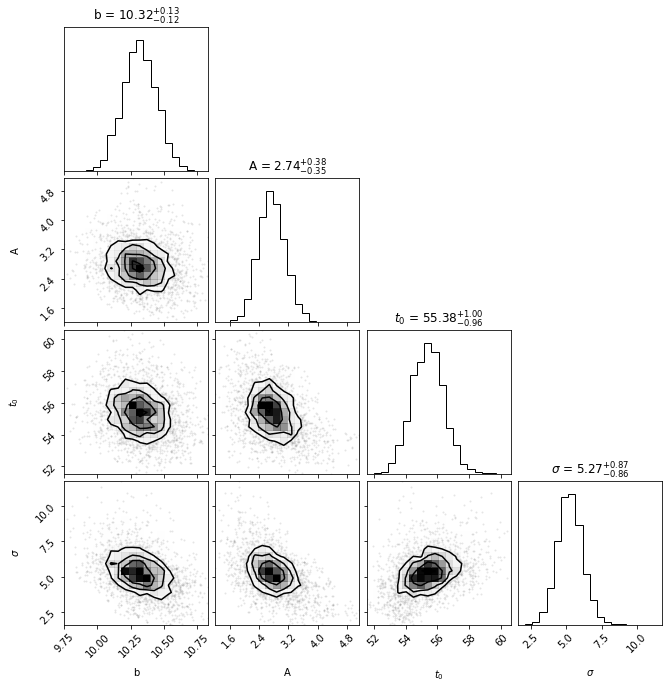

In [234]:
#CLD sort of just interested in seeing this but also i think would give a good visualization if something was totally
#CLD off the mark
cornerplot(result2)

In [235]:
#CLD from the model comparison documentation provided by ultranest 
#CLD at https://johannesbuchner.github.io/UltraNest/example-sine-modelcomparison.html
#CLD the bayes factor is calculated by taking the exp of the difference of logz 
bayes_factor = np.exp(result2['logz'] - result1['logz'])
print("Bayes factor = %.2f" % bayes_factor)

Bayes factor = 0.02


From this Bayes factor, the Gaussian profile model of this flux is slightly favored over the original burst model.